In [10]:
"""
Date: February 15, 2021
The purpose of this notebook is to simulate a mechanical trading system based on a breakout system with a trend
filter.
The idea is to go long only when the fast moving average is above the slow moving average and go short only when the 
fast moving average is below the slow moving average. Buys happen when the price has the highest close in x days,
and exits occur when the price has closed below z atr below the highest price seen by the trade. Sells happen when the
price has the lowest close in y days, and exits occur when the price has closed above z atr above the lowest price seen
by the trade.

No hard stops are used

Fees:
For the purposes of this experiment, we assume that every trade incurs a commission of $20 USD.

Timeframe:
Daily candles will be used, and the system will be tested for the period Jan 2006 - Dec 2020, for a total of 15 years.
This will serve as the in-sample test. If data can be found, an out-sample test will be done for the period
Jan 1991 - Dec 2005.

Goals:
A cumulative return of 30% or more over 15 years will be used as very strong evidence that the system is profitable.
An examination of the graph of the value of the account over time will be analyzed as well to provide better insights.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
def sma_x(data, length):
    """Gives the simple MA average of *data['Close']* with a window of *length* number of days, i.e. the *length*-day MA"""
    return pd.Series(data.iloc[:,3].rolling(window=length).mean(),index=data.index)

In [3]:
"""Define system functions here"""
def simulsys(markets, initval, longest, comm, risk, slowdc, fastdc, atr_multiple):
    """Takes market data and simulates trading. 
    markets is the ohlc price history of all markets that includes
    a column with the 20-day SMA ATR, a column for the tick value, and a column for the tick size. For instruments
    that are denominated in a currency other than the U.S. dollar, a column with the FX rate is included. 
    initval is an integer denoting the inital account value. 
    Longest is the ohlc price history of the market with the most traded days. 
    comm is a floating point denoting commission. 
    risk is a floating point denoting the theorectical impact on the portfolio in terms of a proportion. 
    slowdc is an integer denoting the length of the look-back window for the longer Donchian Channel. 
    fastdc is an integer denoting the length of the look-back window for the shorter Donchian Channel"""
    
    """Initiating DataFrame to track the different states of each market at any point in time"""
    #-----------------------------------------------------------------------------------------
    cur_states = pd.DataFrame({'In trade?':False},index=[''])
    for i in range(len(markets)):
        new = pd.DataFrame({"In trade?": False},
                           index=[markets[i,3]])
        cur_states = cur_states.append(new)
    cur_states = cur_states.drop('')
    signal = ''
    #-----------------------------------------------------------------------------------------
    
    """Initiating DataFrame to track the open trades in each market at any point in time"""
    #-----------------------------------------------------------------------------------------
    open_trades = pd.DataFrame({'Entry Date':'','Entry Price':0,'# of contracts':0,'Long/Short':'',
                               'Exit Date':'','Exit Price':0,'PnL':0,'Trade best':0,'Stop':0,'ATR':0,'R Multiple':0},index=[''])
    for i in range(len(markets)):
        mkt = pd.DataFrame({'Entry Date':'','Entry Price':0,'# of contracts':0,'Long/Short':'',
                            'Exit Date':'','Exit Price':0,'PnL':0,'Trade best':0,'Stop':0,'ATR':0,'R Multiple':0},index=[markets[i,3]])
        open_trades = open_trades.append(mkt)
    open_trades = open_trades.drop('')
    #-----------------------------------------------------------------------------------------
    
    """Initiating DataFrame to track total account value every day"""
    #-----------------------------------------------------------------------------------------
    act_val = pd.DataFrame({'Total account liquidation value':initval},index=['2005-12-31'])
    print(act_val.iloc[0])
    #-----------------------------------------------------------------------------------------
    
    """Variable to keep track of total number of trades open in each direction"""
    #-----------------------------------------------------------------------------------------
    num_long = 0
    num_short = 0
    #------------------------------------------------------------------------------------------------
        
    """Initiating DataFrame to track all trades made"""
    #-----------------------------------------------------------------------------------------
    ls_trades = pd.DataFrame({'Entry Date':'','Entry Price':0,'# of contracts':0,'Long/Short':'',
                               'Exit Date':'','Exit Price':0,'PnL':0},index=[''])
    #-----------------------------------------------------------------------------------------
    
    """Setup to make the for loop start looping from the proper start date"""
    loong = len(longest)
    for i in range(len(longest)):
        if longest[i][0] == '2006-01-02':
            z = i
            break
    loongs = len(longest) - z
    
    """Begin on 2006-01-01"""
    #-----------------------------------------------------------------------------------------
    for i in range(loong-loongs, loong-20):
        ii = longest[i][0]
        yo = act_val.iloc[i-(loong-loongs)][0]
        new_val = pd.DataFrame({'Total account liquidation value':yo},index=[ii])
        act_val = act_val.append(new_val)
        print(act_val.iloc[-1])
        """Loop through each market"""
        for j in range(len(markets)):
            """Since not all datasets have the same date, we must use try"""
            go = False
            for i in range(len(markets[j,0])):
                if markets[j,0][i][0] == ii:
                    loc_ind = i
                    go = True
                    break
            if go:
                """Initialize variables to be used"""
                mkt_ind = markets[j,3]
                opn = markets[j,0][loc_ind][1]
                high = markets[j,0][loc_ind][2]
                low = markets[j,0][loc_ind][3]
                cls = markets[j,0][loc_ind][4]
                atr = markets[j,0][loc_ind][5]
                tval = markets[j,0][loc_ind][6]
                tsize = markets[j,0][loc_ind][7]
                fastma = markets[j,1].loc[ii]
                slowma = markets[j,2].loc[ii]
                """For futures that are denominated in foreign currency"""
                try:
                    fx_rate = markets[j,0][loc_ind+1][8]
                except:
                    fx_rate = 1
                    pass
                """Updating the status of the market"""
                #------------------------------------------------------------------------------
                
                """Check which of longs or shorts the market is allowing by checking if the slow moving average
                is above or below the fast moving average"""
                if fastma >= slowma:
                    """Fast moving average is above slow moving average"""
                    if cls == max(markets[j,0][loc_ind - slowdc+1:loc_ind+1,4]):
                        signal = 'Long'
                    else:
                        signal = 'None'
                elif fastma < slowma:
                    """Fast moving average is below slow moving average"""
                    if cls == min(markets[j,0][loc_ind - slowdc+1:loc_ind+1,4]):
                        signal = 'Short'
                    else:
                        signal = 'None'
                #------------------------------------------------------------------------------
                #END OF STATUS UPDATES
                
                if cur_states.loc[mkt_ind]['In trade?'] == False and signal =='None':
                    continue
                
                """Common variables used"""
                entry_price = open_trades.iloc[j]['Entry Price']
                no_contracts = open_trades.iloc[j]['# of contracts']
                pnl = open_trades.iloc[j]['PnL']
                direction = open_trades.iloc[j]['Long/Short']
                stop = open_trades.iloc[j]['Stop']
                trade_atr = open_trades.iloc[j]['ATR']
                #------------------------------------------------------------------------------
                
                """Entries and exits"""
                #EXITS AND OTHER UPDATES
                #---------------------------------------------------------------------------
                if cur_states.loc[mkt_ind]['In trade?'] == True:
                    #Actions to do if the market is currently in a trade
                    if direction=='Long':
                        if cls < stop:
                            """If today's close was a 25-day low close"""
                            #Update account value
                            act_val.loc[ii] += fx_rate*((markets[j,0][loc_ind+1][1] - entry_price)/tsize)*tval*no_contracts - pnl
                            #Update the list of trades
                            open_trades.loc[mkt_ind,'Exit Date'] = markets[j,0][loc_ind+1][0]
                            open_trades.loc[mkt_ind,'Exit Price'] = markets[j,0][loc_ind+1][1]
                            open_trades.loc[mkt_ind,'PnL'] = fx_rate*((markets[j,0][loc_ind+1][1] - entry_price)/tsize)*tval*no_contracts
                            open_trades.loc[mkt_ind,'R Multiple'] = (markets[j,0][loc_ind+1][1] - entry_price)/trade_atr
                            ls_trades = ls_trades.append(open_trades.loc[mkt_ind])
                            print(open_trades.iloc[j])
                            #Indicate that there is no trade in this market
                            cur_states.loc[mkt_ind]['In trade?'] = False
                            open_trades.loc[mkt_ind] = open_trades.iloc[j] * 0
                        else:
                            """Otherwise, just update the account value and stop"""
                            act_val.loc[ii] += fx_rate*((cls - entry_price)/tsize)*tval*no_contracts - pnl
                            open_trades.loc[mkt_ind,'PnL'] = ((cls - entry_price)/tsize)*tval*no_contracts*fx_rate
                            #Update the trade best and stop
                            open_trades.loc[mkt_ind,'Trade best'] = max(high, open_trades.iloc[j]['Trade best'])
                            open_trades.loc[mkt_ind,'Stop'] = open_trades.loc[mkt_ind,'Trade best'] - (atr_multiple*atr)
                            continue
                    if direction=='Short':
                        if cls > stop:
                            """If today's close was above the stop"""
                            #Update account value
                            act_val.loc[ii] += ((entry_price - markets[j,0][loc_ind+1][1])/tsize)*tval*no_contracts*fx_rate - pnl
                            #Update the list of trades
                            open_trades.loc[mkt_ind,'Exit Date'] = markets[j,0][loc_ind+1][0]
                            open_trades.loc[mkt_ind,'Exit Price'] = markets[j,0][loc_ind+1][1]
                            open_trades.loc[mkt_ind,'PnL'] = fx_rate*((entry_price - markets[j,0][loc_ind+1][1])/tsize)*tval*no_contracts
                            open_trades.loc[mkt_ind,'R Multiple'] = (entry_price - markets[j,0][loc_ind+1][1])/trade_atr
                            ls_trades = ls_trades.append(open_trades.loc[mkt_ind])
                            print(open_trades.iloc[j])
                            #Indicate that there is no trade in this market
                            cur_states.loc[mkt_ind]['In trade?'] = False
                            open_trades.loc[mkt_ind] = open_trades.iloc[j] * 0
                        else:
                            """Otherwise, just update the account value"""
                            act_val.loc[ii] += fx_rate*((entry_price - cls)/tsize)*tval*no_contracts - pnl
                            open_trades.loc[mkt_ind,'PnL'] = ((entry_price - cls)/tsize)*tval*no_contracts*fx_rate
                            #Update the trade best and stop
                            open_trades.loc[mkt_ind,'Trade best'] = min(low, open_trades.iloc[j]['Trade best'])
                            open_trades.loc[mkt_ind,'Stop'] = open_trades.loc[mkt_ind,'Trade best'] + (atr_multiple*atr)
                            continue
                #ENTRIES
                #---------------------------------------------------------------------------
                if signal=='Long':
                    #Long entries
                    open_trades.loc[mkt_ind,'Entry Date'] = markets[j,0][loc_ind+1][0]
                    open_trades.loc[mkt_ind,'Entry Price'] = markets[j,0][loc_ind+1][1]
                    open_trades.loc[mkt_ind,'# of contracts'] = np.floor(act_val.loc[ii][0]*risk/(np.floor(atr/tsize)*tval*fx_rate))
                    open_trades.loc[mkt_ind,'Long/Short'] = 'Long'
                    open_trades.loc[mkt_ind,'Trade best'] = high
                    open_trades.loc[mkt_ind,'Stop'] = high - atr_multiple*atr
                    open_trades.loc[mkt_ind,'ATR'] = atr
                    cur_states.loc[mkt_ind,'In trade?'] = True
                    print(open_trades.iloc[j])
                elif signal=='Short':
                    #Short entries
                    open_trades.loc[mkt_ind,'Entry Date'] = markets[j,0][loc_ind+1][0]
                    open_trades.loc[mkt_ind,'Entry Price'] = markets[j,0][loc_ind+1][1]
                    open_trades.loc[mkt_ind,'# of contracts'] = np.floor(act_val.loc[ii][0]*risk/(np.floor(atr/tsize)*tval*fx_rate))
                    open_trades.loc[mkt_ind,'Long/Short'] = 'Short'
                    open_trades.loc[mkt_ind,'Trade best'] = low
                    open_trades.loc[mkt_ind,'Stop'] = low + atr_multiple*atr
                    open_trades.loc[mkt_ind,'ATR'] = atr
                    cur_states.loc[mkt_ind,'In trade?'] = True
                    print(open_trades.iloc[j])
                else:
                    continue
            else:
                """If the date doesn't exist, just go to the next market"""
                continue
    return ls_trades, act_val, open_trades

In [4]:
"""Import all data"""
#---Agricultural commoditites---
"""ICEUS Coffee"""
grab = pd.read_csv("KC Adjusted - 2005 - 2020.csv")
iceus_kc = pd.DataFrame(grab).dropna(axis='rows')
iceus_kc = iceus_kc.set_index("time")
"""ICEUS Sugar"""
grab = pd.read_csv("SB Adjusted - 2005 - 2020.csv")
iceus_sb = pd.DataFrame(grab).dropna(axis='rows')
iceus_sb = iceus_sb.set_index("time")
"""CME Lean Hogs"""
grab = pd.read_csv("HE Adjusted - 2005 - 2020.csv")
cme_he = pd.DataFrame(grab).dropna(axis='rows')
cme_he = cme_he.set_index("time")
"""ICEUS Cotton"""
grab = pd.read_csv("CT Adjusted - 2005 - 2020.csv")
iceus_ct = pd.DataFrame(grab).dropna(axis='rows')
iceus_ct = iceus_ct.set_index("time")
"""CME Live Cattle"""
grab = pd.read_csv("LE Adjusted - 2005 - 2020.csv")
cme_le = pd.DataFrame(grab).dropna(axis='rows')
cme_le = cme_le.set_index("time")
"""CBOT Corn"""
grab = pd.read_csv("ZC Adjusted - 2005 - 2020.csv")
cbot_zc = pd.DataFrame(grab).dropna(axis='rows')
cbot_zc = cbot_zc.set_index("time")
"""CBOT Soybean"""
grab = pd.read_csv("ZS Adjusted - 2005 - 2020.csv")
cbot_zs = pd.DataFrame(grab).dropna(axis='rows')
cbot_zs = cbot_zs.set_index("time")
"""ICEUS Cocoa"""
grab = pd.read_csv("CC Adjusted - 2005 - 2020.csv")
iceus_cc = pd.DataFrame(grab).dropna(axis='rows')
iceus_cc = iceus_cc.set_index("time")

#---Non-agricultural commodities---
"""Silver"""
grab = pd.read_csv("SI Adjusted - 2005 - 2020.csv")
comex_si = pd.DataFrame(grab).dropna(axis='rows')
comex_si = comex_si.set_index("time")
"""Copper"""
grab = pd.read_csv("HG Adjusted - 2005 - 2020.csv")
comex_hg = pd.DataFrame(grab).dropna(axis='rows')
comex_hg = comex_hg.set_index("time")
"""Gold"""
grab = pd.read_csv("GC Adjusted - 2005 - 2020.csv")
comex_gc = pd.DataFrame(grab).dropna(axis='rows')
comex_gc = comex_gc.set_index("time")
"""Low Sulphur Gas Oil"""
grab = pd.read_csv("GAS Adjusted - 2005 - 2020.csv")
iceeur_gas = pd.DataFrame(grab).dropna(axis='rows')
iceeur_gas = iceeur_gas.set_index("time")
"""Henry Hub Natural Gas"""
grab = pd.read_csv("NG Adjusted - 2005 - 2020.csv")
nymex_ng = pd.DataFrame(grab).dropna(axis='rows')
nymex_ng = nymex_ng.set_index("time")
"""Crude Oil"""
grab = pd.read_csv("CL Adjusted - 2005 - 2020.csv")
nymex_cl = pd.DataFrame(grab).dropna(axis='rows')
nymex_cl = nymex_cl.set_index("time")
"""NY Harbor ULSD"""
grab = pd.read_csv("HO Adjusted - 2005 - 2020.csv")
nymex_ho = pd.DataFrame(grab).dropna(axis='rows')
nymex_ho = nymex_ho.set_index("time")

#---Rates---
"""3-month Canada Bankers' Acceptance"""
grab = pd.read_csv("BA Adjusted - 2005 - 2020.csv")
tmx_ba = pd.DataFrame(grab).dropna(axis='rows')
tmx_ba = tmx_ba.set_index("time")
"""Aussie 3-year"""
grab = pd.read_csv("YT Adjusted - 2005 - 2020.csv")
asx_yt = pd.DataFrame(grab).dropna(axis='rows')
asx_yt = asx_yt.set_index("time")
"""Short Sterling"""
grab = pd.read_csv("L Adjusted - 2005 - 2020.csv")
iceeur_l = pd.DataFrame(grab).dropna(axis='rows')
iceeur_l = iceeur_l.set_index("time")
"""Euribor"""
grab = pd.read_csv("I Adjusted - 2005 - 2020.csv")
iceeur_i = pd.DataFrame(grab).dropna(axis='rows')
iceeur_i = iceeur_i.set_index("time")
"""Long gilt"""
grab = pd.read_csv("R Adjusted - 2005 - 2020.csv")
iceeur_r = pd.DataFrame(grab).dropna(axis='rows')
iceeur_r = iceeur_r.set_index("time")
"""U.S. 30-yr Treasury Bond"""
grab = pd.read_csv("ZB Adjusted - 2005 - 2020.csv")
cbot_zb = pd.DataFrame(grab).dropna(axis='rows')
cbot_zb = cbot_zb.set_index("time")
"""U.S. 10-yr Treasury"""
grab = pd.read_csv("ZN Adjusted - 2005 - 2020.csv")
cbot_zn = pd.DataFrame(grab).dropna(axis='rows')
cbot_zn = cbot_zn.set_index("time")
"""U.S. 5-yr Treasury"""
grab = pd.read_csv("ZF Adjusted - 2005 - 2020.csv")
cbot_zf = pd.DataFrame(grab).dropna(axis='rows')
cbot_zf = cbot_zf.set_index("time")
"""U.S. 2-yr Treasury"""
grab = pd.read_csv("ZT Adjusted - 2005 - 2020.csv")
cbot_zt = pd.DataFrame(grab).dropna(axis='rows')
cbot_zt = cbot_zt.set_index("time")
"""Eurodollar"""
grab = pd.read_csv("GE adjusted - 2005 - 2020.csv")
cme_ge = pd.DataFrame(grab).dropna(axis='rows')
cme_ge = cme_ge.set_index("time")


#---Currencies---
"""AUDUSD"""
grab = pd.read_csv("AUDUSD - 2005 - 2020.csv")
audusd = pd.DataFrame(grab).dropna(axis='rows')
audusd = audusd.set_index("time")
"""GBPUSD"""
grab = pd.read_csv("GBPUSD - 2005 - 2020.csv")
gbpusd = pd.DataFrame(grab).dropna(axis='rows')
gbpusd = gbpusd.set_index("time")
"""EURUSD"""
grab = pd.read_csv("EURUSD - 2005 - 2020.csv")
fx_eurusd = pd.DataFrame(grab).dropna(axis='rows')
fx_eurusd = fx_eurusd.set_index("time")
"""CADUSD"""
grab = pd.read_csv("CADUSD - 2005 - 2020.csv")
fx_idc_cadusd = pd.DataFrame(grab).dropna(axis='rows')
fx_idc_cadusd = fx_idc_cadusd.set_index("time")
"""CHFUSD"""
grab = pd.read_csv("CHFUSD - 2005 - 2020.csv")
fx_idc_chfusd = pd.DataFrame(grab).dropna(axis='rows')
fx_idc_chfusd = fx_idc_chfusd.set_index("time")
"""JPYUSD"""
grab = pd.read_csv("JPYUSD - 2005 - 2020.csv")
fx_idc_jpyusd = pd.DataFrame(grab).dropna(axis='rows')
fx_idc_jpyusd = fx_idc_jpyusd.set_index("time")


#---Equities---
"""Nikkei 225"""
grab = pd.read_csv("NK Adjusted - 2005 - 2020.csv")
ose_nk = pd.DataFrame(grab).dropna(axis='rows')
ose_nk = ose_nk.set_index("time")
"""Stoxx"""
grab = pd.read_csv("Stoxx50 Adjusted - 2005 - 2020.csv")
iceeur_vg = pd.DataFrame(grab).dropna(axis='rows')
iceeur_vg = iceeur_vg.set_index("time")
"""E-mini Nasdaq"""
grab = pd.read_csv("NQ Adjusted - 2005 - 2020.csv")
cme_nq = pd.DataFrame(grab).dropna(axis='rows')
cme_nq = cme_nq.set_index("time")
"""E-mini S&P 500"""
grab = pd.read_csv("ES Adjusted - 2005 - 2020.csv")
cme_es = pd.DataFrame(grab).dropna(axis='rows')
cme_es = cme_es.set_index("time")
"""Mini Dow Jones"""
grab = pd.read_csv("YM Adjusted - 2005 - 2020.csv")
cme_ym = pd.DataFrame(grab).dropna(axis='rows')
cme_ym = cme_ym.set_index("time")
"""FTSE 100"""
grab = pd.read_csv("Z Adjusted - 2005 - 2020.csv")
iceeur_z = pd.DataFrame(grab).dropna(axis='rows')
iceeur_z = iceeur_z.set_index("time")
"""German DAX"""
grab = pd.read_csv("FDAX Adjusted - 2005 - 2020.csv")
eux_fdax = pd.DataFrame(grab).dropna(axis='rows')
eux_fdax = eux_fdax.set_index("time")


"""Topix"""
grab = pd.read_csv("TOPIX Adjusted - 2005 - 2020.csv")
topix = pd.DataFrame(grab).dropna(axis='rows')
topix = topix.set_index("time")




'Hang Seng'

In [5]:
"""Make a list of all the price data"""
acts = np.array([[iceeur_gas,None,None,"iceeur_gas"],[comex_si,None,None,"comex_si"],[iceeur_vg,None,None,"iceeur_vg"],
                 [audusd,None,None,"audusd"],[iceeur_i,None,None,"iceeur_i"],[iceus_kc,None,None,"iceus_kc"],
                 [iceeur_r,None,None,"iceeur_r"],[iceeur_z,None,None,"iceeur_z"],[iceus_sb,None,None,"iceus_sb"],
                 [cme_he,None,None,"cme_he"],[cbot_zb,None,None,"cbot_zb"],[comex_hg,None,None,"comex_hg"],
                 [iceus_ct,None,None,"iceus_ct"],[cme_le,None,None,"cme_le"],[nymex_ng,None,None,"nymex_ng"],
                 [cme_nq,None,None,"cme_nq"],[gbpusd,None,None,"gbpusd"],[comex_gc,None,None,"comex_gc"],
                 [cbot_zn,None,None,"cbot_zn"],[fx_eurusd,None,None,"fx_eurusd"],[cme_ge,None,None,"cme_ge"],
                 [cme_es,None,None,"cme_es"],[fx_idc_cadusd,None,None,"fx_idc_cadusd"],[nymex_cl,None,None,"nymex_cl"],
                 [iceus_cc,None,None,"iceus_cc"],[cbot_zs,None,None,"cbot_zs"],[fx_idc_chfusd,None,None,"fx_idc_chfusd"],
                 [cbot_zc,None,None,"cbot_zc"],[fx_idc_jpyusd,None,None,"fx_idc_jpyusd"],[ose_nk,None,None,"ose_nk"],
                [cbot_zf,None,None,"cbot_zf"],[tmx_ba,None,None,"tmx_ba"],[iceeur_l,None,None,"iceeur_l"],
                [cbot_zt,None,None,"cbot_zt"],[cme_ym,None,None,"cme_ym"],[topix,None,None,"topix"],
                [eux_fdax,None,None,"eux_fdax"],[asx_yt,None,None,"asx_yt"],[nymex_ho,None,None,"nymex_ho"]],dtype=object)

In [6]:
"""Adding custom simple moving averages for each dataset"""
for i in range(len(acts)):
    acts[i][1]= sma_x(acts[i][0], 20)
    acts[i][2]= sma_x(acts[i][0], 200)

In [7]:
for market in range(len(acts)):
    dvalues = acts[market][0].iloc[:].values.tolist()
    dates = acts[market][0].index
    acts[market][0] = np.array([[dates[j]] + dvalues[j] for j in range(len(dates))],dtype='O')

In [8]:
"""Calculating the length of the longest array. Pass maxar later into the actual function"""
maxnum = 0
maxar = None
for i in acts[:,0]:
    if len(i) > maxnum:
        maxnum = len(i)
        maxar = i

In [11]:
all_trades = simulsys(acts, 5000000, maxar, 20,0.0038,55,25,2)

Total account liquidation value    5000000
Name: 2005-12-31, dtype: int64
Total account liquidation value    5000000
Name: 2006-01-02, dtype: int64
Total account liquidation value    5000000
Name: 2006-01-03, dtype: int64
Entry Date        2006-01-04
Entry Price            15.94
# of contracts          15.0
Long/Short              Long
Exit Date                   
Exit Price                 0
PnL                        0
Trade best            15.955
Stop                   15.46
ATR                   0.2475
R Multiple                 0
Name: comex_si, dtype: object
Entry Date        2006-01-04
Entry Price           3886.0
# of contracts          26.0
Long/Short              Long
Exit Date                   
Exit Price                 0
PnL                        0
Trade best            3879.5
Stop                 3796.75
ATR                   41.375
R Multiple                 0
Name: iceeur_z, dtype: object
Entry Date        2006-01-04
Entry Price            888.3
# of contracts        

Name: 2006-01-31, dtype: float64
Total account liquidation value    4.997540e+06
Name: 2006-02-01, dtype: float64
Entry Date        2006-01-30
Entry Price           339.85
# of contracts          13.0
Long/Short              Long
Exit Date         2006-02-02
Exit Price             332.1
PnL                -37781.25
Trade best            340.75
Stop                  332.66
ATR                   3.7475
R Multiple         -2.068045
Name: iceus_kc, dtype: object
Entry Date        2006-02-02
Entry Price        94.175781
# of contracts          90.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best         94.160156
Stop               94.375781
ATR                 0.107813
R Multiple               0.0
Name: cbot_zt, dtype: object
Total account liquidation value    5.029285e+06
Name: 2006-02-02, dtype: float64
Entry Date        2006-02-03
Entry Price           26.326
# of contracts           3.0
Long/Short           

Name: nymex_ho, dtype: object
Total account liquidation value    5.064899e+06
Name: 2006-02-27, dtype: float64
Entry Date        2006-02-28
Entry Price           0.7561
# of contracts     3473182.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            0.7559
Stop                 0.76713
ATR                 0.005615
R Multiple               0.0
Name: fx_idc_chfusd, dtype: object
Total account liquidation value    5.128010e+06
Name: 2006-02-28, dtype: float64
Entry Date        2006-01-30
Entry Price           3959.5
# of contracts          21.0
Long/Short              Long
Exit Date         2006-03-01
Exit Price            3957.5
PnL                 -735.042
Trade best            4057.0
Stop                 3954.35
ATR                   51.425
R Multiple         -0.038892
Name: iceeur_z, dtype: object
Entry Date        2006-03-01
Entry Price           0.8797
# of contracts     3755404.0
Long/Short        

Name: 2006-03-22, dtype: float64
Total account liquidation value    5.163367e+06
Name: 2006-03-23, dtype: float64
Entry Date        2006-03-24
Entry Price            95.01
# of contracts         225.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best              95.0
Stop                  95.081
ATR                   0.0405
R Multiple               0.0
Name: iceeur_l, dtype: object
Entry Date        2006-03-24
Entry Price           6798.0
# of contracts           8.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            6799.0
Stop                  6643.9
ATR                    77.55
R Multiple               0.0
Name: eux_fdax, dtype: object
Total account liquidation value    5.169480e+06
Name: 2006-03-24, dtype: float64
Entry Date        2006-03-08
Entry Price           231.05
# of contracts          39.0
Long/Short          

Name: 2006-04-13, dtype: float64
Entry Date        2006-04-17
Entry Price            70.78
# of contracts          53.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             70.45
Stop                  72.126
ATR                    0.838
R Multiple               0.0
Name: iceus_ct, dtype: object
Total account liquidation value    5.911634e+06
Name: 2006-04-14, dtype: float64
Total account liquidation value    5.926956e+06
Name: 2006-04-17, dtype: float64
Entry Date        2006-03-17
Entry Price            288.5
# of contracts          31.0
Long/Short             Short
Exit Date         2006-04-18
Exit Price            283.25
PnL                   8137.5
Trade best            266.25
Stop                   282.1
ATR                    12.35
R Multiple          0.425101
Name: cbot_zs, dtype: object
Entry Date        2006-03-29
Entry Price          13860.0
# of contracts           9.0
Long/Short           

Total account liquidation value    6.551389e+06
Name: 2006-05-05, dtype: float64
Entry Date        2006-05-08
Entry Price           0.7729
# of contracts     3285363.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            0.7744
Stop                 0.75906
ATR                  0.00767
R Multiple               0.0
Name: audusd, dtype: object
Entry Date        2006-05-08
Entry Price           1095.5
# of contracts          38.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1097.5
Stop                 1071.45
ATR                   13.025
R Multiple              -0.0
Name: cme_es, dtype: object
Total account liquidation value    6.593753e+06
Name: 2006-05-08, dtype: float64
Entry Date        2006-05-09
Entry Price            314.8
# of contracts          22.0
Long/Short             Short
Exit Date                   

Name: 2006-05-24, dtype: float64
Entry Date        2006-05-15
Entry Price           678.75
# of contracts          90.0
Long/Short              Long
Exit Date         2006-05-25
Exit Price             669.5
PnL                 -41625.0
Trade best            683.75
Stop                  671.65
ATR                   5.7875
R Multiple         -1.598272
Name: cbot_zc, dtype: object
Total account liquidation value    5.974627e+06
Name: 2006-05-25, dtype: float64
Total account liquidation value    5.997115e+06
Name: 2006-05-26, dtype: float64
Entry Date        2006-05-23
Entry Price           1813.5
# of contracts          47.0
Long/Short             Short
Exit Date         2006-05-30
Exit Price            1833.0
PnL                 -18330.0
Trade best            1784.0
Stop                1835.225
ATR                   24.075
R Multiple         -0.809969
Name: cme_nq, dtype: object
Entry Date         2006-04-28
Entry Price            1.8017
# of contracts      1803978.0
Long/Short          

Name: 2006-06-30, dtype: float64
Entry Date        2006-05-09
Entry Price            314.8
# of contracts          22.0
Long/Short             Short
Exit Date         2006-07-03
Exit Price             307.0
PnL                  64350.0
Trade best            300.35
Stop                 304.045
ATR                     3.03
R Multiple          2.574257
Name: iceus_kc, dtype: object
Entry Date        2006-06-23
Entry Price         63.71875
# of contracts          56.0
Long/Short             Short
Exit Date         2006-07-03
Exit Price         64.328125
PnL                 -34125.0
Trade best         63.515625
Stop               64.292187
ATR                 0.404687
R Multiple         -1.505792
Name: cbot_zn, dtype: object
Entry Date        2006-06-16
Entry Price        77.867188
# of contracts          73.0
Long/Short             Short
Exit Date         2006-07-03
Exit Price         77.773438
PnL                  6843.75
Trade best         77.226562
Stop               77.748437
ATR      

Entry Date        2006-08-15
Entry Price           93.247
# of contracts         127.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            93.237
Stop                  93.379
ATR                    0.071
R Multiple              -0.0
Name: asx_yt, dtype: object
Total account liquidation value    5.414902e+06
Name: 2006-08-15, dtype: float64
Total account liquidation value    5.421429e+06
Name: 2006-08-16, dtype: float64
Entry Date        2006-08-17
Entry Price            95.82
# of contracts         154.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best              95.8
Stop                  95.679
ATR                   0.0605
R Multiple               0.0
Name: tmx_ba, dtype: object
Entry Date        2006-08-17
Entry Price           9200.0
# of contracts          32.0
Long/Short              Long
Exit Date                   

Entry Date        2006-08-31
Entry Price           180.95
# of contracts          48.0
Long/Short              Long
Exit Date         2006-09-11
Exit Price             180.2
PnL                 -14400.0
Trade best            182.65
Stop                 180.585
ATR                  1.09375
R Multiple         -0.685714
Name: cme_le, dtype: object
Entry Date        2006-09-01
Entry Price           0.9059
# of contracts     3034775.0
Long/Short              Long
Exit Date         2006-09-11
Exit Price            0.8929
PnL               -39452.075
Trade best            0.9066
Stop                 0.89382
ATR                  0.00688
R Multiple         -1.889535
Name: fx_idc_cadusd, dtype: object
Entry Date        2006-09-11
Entry Price           124.56
# of contracts          14.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            124.51
Stop                 127.216
ATR                    1.353
R Multipl

Total account liquidation value    5.416044e+06
Name: 2006-10-04, dtype: float64
Entry Date        2006-10-05
Entry Price            17.07
# of contracts           8.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            16.895
Stop                   17.86
ATR                   0.4825
R Multiple              -0.0
Name: comex_si, dtype: object
Total account liquidation value    5.548610e+06
Name: 2006-10-05, dtype: float64
Entry Date        2006-09-05
Entry Price           22.121
# of contracts           4.0
Long/Short             Short
Exit Date         2006-10-06
Exit Price            20.989
PnL                  45280.0
Trade best            20.033
Stop                 20.7606
ATR                  0.48395
R Multiple          2.339085
Name: nymex_ng, dtype: object
Entry Date        2006-10-06
Entry Price          13830.0
# of contracts          10.0
Long/Short              Long
Exit Date               

Total account liquidation value    5.353214e+06
Name: 2006-10-30, dtype: float64
Entry Date        2006-10-09
Entry Price           4128.0
# of contracts          17.0
Long/Short              Long
Exit Date         2006-10-31
Exit Price            4246.5
PnL                38424.573
Trade best            4377.5
Stop                  4265.0
ATR                    61.95
R Multiple          1.912833
Name: iceeur_z, dtype: object
Entry Date        2006-10-06
Entry Price          13830.0
# of contracts          10.0
Long/Short              Long
Exit Date         2006-10-31
Exit Price           13750.0
PnL                  -6839.2
Trade best           14280.0
Stop                 13869.0
ATR                    247.5
R Multiple         -0.323232
Name: ose_nk, dtype: object
Entry Date        2006-10-24
Entry Price           1370.0
# of contracts          11.0
Long/Short              Long
Exit Date         2006-10-31
Exit Price            1324.5
PnL               -42787.745
Trade best          

Name: cbot_zc, dtype: object
Total account liquidation value    5.192107e+06
Name: 2006-11-21, dtype: float64
Entry Date        2006-11-22
Entry Price           1.2844
# of contracts     2769614.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1.2855
Stop                 1.27117
ATR                 0.007165
R Multiple              -0.0
Name: fx_eurusd, dtype: object
Entry Date        2006-11-22
Entry Price           1228.5
# of contracts          10.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1228.5
Stop                 1271.95
ATR                   21.725
R Multiple              -0.0
Name: topix, dtype: object
Total account liquidation value    5.174415e+06
Name: 2006-11-22, dtype: float64
Entry Date        2006-11-23
Entry Price           0.7753
# of contracts     3861530.0
Long/Short              Lo

Name: cbot_zt, dtype: object
Total account liquidation value    4.840974e+06
Name: 2006-12-11, dtype: float64
Entry Date        2006-12-12
Entry Price           20.098
# of contracts           5.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            19.854
Stop                 20.5544
ATR                   0.3502
R Multiple               0.0
Name: nymex_ng, dtype: object
Total account liquidation value    4.893342e+06
Name: 2006-12-12, dtype: float64
Total account liquidation value    4.938782e+06
Name: 2006-12-13, dtype: float64
Entry Date        2006-12-14
Entry Price           365.45
# of contracts           9.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            364.75
Stop                 381.285
ATR                   8.2675
R Multiple              -0.0
Name: comex_hg, dtype: object
Entry Date        2006-12-14
E

Name: 2007-01-01, dtype: float64
Total account liquidation value    4.937052e+06
Name: 2007-01-02, dtype: float64
Entry Date        2007-01-03
Entry Price           4422.0
# of contracts          18.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            4434.0
Stop                  4326.2
ATR                     53.9
R Multiple              -0.0
Name: iceeur_z, dtype: object
Total account liquidation value    5.007677e+06
Name: 2007-01-03, dtype: float64
Entry Date        2007-01-04
Entry Price           111.78
# of contracts          14.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            111.19
Stop                 113.901
ATR                   1.3555
R Multiple              -0.0
Name: nymex_cl, dtype: object
Entry Date         2007-01-04
Entry Price          0.008375
# of contracts    379016925.0
Long/Short       

Name: ose_nk, dtype: object
Total account liquidation value    5.373969e+06
Name: 2007-01-19, dtype: float64
Total account liquidation value    5.317092e+06
Name: 2007-01-22, dtype: float64
Total account liquidation value    5.328825e+06
Name: 2007-01-23, dtype: float64
Entry Date        2006-12-26
Entry Price            286.6
# of contracts           9.0
Long/Short             Short
Exit Date         2007-01-24
Exit Price             269.6
PnL                  64260.0
Trade best            257.92
Stop                 267.395
ATR                   4.5575
R Multiple          3.730115
Name: nymex_ho, dtype: object
Total account liquidation value    5.319042e+06
Name: 2007-01-24, dtype: float64
Entry Date        2007-01-04
Entry Price           111.78
# of contracts          14.0
Long/Short             Short
Exit Date         2007-01-25
Exit Price            107.75
PnL                  56420.0
Trade best            103.39
Stop                 107.667
ATR                   1.3555
R Multipl

Name: 2007-02-14, dtype: float64
Entry Date        2007-02-15
Entry Price            58.14
# of contracts          50.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             57.94
Stop                   59.57
ATR                    0.815
R Multiple              -0.0
Name: iceus_ct, dtype: object
Total account liquidation value    5.381911e+06
Name: 2007-02-15, dtype: float64
Entry Date        2007-01-08
Entry Price            23.37
# of contracts          69.0
Long/Short             Short
Exit Date         2007-02-16
Exit Price             22.99
PnL                  29366.4
Trade best              22.1
Stop                   22.53
ATR                   0.2535
R Multiple          1.499014
Name: iceus_sb, dtype: object
Entry Date        2006-12-14
Entry Price           94.115
# of contracts         496.0
Long/Short             Short
Exit Date         2007-02-16
Exit Price             94.06
PnL           

Name: 2007-03-13, dtype: float64
Entry Date        2007-02-06
Entry Price            179.0
# of contracts          44.0
Long/Short              Long
Exit Date         2007-03-14
Exit Price           181.725
PnL                  47960.0
Trade best            184.45
Stop                182.1475
ATR                     1.18
R Multiple          2.309322
Name: cme_le, dtype: object
Entry Date        2007-03-12
Entry Price          94.0425
# of contracts         360.0
Long/Short             Short
Exit Date         2007-03-14
Exit Price           94.1225
PnL                 -36000.0
Trade best           94.0175
Stop                  94.103
ATR                  0.04075
R Multiple          -1.96319
Name: cme_ge, dtype: object
Entry Date        2007-03-14
Entry Price           2596.0
# of contracts          42.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            2610.0
Stop                  2525.7
ATR         

Name: 2007-04-12, dtype: float64
Entry Date        2007-04-02
Entry Price           299.95
# of contracts          23.0
Long/Short             Short
Exit Date         2007-04-13
Exit Price            303.75
PnL                 -32775.0
Trade best             299.0
Stop                  302.98
ATR                   2.0725
R Multiple         -1.833534
Name: iceus_kc, dtype: object
Entry Date        2007-04-13
Entry Price           1.9791
# of contracts     1698187.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            1.9811
Stop                 1.95919
ATR                 0.010955
R Multiple               0.0
Name: gbpusd, dtype: object
Total account liquidation value    4.892176e+06
Name: 2007-04-13, dtype: float64
Entry Date        2007-04-16
Entry Price           4576.5
# of contracts          14.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL             

Name: fx_idc_chfusd, dtype: object
Total account liquidation value    5.392317e+06
Name: 2007-05-04, dtype: float64
Entry Date        2007-03-16
Entry Price            22.23
# of contracts          54.0
Long/Short             Short
Exit Date         2007-05-07
Exit Price             21.23
PnL                  60480.0
Trade best             20.76
Stop                  21.209
ATR                    0.295
R Multiple          3.389831
Name: iceus_sb, dtype: object
Total account liquidation value    5.379227e+06
Name: 2007-05-07, dtype: float64
Total account liquidation value    5.410261e+06
Name: 2007-05-08, dtype: float64
Entry Date        2007-03-19
Entry Price           1.3311
# of contracts     2548113.0
Long/Short              Long
Exit Date         2007-05-09
Exit Price            1.3542
PnL               58861.4103
Trade best            1.3681
Stop                 1.35447
ATR                 0.006985
R Multiple          3.307087
Name: fx_eurusd, dtype: object
Total account liquidati

Name: 2007-05-25, dtype: float64
Entry Date        2007-05-16
Entry Price            20.53
# of contracts          79.0
Long/Short             Short
Exit Date         2007-05-29
Exit Price             21.29
PnL                 -67244.8
Trade best             20.51
Stop                  20.937
ATR                    0.239
R Multiple         -3.179916
Name: iceus_sb, dtype: object
Total account liquidation value    5.683517e+06
Name: 2007-05-28, dtype: float64
Total account liquidation value    5.677345e+06
Name: 2007-05-29, dtype: float64
Total account liquidation value    5.784437e+06
Name: 2007-05-30, dtype: float64
Entry Date        2007-05-21
Entry Price            685.5
# of contracts          14.0
Long/Short              Long
Exit Date         2007-05-31
Exit Price            671.25
PnL                 -19950.0
Trade best             697.5
Stop                 670.025
ATR                     14.3
R Multiple         -0.996503
Name: iceeur_gas, dtype: object
Entry Date        2007-0

Name: 2007-06-13, dtype: float64
Total account liquidation value    6.595275e+06
Name: 2007-06-14, dtype: float64
Entry Date        2007-06-07
Entry Price           0.8407
# of contracts     3889795.0
Long/Short              Long
Exit Date         2007-06-15
Exit Price            0.8356
PnL              -19837.9545
Trade best            0.8477
Stop                 0.83575
ATR                 0.006145
R Multiple         -0.829943
Name: audusd, dtype: object
Entry Date        2007-06-04
Entry Price           92.942
# of contracts         209.0
Long/Short             Short
Exit Date         2007-06-15
Exit Price            92.762
PnL                95050.692
Trade best            92.647
Stop                  92.758
ATR                  0.04875
R Multiple          3.692308
Name: asx_yt, dtype: object
Entry Date        2007-06-15
Entry Price           311.17
# of contracts          12.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL               

Total account liquidation value    6.285867e+06
Name: 2007-07-04, dtype: float64
Entry Date        2007-07-05
Entry Price            94.58
# of contracts         156.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            94.575
Stop                  94.673
ATR                    0.049
R Multiple               0.0
Name: iceeur_i, dtype: object
Total account liquidation value    6.325525e+06
Name: 2007-07-05, dtype: float64
Entry Date        2007-07-06
Entry Price            62.86
# of contracts          39.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             62.88
Stop                  60.419
ATR                   1.2305
R Multiple               0.0
Name: iceus_ct, dtype: object
Entry Date        2007-07-06
Entry Price           1470.5
# of contracts          17.0
Long/Short              Long
Exit Date               

Entry Date        2007-07-11
Entry Price           1.3747
# of contracts     4266679.0
Long/Short              Long
Exit Date         2007-07-26
Exit Price            1.3721
PnL              -11093.3654
Trade best            1.3852
Stop                 1.37257
ATR                  0.00582
R Multiple         -0.446735
Name: fx_eurusd, dtype: object
Entry Date        2007-07-11
Entry Price           0.8317
# of contracts     5244048.0
Long/Short              Long
Exit Date         2007-07-26
Exit Price            0.8241
PnL              -39854.7648
Trade best             0.836
Stop                 0.82529
ATR                  0.00478
R Multiple         -1.589958
Name: fx_idc_chfusd, dtype: object
Total account liquidation value    6.412182e+06
Name: 2007-07-26, dtype: float64
Entry Date        2007-07-02
Entry Price           0.8468
# of contracts     3770315.0
Long/Short              Long
Exit Date         2007-07-27
Exit Price             0.871
PnL                91241.623
Trade best  

Name: ose_nk, dtype: object
Total account liquidation value    6.135532e+06
Name: 2007-08-24, dtype: float64
Total account liquidation value    6.138438e+06
Name: 2007-08-27, dtype: float64
Total account liquidation value    6.168394e+06
Name: 2007-08-28, dtype: float64
Total account liquidation value    6.239900e+06
Name: 2007-08-29, dtype: float64
Entry Date        2007-08-30
Entry Price            93.86
# of contracts         199.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           93.8525
Stop                94.04875
ATR                 0.098125
R Multiple              -0.0
Name: cme_ge, dtype: object
Total account liquidation value    6.230683e+06
Name: 2007-08-30, dtype: float64
Total account liquidation value    6.290364e+06
Name: 2007-08-31, dtype: float64
Total account liquidation value    6.273006e+06
Name: 2007-09-03, dtype: float64
Total account liquidation value    6.289727e+06
Name: 2007

Name: asx_yt, dtype: object
Total account liquidation value    6.505084e+06
Name: 2007-09-25, dtype: float64
Entry Date        2007-09-26
Entry Price           2181.0
# of contracts          36.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            2184.0
Stop                2116.625
ATR                  33.6875
R Multiple               0.0
Name: cme_nq, dtype: object
Total account liquidation value    6.480228e+06
Name: 2007-09-26, dtype: float64
Entry Date        2007-09-11
Entry Price           322.59
# of contracts          12.0
Long/Short              Long
Exit Date         2007-09-27
Exit Price            324.07
PnL                   7459.2
Trade best            331.46
Stop                 323.733
ATR                    4.443
R Multiple          0.333108
Name: nymex_ho, dtype: object
Total account liquidation value    6.474037e+06
Name: 2007-09-27, dtype: float64
Total account liquidation value  

Name: eux_fdax, dtype: object
Total account liquidation value    6.600090e+06
Name: 2007-10-19, dtype: float64
Entry Date        2007-10-10
Entry Price           4673.0
# of contracts          12.0
Long/Short              Long
Exit Date         2007-10-22
Exit Price            4442.5
PnL               -56235.546
Trade best            4800.0
Stop                  4628.6
ATR                  100.675
R Multiple         -2.289546
Name: iceeur_z, dtype: object
Entry Date        2007-09-26
Entry Price           2181.0
# of contracts          36.0
Long/Short              Long
Exit Date         2007-10-22
Exit Price            2229.5
PnL                  34920.0
Trade best            2297.0
Stop                2238.325
ATR                  33.6875
R Multiple          1.439703
Name: cme_nq, dtype: object
Entry Date        2007-10-22
Entry Price           2.0519
# of contracts     1828938.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                

Name: 2007-11-07, dtype: float64
Entry Date         2007-11-08
Entry Price          0.008879
# of contracts    380183711.0
Long/Short               Long
Exit Date                    
Exit Price                0.0
PnL                      -0.0
Trade best            0.00888
Stop                  0.00873
ATR                  0.000075
R Multiple               -0.0
Name: fx_idc_jpyusd, dtype: object
Total account liquidation value    7.451853e+06
Name: 2007-11-08, dtype: float64
Entry Date        2007-11-09
Entry Price            60.17
# of contracts          27.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             60.29
Stop                  59.291
ATR                   0.4995
R Multiple               0.0
Name: iceeur_r, dtype: object
Entry Date        2007-10-24
Entry Price           2290.0
# of contracts          35.0
Long/Short              Long
Exit Date         2007-11-09
Exit Price           2189.7

Name: cbot_zn, dtype: object
Entry Date        2007-11-20
Entry Price           1131.0
# of contracts          19.0
Long/Short             Short
Exit Date         2007-11-29
Exit Price            1163.5
PnL                 -30875.0
Trade best           1098.75
Stop                 1161.45
ATR                   28.225
R Multiple         -1.151461
Name: cme_es, dtype: object
Entry Date        2007-11-21
Entry Price           149.39
# of contracts           9.0
Long/Short              Long
Exit Date         2007-11-29
Exit Price            143.47
PnL                 -53280.0
Trade best             150.3
Stop                 144.383
ATR                    2.993
R Multiple         -1.977949
Name: nymex_cl, dtype: object
Entry Date         2007-10-31
Entry Price            0.8628
# of contracts      4171362.0
Long/Short               Long
Exit Date          2007-11-29
Exit Price                0.9
PnL               155174.6664
Trade best             0.9176
Stop                  0.90216
ATR  

Total account liquidation value    7.194397e+06
Name: 2007-12-26, dtype: float64
Entry Date        2007-12-05
Entry Price           2747.0
# of contracts          77.0
Long/Short              Long
Exit Date         2007-12-27
Exit Price            2726.0
PnL                 -16170.0
Trade best            2834.0
Stop                  2749.3
ATR                    35.55
R Multiple         -0.590717
Name: iceus_cc, dtype: object
Total account liquidation value    7.195969e+06
Name: 2007-12-27, dtype: float64
Entry Date        2007-12-28
Entry Price           149.75
# of contracts           9.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            150.62
Stop                 144.717
ATR                   2.9515
R Multiple              -0.0
Name: nymex_cl, dtype: object
Total account liquidation value    7.165726e+06
Name: 2007-12-28, dtype: float64
Entry Date        2007-12-31
Entry Price            213.2
#

Name: iceus_ct, dtype: object
Total account liquidation value    7.552808e+06
Name: 2008-01-14, dtype: float64
Entry Date        2008-01-15
Entry Price           0.9149
# of contracts     3330645.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            0.9185
Stop                 0.90108
ATR                  0.00871
R Multiple               0.0
Name: fx_idc_chfusd, dtype: object
Total account liquidation value    7.679922e+06
Name: 2008-01-15, dtype: float64
Entry Date        2008-01-16
Entry Price           3966.0
# of contracts          14.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            3964.5
Stop                 4171.65
ATR                  103.575
R Multiple              -0.0
Name: iceeur_z, dtype: object
Entry Date        2008-01-16
Entry Price          1941.75
# of contracts          30.0
Long/Short        

Name: cme_nq, dtype: object
Entry Date        2008-01-28
Entry Price           2904.0
# of contracts          60.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            2904.0
Stop                  2803.1
ATR                    50.45
R Multiple              -0.0
Name: iceus_cc, dtype: object
Entry Date        2008-01-08
Entry Price           1097.5
# of contracts          10.0
Long/Short             Short
Exit Date         2008-01-28
Exit Price            1045.5
PnL                  48646.0
Trade best             927.5
Stop                  1004.6
ATR                     29.3
R Multiple          1.774744
Name: topix, dtype: object
Total account liquidation value    7.954741e+06
Name: 2008-01-28, dtype: float64
Total account liquidation value    8.000089e+06
Name: 2008-01-29, dtype: float64
Entry Date        2007-12-31
Entry Price            213.2
# of contracts          51.0
Long/Short             Short

Name: comex_gc, dtype: object
Entry Date        2008-01-28
Entry Price           2904.0
# of contracts          60.0
Long/Short              Long
Exit Date         2008-02-21
Exit Price            3137.0
PnL                 139800.0
Trade best            3263.0
Stop                  3155.3
ATR                    50.45
R Multiple          4.618434
Name: iceus_cc, dtype: object
Total account liquidation value    8.335401e+06
Name: 2008-02-21, dtype: float64
Entry Date        2008-02-22
Entry Price            446.8
# of contracts          11.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             451.5
Stop                  428.33
ATR                   11.585
R Multiple              -0.0
Name: comex_hg, dtype: object
Entry Date        2008-02-22
Entry Price            68.29
# of contracts          43.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL              

Name: cme_ge, dtype: object
Entry Date        2008-03-10
Entry Price           9133.0
# of contracts          31.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            9063.0
Stop                  9526.4
ATR                    231.7
R Multiple               0.0
Name: cme_ym, dtype: object
Total account liquidation value    9.700437e+06
Name: 2008-03-10, dtype: float64
Entry Date        2008-01-28
Entry Price           21.813
# of contracts          12.0
Long/Short              Long
Exit Date         2008-03-11
Exit Price            24.903
PnL                 185400.0
Trade best            26.458
Stop                 25.0496
ATR                   0.4986
R Multiple          6.197353
Name: comex_si, dtype: object
Entry Date        2008-03-11
Entry Price           6824.0
# of contracts           5.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                  

Entry Date        2008-03-13
Entry Price            898.0
# of contracts          11.0
Long/Short             Short
Exit Date         2008-03-24
Exit Price             878.5
PnL                 21291.27
Trade best             797.0
Stop                  868.85
ATR                   33.325
R Multiple          0.585146
Name: topix, dtype: object
Total account liquidation value    9.672102e+06
Name: 2008-03-24, dtype: float64
Entry Date        2008-03-03
Entry Price        88.460938
# of contracts          50.0
Long/Short              Long
Exit Date         2008-03-25
Exit Price         87.789062
PnL                -33593.75
Trade best         89.867188
Stop               88.217969
ATR                 0.703125
R Multiple         -0.955556
Name: cbot_zf, dtype: object
Total account liquidation value    9.525257e+06
Name: 2008-03-25, dtype: float64
Entry Date        2008-03-14
Entry Price           9460.0
# of contracts           9.0
Long/Short             Short
Exit Date         2008-03-26

Entry Date        2008-05-06
Entry Price           173.31
# of contracts          11.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            173.75
Stop                 167.467
ATR                   3.1415
R Multiple               0.0
Name: nymex_cl, dtype: object
Total account liquidation value    9.256057e+06
Name: 2008-05-06, dtype: float64
Entry Date        2008-05-07
Entry Price           0.9499
# of contracts     3488308.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.9507
Stop                 0.93041
ATR                 0.010145
R Multiple              -0.0
Name: audusd, dtype: object
Entry Date        2008-05-07
Entry Price           447.08
# of contracts           9.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best          

Name: asx_yt, dtype: object
Total account liquidation value    9.817147e+06
Name: 2008-06-04, dtype: float64
Total account liquidation value    9.811365e+06
Name: 2008-06-05, dtype: float64
Entry Date        2008-06-06
Entry Price           2114.0
# of contracts          51.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            2119.0
Stop                2045.575
ATR                  36.7125
R Multiple               0.0
Name: cme_nq, dtype: object
Entry Date        2008-06-06
Entry Price            993.5
# of contracts          16.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             994.5
Stop                 901.075
ATR                  46.7125
R Multiple               0.0
Name: cbot_zs, dtype: object
Entry Date        2008-06-06
Entry Price            954.0
# of contracts          43.0
Long/Short              Long

Name: 2008-06-30, dtype: float64
Entry Date        2008-07-01
Entry Price          202.025
# of contracts          61.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             202.0
Stop                  205.27
ATR                    1.635
R Multiple               0.0
Name: cme_he, dtype: object
Total account liquidation value    1.048736e+07
Name: 2008-07-01, dtype: float64
Entry Date        2008-07-02
Entry Price           325.25
# of contracts          25.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             325.9
Stop                 317.375
ATR                   4.2625
R Multiple              -0.0
Name: iceus_kc, dtype: object
Total account liquidation value    1.068622e+07
Name: 2008-07-02, dtype: float64
Entry Date        2008-07-03
Entry Price          1446.25
# of contracts           8.0
Long/Short            

Name: fx_idc_chfusd, dtype: object
Entry Date        2008-07-09
Entry Price          10040.0
# of contracts          15.0
Long/Short             Short
Exit Date         2008-07-23
Exit Price           10240.0
PnL                 -27804.0
Trade best            9710.0
Stop                 10247.0
ATR                    273.0
R Multiple         -0.732601
Name: ose_nk, dtype: object
Total account liquidation value    9.717734e+06
Name: 2008-07-23, dtype: float64
Entry Date        2008-07-07
Entry Price           0.9609
# of contracts     4891116.0
Long/Short              Long
Exit Date         2008-07-24
Exit Price            0.9621
PnL                5869.3392
Trade best             0.985
Stop                 0.96726
ATR                  0.00832
R Multiple          0.144231
Name: audusd, dtype: object
Entry Date        2008-07-14
Entry Price           1224.9
# of contracts          18.0
Long/Short              Long
Exit Date         2008-07-24
Exit Price            1183.9
PnL             

Total account liquidation value    1.029281e+07
Name: 2008-08-20, dtype: float64
Entry Date        2008-08-21
Entry Price             0.91
# of contracts     4254383.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.9058
Stop                 0.92434
ATR                  0.00927
R Multiple              -0.0
Name: fx_idc_chfusd, dtype: object
Total account liquidation value    1.032003e+07
Name: 2008-08-21, dtype: float64
Entry Date        2008-08-15
Entry Price            18.96
# of contracts          11.0
Long/Short             Short
Exit Date         2008-08-22
Exit Price              18.6
PnL                  19800.0
Trade best            16.965
Stop                 18.4477
ATR                   0.6636
R Multiple          0.542495
Name: comex_si, dtype: object
Entry Date        2008-08-18
Entry Price            303.0
# of contracts          30.0
Long/Short             Short
Exit Date         2

Total account liquidation value    1.171328e+07
Name: 2008-09-11, dtype: float64
Entry Date        2008-09-12
Entry Price            20.64
# of contracts          79.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             20.49
Stop                  21.508
ATR                    0.509
R Multiple               0.0
Name: iceus_sb, dtype: object
Entry Date        2008-09-12
Entry Price            820.0
# of contracts          16.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             817.0
Stop                  874.35
ATR                   28.675
R Multiple               0.0
Name: topix, dtype: object
Total account liquidation value    1.173551e+07
Name: 2008-09-12, dtype: float64
Entry Date         2008-08-26
Entry Price            0.8628
# of contracts      3099983.0
Long/Short              Short
Exit Date          2008

Entry Date        2008-09-08
Entry Price            759.0
# of contracts          15.0
Long/Short             Short
Exit Date         2008-09-23
Exit Price            765.25
PnL                  -4687.5
Trade best             661.0
Stop                 756.375
ATR                  55.9625
R Multiple         -0.111682
Name: cbot_zs, dtype: object
Entry Date        2008-09-23
Entry Price           92.705
# of contracts         129.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             92.68
Stop                 92.9365
ATR                  0.12825
R Multiple              -0.0
Name: iceeur_l, dtype: object
Entry Date        2008-07-29
Entry Price           92.892
# of contracts         126.0
Long/Short              Long
Exit Date         2008-09-23
Exit Price            93.497
PnL               190475.901
Trade best            93.917
Stop                 93.6275
ATR                  0.10425
R Multiple   

Name: 2008-10-06, dtype: float64
Entry Date        2008-10-07
Entry Price           1842.0
# of contracts          19.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1735.0
Stop                  2040.3
ATR                   152.65
R Multiple              -0.0
Name: iceeur_vg, dtype: object
Entry Date        2008-10-07
Entry Price        72.421875
# of contracts          18.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best          73.28125
Stop               68.726562
ATR                 2.277344
R Multiple               0.0
Name: cbot_zb, dtype: object
Entry Date        2008-10-07
Entry Price           1.7441
# of contracts     1439203.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            1.7336
Stop                 1.79247
ATR     

Name: iceeur_l, dtype: object
Total account liquidation value    1.244215e+07
Name: 2008-10-20, dtype: float64
Entry Date        2008-09-30
Entry Price            784.0
# of contracts          32.0
Long/Short             Short
Exit Date         2008-10-21
Exit Price            698.75
PnL                 136400.0
Trade best             648.0
Stop                   694.7
ATR                  23.1125
R Multiple           3.68848
Name: cbot_zc, dtype: object
Total account liquidation value    1.243876e+07
Name: 2008-10-21, dtype: float64
Entry Date        2008-10-22
Entry Price            95.49
# of contracts         133.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             95.61
Stop                  95.036
ATR                    0.287
R Multiple              -0.0
Name: cme_ge, dtype: object
Total account liquidation value    1.269072e+07
Name: 2008-10-22, dtype: float64
Entry Date        2008-10-23
Ent

Name: topix, dtype: object
Entry Date        2008-10-27
Entry Price           4242.5
# of contracts           4.0
Long/Short             Short
Exit Date         2008-10-31
Exit Price            4932.0
PnL                -87745.77
Trade best            4077.5
Stop                 4919.55
ATR                    401.6
R Multiple         -1.716882
Name: eux_fdax, dtype: object
Total account liquidation value    1.245963e+07
Name: 2008-10-31, dtype: float64
Entry Date        2008-09-30
Entry Price          154.325
# of contracts          60.0
Long/Short             Short
Exit Date         2008-11-03
Exit Price            147.25
PnL                 169800.0
Trade best           141.325
Stop                 146.335
ATR                    1.565
R Multiple          4.520767
Name: cme_le, dtype: object
Total account liquidation value    1.239199e+07
Name: 2008-11-03, dtype: float64
Entry Date        2008-09-30
Entry Price           2505.5
# of contracts           9.0
Long/Short             Short

Name: 2008-11-18, dtype: float64
Entry Date        2008-11-19
Entry Price        83.046875
# of contracts          39.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             83.25
Stop               80.746875
ATR                 1.251562
R Multiple               0.0
Name: cbot_zn, dtype: object
Total account liquidation value    1.312612e+07
Name: 2008-11-19, dtype: float64
Entry Date        2008-11-20
Entry Price         73.78125
# of contracts          23.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best         73.921875
Stop                69.73125
ATR                 2.095312
R Multiple              -0.0
Name: cbot_zb, dtype: object
Entry Date        2008-11-20
Entry Price           1.2489
# of contracts     1605850.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL             

Total account liquidation value    1.342994e+07
Name: 2008-12-02, dtype: float64
Entry Date        2008-12-03
Entry Price            137.8
# of contracts          65.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            137.45
Stop                 141.415
ATR                   1.9825
R Multiple               0.0
Name: cme_le, dtype: object
Entry Date        2008-12-03
Entry Price           95.825
# of contracts         155.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            95.845
Stop                  95.485
ATR                     0.18
R Multiple               0.0
Name: iceeur_l, dtype: object
Total account liquidation value    1.364090e+07
Name: 2008-12-03, dtype: float64
Total account liquidation value    1.379053e+07
Name: 2008-12-04, dtype: float64
Entry Date        2008-12-05
Entry Price            1.468
# o

Total account liquidation value    1.488251e+07
Name: 2008-12-26, dtype: float64
Entry Date        2008-12-29
Entry Price           1.4633
# of contracts     1739794.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1.4577
Stop                 1.52328
ATR                  0.03279
R Multiple              -0.0
Name: gbpusd, dtype: object
Total account liquidation value    1.496706e+07
Name: 2008-12-29, dtype: float64
Total account liquidation value    1.506237e+07
Name: 2008-12-30, dtype: float64
Total account liquidation value    1.503698e+07
Name: 2008-12-31, dtype: float64
Entry Date        2008-11-19
Entry Price        83.046875
# of contracts          39.0
Long/Short              Long
Exit Date         2009-01-02
Exit Price         93.203125
PnL                396093.75
Trade best         95.578125
Stop               92.671875
ATR                 1.251562
R Multiple          8.114856
Name: cbot

Total account liquidation value    1.426149e+07
Name: 2009-02-05, dtype: float64
Entry Date        2009-01-13
Entry Price           95.957
# of contracts         204.0
Long/Short              Long
Exit Date         2009-02-06
Exit Price            96.102
PnL                59926.122
Trade best            96.432
Stop                  96.129
ATR                  0.13775
R Multiple          1.052632
Name: asx_yt, dtype: object
Total account liquidation value    1.427400e+07
Name: 2009-02-06, dtype: float64
Entry Date        2009-01-28
Entry Price          133.925
# of contracts          79.0
Long/Short             Short
Exit Date         2009-02-09
Exit Price             136.3
PnL                 -75050.0
Trade best            132.65
Stop                 135.915
ATR                   1.7625
R Multiple         -1.347518
Name: cme_le, dtype: object
Entry Date        2009-02-09
Entry Price           98.345
# of contracts         479.0
Long/Short              Long
Exit Date                   

Total account liquidation value    1.530964e+07
Name: 2009-03-06, dtype: float64
Entry Date        2009-03-09
Entry Price            75.26
# of contracts          29.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             75.96
Stop                  73.119
ATR                   1.4205
R Multiple               0.0
Name: iceeur_r, dtype: object
Entry Date        2009-03-09
Entry Price          131.975
# of contracts          91.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            131.45
Stop                134.6525
ATR                  1.60125
R Multiple              -0.0
Name: cme_le, dtype: object
Total account liquidation value    1.543954e+07
Name: 2009-03-09, dtype: float64
Entry Date         2008-12-18
Entry Price             95.73
# of contracts          117.0
Long/Short               Long
Exit Date          200

Total account liquidation value    1.349313e+07
Name: 2009-03-30, dtype: float64
Entry Date        2009-03-31
Entry Price            131.3
# of contracts          98.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           130.925
Stop                133.5325
ATR                  1.30375
R Multiple              -0.0
Name: cme_le, dtype: object
Total account liquidation value    1.353744e+07
Name: 2009-03-31, dtype: float64
Entry Date        2009-04-01
Entry Price            98.54
# of contracts         516.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             98.55
Stop                  98.449
ATR                   0.0505
R Multiple               0.0
Name: tmx_ba, dtype: object
Entry Date        2009-04-01
Entry Price       101.902344
# of contracts         136.0
Long/Short              Long
Exit Date                   

Name: 2009-05-13, dtype: float64
Total account liquidation value    1.343931e+07
Name: 2009-05-14, dtype: float64
Entry Date        2009-05-15
Entry Price           0.9057
# of contracts     4586856.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.9069
Stop                 0.88442
ATR                  0.01124
R Multiple              -0.0
Name: fx_idc_chfusd, dtype: object
Total account liquidation value    1.356565e+07
Name: 2009-05-15, dtype: float64
Entry Date        2009-05-12
Entry Price            21.33
# of contracts         107.0
Long/Short              Long
Exit Date         2009-05-18
Exit Price             20.68
PnL                 -77896.0
Trade best             21.76
Stop                  20.864
ATR                    0.421
R Multiple         -1.543943
Name: iceus_sb, dtype: object
Entry Date        2009-05-18
Entry Price       101.910156
# of contracts         176.0
Long/Short     

Name: 2009-06-05, dtype: float64
Entry Date        2009-05-05
Entry Price             0.74
# of contracts     3672441.0
Long/Short              Long
Exit Date         2009-06-08
Exit Price             0.794
PnL               198311.814
Trade best            0.8264
Stop                 0.79444
ATR                  0.01369
R Multiple          3.944485
Name: audusd, dtype: object
Entry Date        2009-05-22
Entry Price           293.35
# of contracts          42.0
Long/Short              Long
Exit Date         2009-06-08
Exit Price             291.6
PnL                 -27562.5
Trade best            300.65
Stop                 292.855
ATR                   3.3875
R Multiple         -0.516605
Name: iceus_kc, dtype: object
Entry Date        2009-05-21
Entry Price            1.378
# of contracts     2942178.0
Long/Short              Long
Exit Date         2009-06-08
Exit Price            1.3963
PnL               53841.8574
Trade best            1.4338
Stop                 1.39775
ATR       

Name: cme_ge, dtype: object
Total account liquidation value    1.315975e+07
Name: 2009-06-26, dtype: float64
Entry Date        2009-06-29
Entry Price          163.125
# of contracts          66.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best           162.725
Stop                 166.505
ATR                     1.89
R Multiple               0.0
Name: cme_he, dtype: object
Total account liquidation value    1.312977e+07
Name: 2009-06-29, dtype: float64
Entry Date        2009-06-30
Entry Price           621.25
# of contracts          81.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             620.5
Stop                   645.4
ATR                    12.45
R Multiple              -0.0
Name: cbot_zc, dtype: object
Total account liquidation value    1.313370e+07
Name: 2009-06-30, dtype: float64
Total account liquidation value   

Name: iceeur_z, dtype: object
Entry Date        2009-07-07
Entry Price       102.027344
# of contracts         120.0
Long/Short              Long
Exit Date         2009-07-24
Exit Price        101.925781
PnL                 -24375.0
Trade best        102.199219
Stop              101.877344
ATR                 0.207031
R Multiple         -0.490566
Name: cbot_zt, dtype: object
Entry Date        2009-07-24
Entry Price           5183.0
# of contracts          12.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            5225.0
Stop                 4985.35
ATR                  119.825
R Multiple               0.0
Name: eux_fdax, dtype: object
Total account liquidation value    1.342105e+07
Name: 2009-07-24, dtype: float64
Total account liquidation value    1.358259e+07
Name: 2009-07-27, dtype: float64
Entry Date        2009-07-28
Entry Price           0.8227
# of contracts     4305255.0
Long/Short              

Name: cme_nq, dtype: object
Entry Date        2009-07-21
Entry Price            665.0
# of contracts          54.0
Long/Short              Long
Exit Date         2009-08-18
Exit Price             695.5
PnL                  82350.0
Trade best            733.25
Stop                  697.95
ATR                   18.525
R Multiple          1.646424
Name: cme_es, dtype: object
Entry Date        2009-07-21
Entry Price           3417.0
# of contracts          60.0
Long/Short              Long
Exit Date         2009-08-18
Exit Price            3243.0
PnL                -104400.0
Trade best            3512.0
Stop                  3315.2
ATR                     83.6
R Multiple          -2.08134
Name: iceus_cc, dtype: object
Entry Date        2009-07-31
Entry Price           7330.0
# of contracts          26.0
Long/Short              Long
Exit Date         2009-08-18
Exit Price            7360.0
PnL                  8238.36
Trade best            7770.0
Stop                  7418.0
ATR            

Entry Date        2009-08-27
Entry Price            642.0
# of contracts          30.0
Long/Short              Long
Exit Date         2009-09-03
Exit Price             617.5
PnL                -79343.25
Trade best             656.0
Stop                  621.85
ATR                   16.275
R Multiple         -1.505376
Name: topix, dtype: object
Total account liquidation value    1.353148e+07
Name: 2009-09-03, dtype: float64
Total account liquidation value    1.376005e+07
Name: 2009-09-04, dtype: float64
Entry Date        2009-09-07
Entry Price           0.8511
# of contracts     3901948.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.8536
Stop                 0.82679
ATR                 0.013405
R Multiple              -0.0
Name: audusd, dtype: object
Entry Date        2009-08-31
Entry Price            28.18
# of contracts          50.0
Long/Short              Long
Exit Date         2009-09-08


Name: 2009-09-29, dtype: float64
Entry Date        2009-09-09
Entry Price           1.4478
# of contracts     4165235.0
Long/Short              Long
Exit Date         2009-09-30
Exit Price            1.4587
PnL               45401.0615
Trade best            1.4844
Stop                 1.45989
ATR                  0.01274
R Multiple          0.855573
Name: fx_eurusd, dtype: object
Total account liquidation value    1.429822e+07
Name: 2009-09-30, dtype: float64
Entry Date        2009-09-18
Entry Price          130.675
# of contracts         153.0
Long/Short             Short
Exit Date         2009-10-01
Exit Price           131.475
PnL                 -48960.0
Trade best            129.35
Stop                131.1225
ATR                     0.93
R Multiple         -0.860215
Name: cme_le, dtype: object
Total account liquidation value    1.440252e+07
Name: 2009-10-01, dtype: float64
Entry Date        2009-09-10
Entry Price           1820.0
# of contracts          64.0
Long/Short           

Name: nymex_ho, dtype: object
Total account liquidation value    1.416042e+07
Name: 2009-10-16, dtype: float64
Entry Date        2009-10-19
Entry Price           680.75
# of contracts          26.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            680.25
Stop                  639.85
ATR                     20.2
R Multiple              -0.0
Name: iceeur_gas, dtype: object
Entry Date        2009-10-19
Entry Price           295.85
# of contracts          39.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             296.0
Stop                  288.63
ATR                    3.685
R Multiple              -0.0
Name: iceus_kc, dtype: object
Total account liquidation value    1.394614e+07
Name: 2009-10-19, dtype: float64
Entry Date        2009-10-20
Entry Price           354.45
# of contracts          23.0
Long/Short           

Total account liquidation value    1.299201e+07
Name: 2009-11-05, dtype: float64
Total account liquidation value    1.295571e+07
Name: 2009-11-06, dtype: float64
Entry Date        2009-10-19
Entry Price           680.75
# of contracts          26.0
Long/Short              Long
Exit Date         2009-11-09
Exit Price             667.5
PnL                 -34450.0
Trade best             710.0
Stop                 673.475
ATR                     20.2
R Multiple         -0.655941
Name: iceeur_gas, dtype: object
Entry Date        2009-11-09
Entry Price            97.55
# of contracts         290.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            97.565
Stop                  97.469
ATR                    0.048
R Multiple               0.0
Name: iceeur_i, dtype: object
Entry Date        2009-10-16
Entry Price           3763.0
# of contracts          51.0
Long/Short              Long
Exit Date         2009

Name: topix, dtype: object
Total account liquidation value    1.352227e+07
Name: 2009-12-01, dtype: float64
Entry Date         2009-11-26
Entry Price          0.011448
# of contracts    469148935.0
Long/Short               Long
Exit Date          2009-12-02
Exit Price           0.011536
PnL               41285.10628
Trade best           0.011779
Stop                 0.011548
ATR                  0.000112
R Multiple            0.78257
Name: fx_idc_jpyusd, dtype: object
Total account liquidation value    1.371911e+07
Name: 2009-12-02, dtype: float64
Entry Date        2009-12-03
Entry Price            9.924
# of contracts          21.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             9.886
Stop                 10.3763
ATR                  0.24515
R Multiple               0.0
Name: nymex_ng, dtype: object
Entry Date        2009-11-17
Entry Price        91.421875
# of contracts          72.0
Long/Short

Name: 2009-12-22, dtype: float64
Entry Date        2009-12-23
Entry Price           1950.0
# of contracts          57.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1941.0
Stop                  1821.4
ATR                     59.8
R Multiple              -0.0
Name: iceeur_vg, dtype: object
Entry Date        2009-11-20
Entry Price            39.51
# of contracts          62.0
Long/Short              Long
Exit Date         2009-12-23
Exit Price             40.48
PnL                  30070.0
Trade best             43.12
Stop                   40.39
ATR                   1.6525
R Multiple          0.586989
Name: iceus_ct, dtype: object
Entry Date        2009-12-24
Entry Price           7510.0
# of contracts          23.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            7540.0
Stop                  7143.0
ATR    

Name: 2010-01-20, dtype: float64
Entry Date        2010-01-05
Entry Price           0.9601
# of contracts     5182210.0
Long/Short              Long
Exit Date         2010-01-21
Exit Price            0.9557
PnL               -22801.724
Trade best            0.9777
Stop                 0.96112
ATR                  0.00963
R Multiple         -0.456906
Name: fx_idc_cadusd, dtype: object
Total account liquidation value    1.301400e+07
Name: 2010-01-21, dtype: float64
Entry Date        2009-11-10
Entry Price          1831.25
# of contracts          73.0
Long/Short              Long
Exit Date         2010-01-22
Exit Price           1908.75
PnL                 113150.0
Trade best            1967.5
Stop                1918.125
ATR                  33.7875
R Multiple          2.293748
Name: cme_nq, dtype: object
Entry Date        2009-11-10
Entry Price           814.25
# of contracts          47.0
Long/Short              Long
Exit Date         2010-01-22
Exit Price             838.0
PnL        

Entry Date        2010-02-01
Entry Price           571.25
# of contracts         102.0
Long/Short             Short
Exit Date         2010-02-17
Exit Price            582.75
PnL                 -58650.0
Trade best            563.25
Stop                   580.0
ATR                   9.6875
R Multiple         -1.187097
Name: cbot_zc, dtype: object
Total account liquidation value    1.248631e+07
Name: 2010-02-17, dtype: float64
Total account liquidation value    1.264307e+07
Name: 2010-02-18, dtype: float64
Entry Date        2010-02-19
Entry Price            97.72
# of contracts         705.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            97.725
Stop                 97.6785
ATR                  0.02325
R Multiple               0.0
Name: iceeur_i, dtype: object
Entry Date        2010-02-19
Entry Price            42.72
# of contracts          59.0
Long/Short              Long
Exit Date                

Name: 2010-03-11, dtype: float64
Entry Date        2010-03-03
Entry Price       100.273438
# of contracts         121.0
Long/Short              Long
Exit Date         2010-03-12
Exit Price         99.523438
PnL                 -90750.0
Trade best        100.414062
Stop               99.651562
ATR                  0.40625
R Multiple         -1.846154
Name: cbot_zf, dtype: object
Entry Date        2010-02-26
Entry Price       103.941406
# of contracts         163.0
Long/Short              Long
Exit Date         2010-03-12
Exit Price        103.746094
PnL               -63671.875
Trade best        104.050781
Stop              103.783594
ATR                 0.148828
R Multiple         -1.312336
Name: cbot_zt, dtype: object
Total account liquidation value    1.257205e+07
Name: 2010-03-12, dtype: float64
Entry Date         2010-02-04
Entry Price            1.5892
# of contracts      3140502.0
Long/Short              Short
Exit Date          2010-03-15
Exit Price               1.52
PnL       

Name: comex_hg, dtype: object
Total account liquidation value    1.291323e+07
Name: 2010-03-30, dtype: float64
Entry Date        2010-03-31
Entry Price            175.3
# of contracts          81.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             175.5
Stop                  172.49
ATR                    1.505
R Multiple              -0.0
Name: cme_he, dtype: object
Total account liquidation value    1.302662e+07
Name: 2010-03-31, dtype: float64
Entry Date        2010-03-25
Entry Price           1.4864
# of contracts     2681916.0
Long/Short             Short
Exit Date         2010-04-01
Exit Price            1.5184
PnL               -85821.312
Trade best            1.4799
Stop                 1.51323
ATR                 0.018225
R Multiple          -1.75583
Name: gbpusd, dtype: object
Entry Date        2010-04-01
Entry Price           117.85
# of contracts          27.0
Long/Short              Lon

Total account liquidation value    1.332756e+07
Name: 2010-04-21, dtype: float64
Entry Date        2010-04-22
Entry Price            137.0
# of contracts         109.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best           137.425
Stop                 135.095
ATR                    1.165
R Multiple               0.0
Name: cme_le, dtype: object
Total account liquidation value    1.321305e+07
Name: 2010-04-22, dtype: float64
Entry Date        2010-04-12
Entry Price           1978.0
# of contracts          92.0
Long/Short              Long
Exit Date         2010-04-23
Exit Price            1873.0
PnL               -129289.44
Trade best            1994.0
Stop                  1903.9
ATR                     41.3
R Multiple         -2.542373
Name: iceeur_vg, dtype: object
Entry Date        2010-03-04
Entry Price           3343.0
# of contracts          36.0
Long/Short              Long
Exit Date         2010-04

Name: 2010-05-10, dtype: float64
Entry Date        2010-05-04
Entry Price            73.16
# of contracts          50.0
Long/Short              Long
Exit Date         2010-05-11
Exit Price             72.93
PnL                 -17199.4
Trade best             75.49
Stop                  73.959
ATR                   0.6285
R Multiple         -0.365951
Name: iceeur_r, dtype: object
Entry Date        2010-05-10
Entry Price            1.487
# of contracts     3182769.0
Long/Short             Short
Exit Date         2010-05-11
Exit Price            1.4847
PnL                7320.3687
Trade best            1.4477
Stop                  1.4792
ATR                  0.01575
R Multiple          0.146032
Name: gbpusd, dtype: object
Entry Date        2010-04-28
Entry Price        92.453125
# of contracts          78.0
Long/Short              Long
Exit Date         2010-05-11
Exit Price         93.671875
PnL                  95062.5
Trade best           95.8125
Stop                  94.125
ATR       

Name: 2010-05-27, dtype: float64
Entry Date         2010-05-21
Entry Price            0.8172
# of contracts      3239828.0
Long/Short              Short
Exit Date          2010-05-28
Exit Price             0.8514
PnL              -110802.1176
Trade best             0.8067
Stop                  0.84165
ATR                   0.01534
R Multiple          -2.229465
Name: audusd, dtype: object
Entry Date        2010-05-20
Entry Price           94.625
# of contracts          52.0
Long/Short              Long
Exit Date         2010-05-28
Exit Price         94.859375
PnL                  12187.5
Trade best            97.125
Stop               95.059375
ATR                 0.964844
R Multiple          0.242915
Name: cbot_zn, dtype: object
Entry Date        2010-05-25
Entry Price           97.295
# of contracts         466.0
Long/Short             Short
Exit Date         2010-05-28
Exit Price           97.4225
PnL                -74268.75
Trade best           97.2175
Stop                  97.399


Name: 2010-06-16, dtype: float64
Entry Date        2010-05-26
Entry Price            560.0
# of contracts          66.0
Long/Short             Short
Exit Date         2010-06-17
Exit Price             576.0
PnL                 -52800.0
Trade best             539.0
Stop                 568.625
ATR                  15.2375
R Multiple         -1.050041
Name: cbot_zs, dtype: object
Entry Date        2010-06-10
Entry Price            542.5
# of contracts          23.0
Long/Short             Short
Exit Date         2010-06-17
Exit Price             579.5
PnL                -93516.39
Trade best             530.0
Stop                   565.2
ATR                   18.675
R Multiple         -1.981258
Name: topix, dtype: object
Entry Date        2010-05-18
Entry Price           95.137
# of contracts         152.0
Long/Short              Long
Exit Date         2010-06-17
Exit Price            95.287
PnL                 59412.24
Trade best            95.537
Stop                  95.296
ATR         

Name: 2010-07-15, dtype: float64
Entry Date        2010-07-16
Entry Price          98.0625
# of contracts          67.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            98.375
Stop               97.028125
ATR                 0.673438
R Multiple               0.0
Name: cbot_zn, dtype: object
Entry Date         2010-07-16
Entry Price          0.011442
# of contracts    446897897.0
Long/Short               Long
Exit Date                    
Exit Price                0.0
PnL                      -0.0
Trade best           0.011462
Stop                 0.011258
ATR                  0.000102
R Multiple               -0.0
Name: fx_idc_jpyusd, dtype: object
Total account liquidation value    1.203489e+07
Name: 2010-07-16, dtype: float64
Entry Date        2010-07-19
Entry Price         87.90625
# of contracts          39.0
Long/Short              Long
Exit Date                   
Exit Price               0.0

Name: fx_idc_cadusd, dtype: object
Entry Date        2010-08-05
Entry Price           8270.0
# of contracts          55.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            8291.0
Stop                  7962.5
ATR                   164.25
R Multiple              -0.0
Name: cme_ym, dtype: object
Total account liquidation value    1.199229e+07
Name: 2010-08-05, dtype: float64
Entry Date        2010-08-03
Entry Price          177.125
# of contracts          87.0
Long/Short              Long
Exit Date         2010-08-06
Exit Price             172.8
PnL                -150510.0
Trade best             177.4
Stop                174.7625
ATR                  1.31875
R Multiple         -3.279621
Name: cme_he, dtype: object
Total account liquidation value    1.206237e+07
Name: 2010-08-06, dtype: float64
Entry Date        2010-08-09
Entry Price           89.125
# of contracts          37.0
Long/Short            

Name: nymex_cl, dtype: object
Entry Date        2010-08-25
Entry Price           241.86
# of contracts          23.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            240.83
Stop                  250.79
ATR                     4.98
R Multiple              -0.0
Name: nymex_ho, dtype: object
Total account liquidation value    1.283302e+07
Name: 2010-08-25, dtype: float64
Total account liquidation value    1.279247e+07
Name: 2010-08-26, dtype: float64
Total account liquidation value    1.288605e+07
Name: 2010-08-27, dtype: float64
Entry Date        2010-08-09
Entry Price           89.125
# of contracts          37.0
Long/Short              Long
Exit Date         2010-08-30
Exit Price           93.1875
PnL                 150312.5
Trade best           96.5625
Stop               93.840625
ATR                    1.225
R Multiple          3.316327
Name: cbot_zb, dtype: object
Entry Date        2010-08-02
E

Name: 2010-09-08, dtype: float64
Entry Date        2010-09-09
Entry Price           98.145
# of contracts         343.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            98.175
Stop                   98.29
ATR                   0.0575
R Multiple              -0.0
Name: tmx_ba, dtype: object
Total account liquidation value    1.201309e+07
Name: 2010-09-09, dtype: float64
Entry Date        2010-09-10
Entry Price           0.9229
# of contracts     4069860.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.9277
Stop                 0.90526
ATR                  0.01122
R Multiple              -0.0
Name: audusd, dtype: object
Entry Date        2010-09-01
Entry Price           98.115
# of contracts         326.0
Long/Short              Long
Exit Date         2010-09-10
Exit Price            98.005
PnL              -

Entry Date        2010-10-06
Entry Price           1.3839
# of contracts     3431231.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1.3859
Stop                 1.35656
ATR                  0.01467
R Multiple              -0.0
Name: fx_eurusd, dtype: object
Entry Date        2010-10-06
Entry Price           895.75
# of contracts          62.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             899.5
Stop                   867.3
ATR                     16.1
R Multiple              -0.0
Name: cme_es, dtype: object
Entry Date        2010-10-06
Entry Price           0.9843
# of contracts     5229412.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.9848
Stop                 0.96549
ATR                 0.009655
R Multiple   

Name: 2010-10-26, dtype: float64
Entry Date        2010-10-27
Entry Price           97.775
# of contracts         346.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            97.755
Stop                 97.8455
ATR                  0.04525
R Multiple              -0.0
Name: iceeur_i, dtype: object
Entry Date        2010-10-04
Entry Price            8.707
# of contracts          33.0
Long/Short             Short
Exit Date         2010-10-27
Exit Price             8.405
PnL                  99660.0
Trade best             8.146
Stop                  8.3773
ATR                  0.14565
R Multiple          2.073464
Name: nymex_ng, dtype: object
Entry Date        2010-09-22
Entry Price       106.398438
# of contracts          89.0
Long/Short              Long
Exit Date         2010-10-27
Exit Price        106.921875
PnL               46585.9375
Trade best        107.726562
Stop              107.057812
ATR     

Entry Date        2010-11-16
Entry Price           95.082
# of contracts         225.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            95.042
Stop                  95.205
ATR                   0.0815
R Multiple              -0.0
Name: asx_yt, dtype: object
Total account liquidation value    1.393934e+07
Name: 2010-11-16, dtype: float64
Entry Date        2010-11-05
Entry Price            740.5
# of contracts          34.0
Long/Short              Long
Exit Date         2010-11-17
Exit Price            715.25
PnL                 -85850.0
Trade best            758.25
Stop                 728.575
ATR                   16.125
R Multiple         -1.565891
Name: iceeur_gas, dtype: object
Entry Date        2010-10-14
Entry Price           1868.0
# of contracts          68.0
Long/Short              Long
Exit Date         2010-11-17
Exit Price            1818.0
PnL                 -45998.6
Trade best        

Name: nymex_ho, dtype: object
Total account liquidation value    1.336287e+07
Name: 2010-12-06, dtype: float64
Total account liquidation value    1.335325e+07
Name: 2010-12-07, dtype: float64
Entry Date        2010-11-29
Entry Price           141.85
# of contracts         109.0
Long/Short              Long
Exit Date         2010-12-08
Exit Price             140.3
PnL                 -67580.0
Trade best             142.6
Stop                140.2825
ATR                   1.1725
R Multiple         -1.321962
Name: cme_le, dtype: object
Total account liquidation value    1.328295e+07
Name: 2010-12-08, dtype: float64
Entry Date        2010-12-09
Entry Price           455.65
# of contracts          16.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             456.3
Stop                  432.29
ATR                   12.005
R Multiple               0.0
Name: comex_hg, dtype: object
Total account liquidation value

Name: cbot_zc, dtype: object
Entry Date        2010-12-14
Entry Price           94.972
# of contracts         200.0
Long/Short             Short
Exit Date         2011-01-05
Exit Price            95.047
PnL                 -44977.5
Trade best            94.867
Stop                  95.035
ATR                  0.08825
R Multiple         -0.849858
Name: asx_yt, dtype: object
Total account liquidation value    1.368318e+07
Name: 2011-01-05, dtype: float64
Entry Date        2010-12-06
Entry Price           34.035
# of contracts           8.0
Long/Short              Long
Exit Date         2011-01-06
Exit Price            33.785
PnL                 -10000.0
Trade best             35.76
Stop                  33.918
ATR                  1.21775
R Multiple         -0.205297
Name: comex_si, dtype: object
Entry Date        2010-12-23
Entry Price           1.0504
# of contracts     4563677.0
Long/Short              Long
Exit Date         2011-01-06
Exit Price            1.0353
PnL              -68

Name: topix, dtype: object
Total account liquidation value    1.386263e+07
Name: 2011-01-24, dtype: float64
Entry Date        2011-01-25
Entry Price           131.27
# of contracts          20.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            129.37
Stop                 118.998
ATR                    5.186
R Multiple              -0.0
Name: iceus_ct, dtype: object
Total account liquidation value    1.394571e+07
Name: 2011-01-25, dtype: float64
Entry Date        2010-12-20
Entry Price            366.4
# of contracts          23.0
Long/Short              Long
Exit Date         2011-01-26
Exit Price             373.2
PnL                  58650.0
Trade best             385.9
Stop                  373.41
ATR                    5.945
R Multiple          1.143818
Name: iceus_kc, dtype: object
Entry Date        2011-01-13
Entry Price          1054.25
# of contracts          40.0
Long/Short              Lo

Name: cbot_zf, dtype: object
Total account liquidation value    1.450411e+07
Name: 2011-02-09, dtype: float64
Entry Date        2011-02-10
Entry Price           150.61
# of contracts          18.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            149.72
Stop                 137.727
ATR                   5.9965
R Multiple               0.0
Name: iceus_ct, dtype: object
Total account liquidation value    1.463446e+07
Name: 2011-02-10, dtype: float64
Entry Date        2011-02-11
Entry Price            8.501
# of contracts          39.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             8.489
Stop                  8.7758
ATR                   0.1434
R Multiple               0.0
Name: nymex_ng, dtype: object
Entry Date        2011-02-11
Entry Price           3682.0
# of contracts          57.0
Long/Short              

Name: cbot_zc, dtype: object
Total account liquidation value    1.439487e+07
Name: 2011-03-01, dtype: float64
Entry Date        2011-02-18
Entry Price            146.7
# of contracts          88.0
Long/Short              Long
Exit Date         2011-03-02
Exit Price            142.95
PnL                -132000.0
Trade best            147.15
Stop                143.7575
ATR                    1.625
R Multiple         -2.307692
Name: cme_le, dtype: object
Entry Date        2011-03-02
Entry Price           1662.5
# of contracts          32.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1663.2
Stop                 1628.81
ATR                   17.195
R Multiple              -0.0
Name: comex_gc, dtype: object
Entry Date        2011-03-02
Entry Price           124.19
# of contracts          20.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                 

Name: fx_idc_cadusd, dtype: object
Entry Date        2011-03-02
Entry Price           124.19
# of contracts          20.0
Long/Short              Long
Exit Date         2011-03-16
Exit Price            120.01
PnL                 -83600.0
Trade best            130.04
Stop                 123.479
ATR                   2.6305
R Multiple         -1.589052
Name: nymex_cl, dtype: object
Entry Date         2011-03-16
Entry Price          0.012388
# of contracts    536345055.0
Long/Short               Long
Exit Date                    
Exit Price                0.0
PnL                       0.0
Trade best           0.012403
Stop                   0.0122
ATR                  0.000102
R Multiple                0.0
Name: fx_idc_jpyusd, dtype: object
Entry Date        2011-01-12
Entry Price           297.46
# of contracts          26.0
Long/Short              Long
Exit Date         2011-03-16
Exit Price            328.84
PnL                 342669.6
Trade best             346.1
Stop               

Name: comex_gc, dtype: object
Total account liquidation value    1.444792e+07
Name: 2011-04-06, dtype: float64
Total account liquidation value    1.457489e+07
Name: 2011-04-07, dtype: float64
Total account liquidation value    1.465910e+07
Name: 2011-04-08, dtype: float64
Entry Date        2011-04-11
Entry Price            97.61
# of contracts         173.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            97.595
Stop                 97.7795
ATR                  0.09225
R Multiple              -0.0
Name: iceeur_i, dtype: object
Entry Date        2011-03-28
Entry Price          147.925
# of contracts          64.0
Long/Short              Long
Exit Date         2011-04-11
Exit Price           147.425
PnL                 -12800.0
Trade best           151.925
Stop                147.9525
ATR                   2.0975
R Multiple         -0.238379
Name: cme_le, dtype: object
Entry Date        2011-04-11
En

Name: comex_si, dtype: object
Entry Date        2011-04-11
Entry Price           1.6365
# of contracts     4042643.0
Long/Short              Long
Exit Date         2011-05-04
Exit Price            1.6487
PnL               49320.2446
Trade best            1.6747
Stop                 1.65094
ATR                  0.01398
R Multiple          0.872675
Name: gbpusd, dtype: object
Total account liquidation value    1.540946e+07
Name: 2011-05-04, dtype: float64
Entry Date        2011-03-25
Entry Price           1.0212
# of contracts     4412182.0
Long/Short              Long
Exit Date         2011-05-05
Exit Price            1.0747
PnL               236051.737
Trade best            1.1012
Stop                 1.08013
ATR                 0.012245
R Multiple           4.36913
Name: audusd, dtype: object
Entry Date        2011-04-27
Entry Price           4037.5
# of contracts          49.0
Long/Short              Long
Exit Date         2011-05-05
Exit Price            3981.0
PnL              -453

Name: 2011-06-01, dtype: float64
Total account liquidation value    1.538817e+07
Name: 2011-06-02, dtype: float64
Total account liquidation value    1.525484e+07
Name: 2011-06-03, dtype: float64
Total account liquidation value    1.538923e+07
Name: 2011-06-06, dtype: float64
Entry Date        2011-06-07
Entry Price           3165.0
# of contracts          85.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            3156.0
Stop                  3294.6
ATR                     69.3
R Multiple               0.0
Name: iceus_cc, dtype: object
Total account liquidation value    1.545653e+07
Name: 2011-06-07, dtype: float64
Entry Date         2011-05-30
Entry Price            98.105
# of contracts          201.0
Long/Short               Long
Exit Date          2011-06-08
Exit Price              97.98
PnL              -91599.46875
Trade best             98.115
Stop                   97.978
ATR                   0.

Name: ose_nk, dtype: object
Entry Date        2011-06-20
Entry Price            507.0
# of contracts          40.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             505.5
Stop                  528.15
ATR                   11.325
R Multiple               0.0
Name: topix, dtype: object
Total account liquidation value    1.454141e+07
Name: 2011-06-20, dtype: float64
Total account liquidation value    1.448121e+07
Name: 2011-06-21, dtype: float64
Entry Date        2011-06-07
Entry Price           3165.0
# of contracts          85.0
Long/Short             Short
Exit Date         2011-06-22
Exit Price            3315.0
PnL                -127500.0
Trade best            3156.0
Stop                  3301.0
ATR                     69.3
R Multiple         -2.164502
Name: iceus_cc, dtype: object
Total account liquidation value    1.429428e+07
Name: 2011-06-22, dtype: float64
Entry Date        2011-06-20
Entry

Entry Date        2011-07-18
Entry Price       109.601562
# of contracts          92.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best        109.617188
Stop              108.482812
ATR                 0.567187
R Multiple              -0.0
Name: cbot_zf, dtype: object
Total account liquidation value    1.377821e+07
Name: 2011-07-18, dtype: float64
Total account liquidation value    1.391782e+07
Name: 2011-07-19, dtype: float64
Entry Date        2011-06-29
Entry Price            34.94
# of contracts          56.0
Long/Short              Long
Exit Date         2011-07-20
Exit Price             36.82
PnL                 117913.6
Trade best             39.29
Stop                  36.825
ATR                   0.8695
R Multiple          2.162162
Name: iceus_sb, dtype: object
Entry Date        2011-07-20
Entry Price            484.4
# of contracts          27.0
Long/Short              Long
Exit Date                

Name: asx_yt, dtype: object
Total account liquidation value    1.393968e+07
Name: 2011-08-03, dtype: float64
Entry Date        2011-07-20
Entry Price            484.4
# of contracts          27.0
Long/Short              Long
Exit Date         2011-08-04
Exit Price            471.05
PnL                 -90112.5
Trade best             491.4
Stop                 475.905
ATR                   7.7425
R Multiple         -1.724249
Name: comex_hg, dtype: object
Entry Date        2011-08-04
Entry Price            8.335
# of contracts          44.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             8.297
Stop                  8.5393
ATR                  0.12115
R Multiple              -0.0
Name: nymex_ng, dtype: object
Total account liquidation value    1.412787e+07
Name: 2011-08-04, dtype: float64
Entry Date        2011-08-05
Entry Price            368.0
# of contracts          21.0
Long/Short             Sh

Name: comex_gc, dtype: object
Entry Date        2011-08-11
Entry Price           3116.0
# of contracts          87.0
Long/Short             Short
Exit Date         2011-08-17
Exit Price            3244.0
PnL                -111360.0
Trade best            3091.0
Stop                  3225.2
ATR                     72.0
R Multiple         -1.777778
Name: iceus_cc, dtype: object
Total account liquidation value    1.504754e+07
Name: 2011-08-17, dtype: float64
Total account liquidation value    1.523393e+07
Name: 2011-08-18, dtype: float64
Entry Date        2011-08-19
Entry Price        104.84375
# of contracts          24.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             106.5
Stop                 101.625
ATR                   2.4375
R Multiple               0.0
Name: cbot_zb, dtype: object
Total account liquidation value    1.563476e+07
Name: 2011-08-19, dtype: float64
Entry Date        2011-08-22
E

Name: tmx_ba, dtype: object
Entry Date        2011-09-07
Entry Price            446.0
# of contracts          31.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             445.0
Stop                  473.55
ATR                   14.275
R Multiple               0.0
Name: topix, dtype: object
Total account liquidation value    1.502526e+07
Name: 2011-09-07, dtype: float64
Total account liquidation value    1.466213e+07
Name: 2011-09-08, dtype: float64
Total account liquidation value    1.470058e+07
Name: 2011-09-09, dtype: float64
Entry Date        2011-09-12
Entry Price           99.065
# of contracts         163.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            99.095
Stop                   98.89
ATR                   0.1025
R Multiple               0.0
Name: iceeur_i, dtype: object
Entry Date        2011-09-02
Entry

Name: 2011-09-22, dtype: float64
Entry Date        2011-09-23
Entry Price           1133.0
# of contracts          46.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1095.0
Stop                  1272.8
ATR                     88.9
R Multiple              -0.0
Name: iceeur_vg, dtype: object
Entry Date        2011-09-23
Entry Price            91.02
# of contracts          32.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             91.67
Stop                  89.488
ATR                    1.091
R Multiple              -0.0
Name: iceeur_r, dtype: object
Entry Date        2011-09-23
Entry Price           3053.0
# of contracts          22.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            2970.0
Stop                 3288.35
ATR    

Name: 2011-10-10, dtype: float64
Entry Date        2011-10-04
Entry Price            840.5
# of contracts          21.0
Long/Short             Short
Exit Date         2011-10-11
Exit Price             891.5
PnL                -107100.0
Trade best            828.75
Stop                  877.25
ATR                    25.15
R Multiple         -2.027833
Name: iceeur_gas, dtype: object
Entry Date        2011-10-03
Entry Price           0.9667
# of contracts     2864724.0
Long/Short             Short
Exit Date         2011-10-11
Exit Price            0.9988
PnL              -91957.6404
Trade best            0.9388
Stop                 0.97704
ATR                  0.01876
R Multiple         -1.711087
Name: audusd, dtype: object
Entry Date        2011-09-29
Entry Price           358.55
# of contracts          14.0
Long/Short             Short
Exit Date         2011-10-11
Exit Price            376.05
PnL                 -61250.0
Trade best            339.35
Stop                 373.105
ATR     

Total account liquidation value    1.278324e+07
Name: 2011-11-10, dtype: float64
Entry Date        2011-11-04
Entry Price          146.925
# of contracts          64.0
Long/Short              Long
Exit Date         2011-11-11
Exit Price             144.1
PnL                 -72320.0
Trade best           147.675
Stop                144.0575
ATR                  1.86125
R Multiple         -1.517797
Name: cme_le, dtype: object
Entry Date        2011-11-11
Entry Price           2800.0
# of contracts          65.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            2789.0
Stop                  2938.2
ATR                     74.6
R Multiple               0.0
Name: iceus_cc, dtype: object
Entry Date        2011-11-11
Entry Price           783.25
# of contracts          37.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best          

Total account liquidation value    1.274823e+07
Name: 2011-12-06, dtype: float64
Entry Date        2011-11-21
Entry Price             97.9
# of contracts          36.0
Long/Short             Short
Exit Date         2011-12-07
Exit Price             97.94
PnL                   -720.0
Trade best             92.96
Stop                  98.126
ATR                   2.7215
R Multiple         -0.014698
Name: iceus_ct, dtype: object
Total account liquidation value    1.275246e+07
Name: 2011-12-07, dtype: float64
Entry Date        2011-12-08
Entry Price          113.125
# of contracts         144.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best        113.226562
Stop              112.542187
ATR                 0.342187
R Multiple               0.0
Name: cbot_zf, dtype: object
Entry Date        2011-12-08
Entry Price       106.878906
# of contracts         445.0
Long/Short              Long
Exit Date                

Name: 2012-01-02, dtype: float64
Total account liquidation value    1.252301e+07
Name: 2012-01-03, dtype: float64
Entry Date        2011-12-15
Entry Price           32.794
# of contracts           6.0
Long/Short             Short
Exit Date         2012-01-04
Exit Price            33.519
PnL                 -21750.0
Trade best            29.974
Stop                  32.435
ATR                   1.4801
R Multiple         -0.489832
Name: comex_si, dtype: object
Entry Date        2011-12-15
Entry Price            31.82
# of contracts          66.0
Long/Short             Short
Exit Date         2012-01-04
Exit Price              33.3
PnL                -109401.6
Trade best             31.46
Stop                   32.76
ATR                   0.6605
R Multiple         -2.240727
Name: iceus_sb, dtype: object
Entry Date        2011-12-30
Entry Price           1.5416
# of contracts     3744219.0
Long/Short             Short
Exit Date         2012-01-04
Exit Price            1.5649
PnL           

Name: fx_eurusd, dtype: object
Total account liquidation value    1.227004e+07
Name: 2012-01-20, dtype: float64
Entry Date        2012-01-17
Entry Price         113.4375
# of contracts          78.0
Long/Short              Long
Exit Date         2012-01-23
Exit Price        112.296875
PnL                -88968.75
Trade best          113.6875
Stop              112.485938
ATR                 0.598437
R Multiple         -1.906005
Name: cbot_zn, dtype: object
Total account liquidation value    1.225556e+07
Name: 2012-01-23, dtype: float64
Entry Date        2012-01-10
Entry Price           164.45
# of contracts          92.0
Long/Short             Short
Exit Date         2012-01-24
Exit Price            165.55
PnL                 -40480.0
Trade best            162.75
Stop                165.0625
ATR                  1.28375
R Multiple         -0.856865
Name: cme_he, dtype: object
Entry Date        2011-12-14
Entry Price            7.131
# of contracts          39.0
Long/Short             Sh

Total account liquidation value    1.238824e+07
Name: 2012-02-15, dtype: float64
Total account liquidation value    1.244431e+07
Name: 2012-02-16, dtype: float64
Entry Date        2012-01-27
Entry Price           98.435
# of contracts        1242.0
Long/Short              Long
Exit Date         2012-02-17
Exit Price             98.43
PnL                  -7762.5
Trade best             98.49
Stop                  98.441
ATR                    0.034
R Multiple         -0.147059
Name: cme_ge, dtype: object
Total account liquidation value    1.254692e+07
Name: 2012-02-17, dtype: float64
Entry Date        2012-02-21
Entry Price           124.18
# of contracts          23.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            123.44
Stop                 119.305
ATR                   2.0675
R Multiple              -0.0
Name: nymex_cl, dtype: object
Total account liquidation value    1.262121e+07
Name: 2012-02

Name: cme_nq, dtype: object
Entry Date        2012-03-12
Entry Price            563.5
# of contracts          30.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             568.5
Stop                  541.98
ATR                    13.26
R Multiple               0.0
Name: topix, dtype: object
Total account liquidation value    1.261230e+07
Name: 2012-03-12, dtype: float64
Entry Date        2012-03-13
Entry Price            90.08
# of contracts          44.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             89.09
Stop                  93.387
ATR                   2.1485
R Multiple              -0.0
Name: iceus_ct, dtype: object
Total account liquidation value    1.252410e+07
Name: 2012-03-13, dtype: float64
Entry Date        2012-03-14
Entry Price           4055.5
# of contracts          45.0
Long/Short              Long

Name: iceus_cc, dtype: object
Total account liquidation value    1.273966e+07
Name: 2012-04-04, dtype: float64
Entry Date        2012-04-05
Entry Price           1816.2
# of contracts          15.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1807.2
Stop                 1867.86
ATR                    30.33
R Multiple              -0.0
Name: comex_gc, dtype: object
Entry Date        2012-02-22
Entry Price           6970.0
# of contracts          32.0
Long/Short              Long
Exit Date         2012-04-05
Exit Price            7400.0
PnL                167060.16
Trade best            7800.0
Stop                  7526.0
ATR                    121.5
R Multiple          3.539095
Name: ose_nk, dtype: object
Entry Date        2012-04-05
Entry Price           98.265
# of contracts         689.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                

Name: cbot_zt, dtype: object
Total account liquidation value    1.251212e+07
Name: 2012-04-27, dtype: float64
Entry Date        2012-04-24
Entry Price           401.15
# of contracts          22.0
Long/Short             Short
Exit Date         2012-04-30
Exit Price             421.2
PnL                -110275.0
Trade best            398.85
Stop                  414.97
ATR                     8.26
R Multiple         -2.427361
Name: comex_hg, dtype: object
Entry Date        2012-04-19
Entry Price            700.0
# of contracts          64.0
Long/Short             Short
Exit Date         2012-04-30
Exit Price             729.5
PnL                 -94400.0
Trade best            696.25
Stop                 727.425
ATR                  14.7125
R Multiple         -2.005098
Name: cbot_zc, dtype: object
Total account liquidation value    1.268108e+07
Name: 2012-04-30, dtype: float64
Total account liquidation value    1.262934e+07
Name: 2012-05-01, dtype: float64
Entry Date        2012-04-18
En

Name: cme_he, dtype: object
Entry Date        2012-05-24
Entry Price           312.03
# of contracts          26.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            311.15
Stop                 320.857
ATR                   4.8535
R Multiple               0.0
Name: nymex_ho, dtype: object
Total account liquidation value    1.413002e+07
Name: 2012-05-24, dtype: float64
Entry Date        2012-05-25
Entry Price            687.5
# of contracts          56.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            681.25
Stop                  719.35
ATR                    19.05
R Multiple              -0.0
Name: cbot_zc, dtype: object
Total account liquidation value    1.400946e+07
Name: 2012-05-25, dtype: float64
Total account liquidation value    1.401939e+07
Name: 2012-05-28, dtype: float64
Entry Date        2012-05-29
Ent

Name: iceus_ct, dtype: object
Entry Date        2012-06-08
Entry Price            98.44
# of contracts        2943.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             98.46
Stop                98.42275
ATR                 0.018625
R Multiple              -0.0
Name: cme_ge, dtype: object
Entry Date        2012-06-01
Entry Price           6130.0
# of contracts          29.0
Long/Short             Short
Exit Date         2012-06-08
Exit Price            6190.0
PnL                -21892.68
Trade best            5810.0
Stop                  6119.0
ATR                    156.5
R Multiple         -0.383387
Name: ose_nk, dtype: object
Total account liquidation value    1.444539e+07
Name: 2012-06-08, dtype: float64
Entry Date        2012-05-15
Entry Price           1374.0
# of contracts          63.0
Long/Short             Short
Exit Date         2012-06-11
Exit Price            1387.0
PnL               -10

Total account liquidation value    1.436113e+07
Name: 2012-07-10, dtype: float64
Total account liquidation value    1.441922e+07
Name: 2012-07-11, dtype: float64
Entry Date        2012-07-12
Entry Price           98.555
# of contracts        1757.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            98.565
Stop                  98.511
ATR                    0.027
R Multiple               0.0
Name: cme_ge, dtype: object
Total account liquidation value    1.442129e+07
Name: 2012-07-12, dtype: float64
Entry Date        2012-07-13
Entry Price            99.93
# of contracts          45.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            100.03
Stop                  98.467
ATR                   0.7815
R Multiple               0.0
Name: iceeur_r, dtype: object
Total account liquidation value    1.452626e+07
Name: 2012-07

Name: cme_nq, dtype: object
Total account liquidation value    1.432496e+07
Name: 2012-08-06, dtype: float64
Total account liquidation value    1.442575e+07
Name: 2012-08-07, dtype: float64
Entry Date        2012-08-08
Entry Price           1640.0
# of contracts          76.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1655.0
Stop                  1537.2
ATR                     58.9
R Multiple              -0.0
Name: iceeur_vg, dtype: object
Entry Date        2012-08-03
Entry Price           100.63
# of contracts          50.0
Long/Short              Long
Exit Date         2012-08-08
Exit Price             99.58
PnL                 -82194.0
Trade best            100.87
Stop                  99.397
ATR                   0.6905
R Multiple         -1.520637
Name: iceeur_r, dtype: object
Entry Date        2012-08-08
Entry Price           153.55
# of contracts          78.0
Long/Short             S

Total account liquidation value    1.452576e+07
Name: 2012-09-04, dtype: float64
Entry Date        2012-09-05
Entry Price            30.01
# of contracts          94.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             29.91
Stop                  30.965
ATR                   0.5275
R Multiple               0.0
Name: iceus_sb, dtype: object
Entry Date        2012-08-14
Entry Price            98.55
# of contracts        2166.0
Long/Short             Short
Exit Date         2012-09-05
Exit Price             98.56
PnL                -54669.84
Trade best             98.53
Stop                 98.5485
ATR                  0.01325
R Multiple         -0.754717
Name: tmx_ba, dtype: object
Total account liquidation value    1.424028e+07
Name: 2012-09-05, dtype: float64
Total account liquidation value    1.428371e+07
Name: 2012-09-06, dtype: float64
Entry Date        2012-09-07
Entry Price          1213.25
# o

Name: 2012-09-26, dtype: float64
Entry Date        2012-08-08
Entry Price           1640.0
# of contracts          76.0
Long/Short              Long
Exit Date         2012-09-27
Exit Price            1727.0
PnL                85380.756
Trade best            1810.0
Stop                  1727.6
ATR                     58.9
R Multiple           1.47708
Name: iceeur_vg, dtype: object
Entry Date        2012-08-10
Entry Price           99.675
# of contracts         397.0
Long/Short              Long
Exit Date         2012-09-27
Exit Price            99.705
PnL               38448.4575
Trade best            99.775
Stop                   99.71
ATR                    0.048
R Multiple             0.625
Name: iceeur_i, dtype: object
Entry Date        2012-09-17
Entry Price           4077.5
# of contracts          53.0
Long/Short              Long
Exit Date         2012-09-27
Exit Price            3970.5
PnL               -92068.685
Trade best            4120.5
Stop                 3984.15
ATR    

Total account liquidation value    1.365364e+07
Name: 2012-10-25, dtype: float64
Entry Date        2012-10-17
Entry Price           1.0798
# of contracts     6984889.0
Long/Short              Long
Exit Date         2012-10-26
Exit Price            1.0692
PnL              -74039.8234
Trade best            1.0852
Stop                 1.07062
ATR                  0.00765
R Multiple         -1.385621
Name: fx_idc_chfusd, dtype: object
Entry Date        2012-10-09
Entry Price           98.645
# of contracts         674.0
Long/Short              Long
Exit Date         2012-10-26
Exit Price            98.585
PnL               -81410.775
Trade best            98.655
Stop                  98.587
ATR                    0.041
R Multiple         -1.463415
Name: iceeur_l, dtype: object
Total account liquidation value    1.354917e+07
Name: 2012-10-26, dtype: float64
Entry Date        2012-10-29
Entry Price            273.6
# of contracts          28.0
Long/Short             Short
Exit Date          

Name: 2012-11-23, dtype: float64
Entry Date        2012-11-26
Entry Price           260.45
# of contracts          32.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            259.55
Stop                 267.715
ATR                   4.0825
R Multiple               0.0
Name: iceus_kc, dtype: object
Entry Date        2012-11-09
Entry Price       118.140625
# of contracts          94.0
Long/Short              Long
Exit Date         2012-11-26
Exit Price        117.609375
PnL                 -49937.5
Trade best           118.625
Stop               117.61875
ATR                 0.553906
R Multiple         -0.959097
Name: cbot_zn, dtype: object
Total account liquidation value    1.312686e+07
Name: 2012-11-26, dtype: float64
Total account liquidation value    1.312403e+07
Name: 2012-11-27, dtype: float64
Total account liquidation value    1.313161e+07
Name: 2012-11-28, dtype: float64
Total account liquidation v

Entry Date        2012-12-07
Entry Price           319.38
# of contracts          22.0
Long/Short             Short
Exit Date         2012-12-20
Exit Price            325.57
PnL                 -57195.6
Trade best            314.68
Stop                 323.952
ATR                   5.3905
R Multiple         -1.148316
Name: nymex_ho, dtype: object
Total account liquidation value    1.333533e+07
Name: 2012-12-20, dtype: float64
Total account liquidation value    1.329284e+07
Name: 2012-12-21, dtype: float64
Entry Date        2012-12-07
Entry Price           1.0486
# of contracts     8042012.0
Long/Short              Long
Exit Date         2012-12-24
Exit Price            1.0401
PnL               -68357.102
Trade best            1.0586
Stop                 1.04755
ATR                  0.00627
R Multiple         -1.355662
Name: audusd, dtype: object
Total account liquidation value    1.291621e+07
Name: 2012-12-24, dtype: float64
Entry Date        2012-12-18
Entry Price           1.6204
# o

Entry Date        2013-01-07
Entry Price           1024.5
# of contracts          37.0
Long/Short             Short
Exit Date         2013-01-15
Exit Price           1074.25
PnL                 -92037.5
Trade best            1009.0
Stop                 1062.35
ATR                   26.725
R Multiple         -1.861553
Name: cbot_zs, dtype: object
Total account liquidation value    1.339057e+07
Name: 2013-01-15, dtype: float64
Total account liquidation value    1.321338e+07
Name: 2013-01-16, dtype: float64
Entry Date        2013-01-17
Entry Price            28.59
# of contracts         128.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best              28.4
Stop                  29.111
ATR                   0.3555
R Multiple              -0.0
Name: iceus_sb, dtype: object
Total account liquidation value    1.296490e+07
Name: 2013-01-17, dtype: float64
Entry Date        2013-01-10
Entry Price            98.65
# 

Name: cme_nq, dtype: object
Entry Date        2013-01-11
Entry Price           1.3272
# of contracts     6074600.0
Long/Short              Long
Exit Date         2013-02-05
Exit Price            1.3514
PnL                147005.32
Trade best            1.3711
Stop                 1.35163
ATR                   0.0083
R Multiple          2.915663
Name: fx_eurusd, dtype: object
Entry Date        2012-12-07
Entry Price           7506.0
# of contracts          16.0
Long/Short              Long
Exit Date         2013-02-05
Exit Price            7539.5
PnL                 18201.22
Trade best            7802.0
Stop                  7652.7
ATR                     95.5
R Multiple          0.350785
Name: eux_fdax, dtype: object
Total account liquidation value    1.372924e+07
Name: 2013-02-05, dtype: float64
Entry Date        2013-02-06
Entry Price           1.5659
# of contracts     5081967.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL               

Name: 2013-02-25, dtype: float64
Entry Date        2013-01-28
Entry Price         114.0625
# of contracts          42.0
Long/Short             Short
Exit Date         2013-02-26
Exit Price          115.3125
PnL                 -52500.0
Trade best         112.21875
Stop                 114.475
ATR                 1.214063
R Multiple         -1.029601
Name: cbot_zb, dtype: object
Entry Date        2013-01-31
Entry Price            83.96
# of contracts          64.0
Long/Short              Long
Exit Date         2013-02-26
Exit Price             81.78
PnL                 -69760.0
Trade best             85.34
Stop                  82.376
ATR                    1.621
R Multiple         -1.344849
Name: iceus_ct, dtype: object
Entry Date          2012-11-16
Entry Price            0.01232
# of contracts     603066090.0
Long/Short               Short
Exit Date           2013-02-26
Exit Price            0.010891
PnL               861781.44261
Trade best            0.010592
Stop                  

Entry Date        2013-02-15
Entry Price           2311.0
# of contracts         126.0
Long/Short             Short
Exit Date         2013-03-11
Exit Price            2275.0
PnL                  45360.0
Trade best            2189.0
Stop                  2258.7
ATR                    42.25
R Multiple          0.852071
Name: iceus_cc, dtype: object
Total account liquidation value    1.455951e+07
Name: 2013-03-11, dtype: float64
Entry Date        2013-02-27
Entry Price           1.0229
# of contracts     6845693.0
Long/Short             Short
Exit Date         2013-03-12
Exit Price            1.0281
PnL              -35597.6036
Trade best            1.0115
Stop                 1.02668
ATR                  0.00774
R Multiple         -0.671835
Name: audusd, dtype: object
Entry Date        2013-03-12
Entry Price           97.137
# of contracts         224.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best          

Total account liquidation value    1.410565e+07
Name: 2013-04-01, dtype: float64
Entry Date        2013-03-18
Entry Price           243.55
# of contracts          48.0
Long/Short             Short
Exit Date         2013-04-02
Exit Price            244.35
PnL                 -14400.0
Trade best             238.6
Stop                 244.415
ATR                   3.1275
R Multiple         -0.255795
Name: iceus_kc, dtype: object
Entry Date        2013-04-02
Entry Price           802.75
# of contracts          73.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            790.25
Stop                  819.35
ATR                    14.55
R Multiple              -0.0
Name: cbot_zc, dtype: object
Entry Date        2013-01-11
Entry Price            622.0
# of contracts          31.0
Long/Short              Long
Exit Date         2013-04-02
Exit Price             736.5
PnL                379938.48
Trade best         

Name: comex_hg, dtype: object
Entry Date        2013-04-11
Entry Price          2954.75
# of contracts          78.0
Long/Short              Long
Exit Date         2013-04-16
Exit Price           2888.75
PnL                -102960.0
Trade best           2961.25
Stop                2892.925
ATR                   33.825
R Multiple          -1.95122
Name: cme_nq, dtype: object
Entry Date        2013-03-06
Entry Price           1336.0
# of contracts          65.0
Long/Short              Long
Exit Date         2013-04-16
Exit Price           1344.75
PnL                  28437.5
Trade best           1395.25
Stop                 1361.65
ATR                  16.6375
R Multiple           0.52592
Name: cme_es, dtype: object
Entry Date          2013-04-05
Entry Price            0.01038
# of contracts     409298808.0
Long/Short               Short
Exit Date           2013-04-16
Exit Price            0.010336
PnL               18009.147552
Trade best            0.010005
Stop                  0.0102

Entry Date        2013-03-28
Entry Price       115.632812
# of contracts         247.0
Long/Short              Long
Exit Date         2013-05-06
Exit Price        115.929688
PnL                73328.125
Trade best          116.3125
Stop               115.98125
ATR                 0.226172
R Multiple          1.312608
Name: cbot_zf, dtype: object
Entry Date        2013-05-06
Entry Price          13264.0
# of contracts          68.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best           13316.0
Stop                 13005.1
ATR                   155.45
R Multiple               0.0
Name: cme_ym, dtype: object
Entry Date        2013-05-06
Entry Price           8034.5
# of contracts          11.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            8040.5
Stop                 7768.25
ATR                  136.125
R Multiple     

Total account liquidation value    1.522459e+07
Name: 2013-05-27, dtype: float64
Entry Date         2013-05-10
Entry Price          0.009941
# of contracts    437569846.0
Long/Short              Short
Exit Date          2013-05-28
Exit Price           0.009906
PnL               15314.94461
Trade best           0.009641
Stop                 0.009873
ATR                  0.000125
R Multiple           0.280674
Name: fx_idc_jpyusd, dtype: object
Entry Date        2013-05-28
Entry Price            98.52
# of contracts        1206.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             98.53
Stop                  98.577
ATR                   0.0235
R Multiple               0.0
Name: tmx_ba, dtype: object
Total account liquidation value    1.526947e+07
Name: 2013-05-28, dtype: float64
Entry Date        2013-05-29
Entry Price           25.343
# of contracts          13.0
Long/Short             Short
Exit Date 

Total account liquidation value    1.445571e+07
Name: 2013-06-18, dtype: float64
Entry Date        2013-06-19
Entry Price           1.3392
# of contracts     5247434.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            1.3416
Stop                 1.32041
ATR                 0.010595
R Multiple               0.0
Name: fx_eurusd, dtype: object
Total account liquidation value    1.456461e+07
Name: 2013-06-19, dtype: float64
Entry Date        2013-06-20
Entry Price           0.9295
# of contracts     3642030.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.9284
Stop                 0.95884
ATR                  0.01522
R Multiple              -0.0
Name: audusd, dtype: object
Entry Date        2013-06-20
Entry Price           159.75
# of contracts         117.0
Long/Short              Long
Exit Date                

Total account liquidation value    1.511528e+07
Name: 2013-07-02, dtype: float64
Entry Date        2013-05-22
Entry Price           237.35
# of contracts          44.0
Long/Short             Short
Exit Date         2013-07-03
Exit Price             226.2
PnL                 183975.0
Trade best             219.8
Stop                 226.685
ATR                    3.615
R Multiple          3.084371
Name: iceus_kc, dtype: object
Entry Date        2013-06-21
Entry Price             96.1
# of contracts          46.0
Long/Short             Short
Exit Date         2013-07-03
Exit Price             96.08
PnL                 1406.036
Trade best             93.56
Stop                  95.467
ATR                   0.7875
R Multiple          0.025397
Name: iceeur_r, dtype: object
Entry Date        2013-07-03
Entry Price            26.21
# of contracts         155.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best        

Name: 2013-07-26, dtype: float64
Entry Date        2013-07-03
Entry Price            26.21
# of contracts         155.0
Long/Short             Short
Exit Date         2013-07-29
Exit Price             26.12
PnL                  15624.0
Trade best              25.6
Stop                  26.117
ATR                    0.334
R Multiple          0.269461
Name: iceus_sb, dtype: object
Total account liquidation value    1.472434e+07
Name: 2013-07-29, dtype: float64
Entry Date        2013-07-30
Entry Price             6.07
# of contracts          47.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             6.021
Stop                  6.2565
ATR                  0.11775
R Multiple              -0.0
Name: nymex_ng, dtype: object
Entry Date        2013-07-03
Entry Price           113.49
# of contracts          30.0
Long/Short              Long
Exit Date         2013-07-30
Exit Price            118.58
PnL           

Entry Date        2013-08-13
Entry Price            87.26
# of contracts          78.0
Long/Short              Long
Exit Date         2013-08-21
Exit Price             85.67
PnL                 -62010.0
Trade best              90.9
Stop                  87.946
ATR                   1.4275
R Multiple         -1.113835
Name: iceus_ct, dtype: object
Entry Date        2013-08-21
Entry Price           1.3417
# of contracts     6680695.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1.3452
Stop                 1.32884
ATR                  0.00818
R Multiple              -0.0
Name: fx_eurusd, dtype: object
Entry Date        2013-08-21
Entry Price             1.09
# of contracts     6212516.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            1.0932
Stop                 1.07569
ATR                 0.008755
R Multiple 

Entry Date        2013-08-28
Entry Price            339.2
# of contracts          26.0
Long/Short              Long
Exit Date         2013-09-10
Exit Price            331.25
PnL                 -86814.0
Trade best            342.41
Stop                 333.847
ATR                   4.8015
R Multiple         -1.655733
Name: nymex_ho, dtype: object
Total account liquidation value    1.338572e+07
Name: 2013-09-10, dtype: float64
Entry Date        2013-08-16
Entry Price          1022.75
# of contracts          40.0
Long/Short              Long
Exit Date         2013-09-11
Exit Price           1037.25
PnL                  58000.0
Trade best            1070.0
Stop                1041.625
ATR                  13.9375
R Multiple          1.040359
Name: iceeur_gas, dtype: object
Entry Date        2013-09-11
Entry Price           8366.0
# of contracts          12.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best      

Entry Date        2013-10-01
Entry Price            699.0
# of contracts          97.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             698.5
Stop                 719.275
ATR                  10.3875
R Multiple               0.0
Name: cbot_zc, dtype: object
Total account liquidation value    1.299308e+07
Name: 2013-10-01, dtype: float64
Entry Date        2013-09-05
Entry Price          162.075
# of contracts         102.0
Long/Short              Long
Exit Date         2013-10-02
Exit Price             163.0
PnL                  37740.0
Trade best            166.05
Stop                163.3825
ATR                    1.255
R Multiple          0.737052
Name: cme_he, dtype: object
Total account liquidation value    1.312552e+07
Name: 2013-10-02, dtype: float64
Entry Date        2013-09-27
Entry Price          12460.0
# of contracts          16.0
Long/Short              Long
Exit Date         2013-10-0

Entry Date        2013-10-16
Entry Price           96.987
# of contracts         184.0
Long/Short             Short
Exit Date         2013-10-24
Exit Price            97.137
PnL                -79678.44
Trade best            96.937
Stop                  97.107
ATR                    0.092
R Multiple         -1.630435
Name: asx_yt, dtype: object
Entry Date        2013-10-24
Entry Price           313.46
# of contracts          24.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            312.82
Stop                  322.62
ATR                      4.9
R Multiple              -0.0
Name: nymex_ho, dtype: object
Total account liquidation value    1.304705e+07
Name: 2013-10-24, dtype: float64
Total account liquidation value    1.330098e+07
Name: 2013-10-25, dtype: float64
Entry Date         2013-10-21
Entry Price             99.77
# of contracts          705.0
Long/Short               Long
Exit Date          201

Name: comex_hg, dtype: object
Entry Date        2013-11-14
Entry Price           3478.0
# of contracts          66.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best           3492.25
Stop                  3417.4
ATR                   37.425
R Multiple               0.0
Name: cme_nq, dtype: object
Total account liquidation value    1.302065e+07
Name: 2013-11-14, dtype: float64
Entry Date        2013-10-24
Entry Price           313.46
# of contracts          24.0
Long/Short             Short
Exit Date         2013-11-15
Exit Price            314.29
PnL                  -8366.4
Trade best             304.1
Stop                 313.513
ATR                      4.9
R Multiple         -0.169388
Name: nymex_ho, dtype: object
Total account liquidation value    1.308897e+07
Name: 2013-11-15, dtype: float64
Entry Date        2013-11-18
Entry Price           677.25
# of contracts         147.0
Long/Short             Sh

Entry Date        2013-11-18
Entry Price           677.25
# of contracts         147.0
Long/Short             Short
Exit Date         2013-12-05
Exit Price             683.0
PnL                 -42262.5
Trade best            665.75
Stop                 679.925
ATR                   6.8125
R Multiple         -0.844037
Name: cbot_zc, dtype: object
Total account liquidation value    1.347746e+07
Name: 2013-12-05, dtype: float64
Entry Date        2013-11-21
Entry Price           99.875
# of contracts         591.0
Long/Short              Long
Exit Date         2013-12-06
Exit Price            99.815
PnL               -121503.69
Trade best            99.885
Stop                  99.841
ATR                   0.0275
R Multiple         -2.181818
Name: iceeur_i, dtype: object
Entry Date        2013-11-18
Entry Price          12830.0
# of contracts          18.0
Long/Short              Long
Exit Date         2013-12-06
Exit Price           12810.0
PnL                 -3498.48
Trade best         

Entry Date        2013-12-19
Entry Price           0.9344
# of contracts     9421286.0
Long/Short             Short
Exit Date         2013-12-24
Exit Price            0.9429
PnL               -80080.931
Trade best            0.9313
Stop                 0.94224
ATR                 0.005305
R Multiple         -1.602262
Name: fx_idc_cadusd, dtype: object
Entry Date        2013-12-24
Entry Price       113.304688
# of contracts         162.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best         113.21875
Stop              113.841406
ATR                 0.311328
R Multiple              -0.0
Name: cbot_zf, dtype: object
Entry Date        2013-12-27
Entry Price           9421.0
# of contracts          13.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            9374.5
Stop                  9158.0
ATR                   108.25
R Multip

Name: nymex_cl, dtype: object
Total account liquidation value    1.266244e+07
Name: 2014-01-10, dtype: float64
Entry Date         2013-11-25
Entry Price            0.9178
# of contracts      5750551.0
Long/Short              Short
Exit Date          2014-01-13
Exit Price             0.9004
PnL               100059.5874
Trade best             0.8821
Stop                  0.89506
ATR                  0.008815
R Multiple           1.973908
Name: audusd, dtype: object
Entry Date        2013-12-26
Entry Price         103.6875
# of contracts          49.0
Long/Short             Short
Exit Date         2014-01-13
Exit Price         105.59375
PnL                -93406.25
Trade best         102.71875
Stop               104.63125
ATR                 1.026563
R Multiple         -1.856925
Name: cbot_zb, dtype: object
Entry Date        2013-12-20
Entry Price        112.59375
# of contracts          93.0
Long/Short             Short
Exit Date         2014-01-13
Exit Price        113.171875
PnL      

Total account liquidation value    1.202582e+07
Name: 2014-01-30, dtype: float64
Total account liquidation value    1.181354e+07
Name: 2014-01-31, dtype: float64
Entry Date        2014-01-09
Entry Price            24.98
# of contracts         175.0
Long/Short             Short
Exit Date         2014-02-03
Exit Price             24.74
PnL                  47040.0
Trade best              23.9
Stop                  24.481
ATR                   0.2455
R Multiple          0.977597
Name: iceus_sb, dtype: object
Entry Date        2014-01-23
Entry Price           1.6575
# of contracts     4651276.0
Long/Short              Long
Exit Date         2014-02-03
Exit Price            1.6443
PnL              -61396.8432
Trade best            1.6668
Stop                 1.64532
ATR                   0.0102
R Multiple         -1.294118
Name: gbpusd, dtype: object
Total account liquidation value    1.175502e+07
Name: 2014-02-03, dtype: float64
Entry Date        2014-02-04
Entry Price       107.308594
# o

Total account liquidation value    1.258014e+07
Name: 2014-03-05, dtype: float64
Entry Date        2014-02-19
Entry Price           120.59
# of contracts          31.0
Long/Short              Long
Exit Date         2014-03-06
Exit Price            119.74
PnL                 -26350.0
Trade best            123.55
Stop                 120.874
ATR                    1.444
R Multiple         -0.588643
Name: nymex_cl, dtype: object
Entry Date        2014-02-18
Entry Price           330.06
# of contracts          21.0
Long/Short              Long
Exit Date         2014-03-06
Exit Price            330.36
PnL                   2646.0
Trade best            342.01
Stop                 332.807
ATR                    4.895
R Multiple          0.061287
Name: nymex_ho, dtype: object
Total account liquidation value    1.250106e+07
Name: 2014-03-06, dtype: float64
Entry Date        2014-02-28
Entry Price            95.48
# of contracts          49.0
Long/Short              Long
Exit Date         2014-0

Name: iceeur_r, dtype: object
Entry Date        2014-03-28
Entry Price         110.4375
# of contracts          50.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             111.0
Stop               109.06875
ATR                 0.965625
R Multiple              -0.0
Name: cbot_zb, dtype: object
Entry Date        2014-03-07
Entry Price            85.87
# of contracts          53.0
Long/Short              Long
Exit Date         2014-03-28
Exit Price             86.73
PnL                  22790.0
Trade best             91.62
Stop                  87.181
ATR                   1.7775
R Multiple          0.483826
Name: iceus_ct, dtype: object
Entry Date        2014-03-28
Entry Price            733.5
# of contracts          83.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            735.25
Stop                 712.325
ATR         

Entry Date        2014-04-11
Entry Price       107.324219
# of contracts         294.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best        107.339844
Stop              107.183594
ATR                 0.078125
R Multiple              -0.0
Name: cbot_zt, dtype: object
Total account liquidation value    1.211591e+07
Name: 2014-04-11, dtype: float64
Entry Date        2014-03-31
Entry Price           2496.0
# of contracts          64.0
Long/Short              Long
Exit Date         2014-04-14
Exit Price            2415.0
PnL               -71648.064
Trade best            2554.0
Stop                  2460.5
ATR                    53.85
R Multiple         -1.504178
Name: iceeur_vg, dtype: object
Total account liquidation value    1.201006e+07
Name: 2014-04-14, dtype: float64
Entry Date        2014-04-15
Entry Price           122.93
# of contracts          33.0
Long/Short              Long
Exit Date               

Entry Date        2014-04-29
Entry Price           752.75
# of contracts          79.0
Long/Short              Long
Exit Date         2014-05-05
Exit Price            737.25
PnL                 -61225.0
Trade best            760.25
Stop                  740.55
ATR                  11.0875
R Multiple         -1.397971
Name: cbot_zc, dtype: object
Total account liquidation value    1.150383e+07
Name: 2014-05-05, dtype: float64
Entry Date        2014-05-06
Entry Price             88.4
# of contracts          55.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             88.43
Stop                  85.286
ATR                    1.572
R Multiple               0.0
Name: iceus_ct, dtype: object
Total account liquidation value    1.142639e+07
Name: 2014-05-06, dtype: float64
Total account liquidation value    1.146093e+07
Name: 2014-05-07, dtype: float64
Total account liquidation value    1.142714e+07
Name: 2014-0

Total account liquidation value    1.161592e+07
Name: 2014-05-27, dtype: float64
Entry Date        2014-05-28
Entry Price            25.73
# of contracts         127.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             25.66
Stop                  26.291
ATR                   0.3155
R Multiple              -0.0
Name: iceus_sb, dtype: object
Entry Date        2014-05-28
Entry Price           3814.0
# of contracts          49.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            3816.5
Stop                3726.275
ATR                  45.1125
R Multiple               0.0
Name: cme_nq, dtype: object
Entry Date        2014-05-28
Entry Price           1445.2
# of contracts          26.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best          

Name: ose_nk, dtype: object
Total account liquidation value    1.172700e+07
Name: 2014-06-16, dtype: float64
Entry Date        2014-06-17
Entry Price           1.6984
# of contracts     6269392.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            1.7011
Stop                 1.68685
ATR                 0.007125
R Multiple               0.0
Name: gbpusd, dtype: object
Entry Date        2014-06-17
Entry Price           683.75
# of contracts         111.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            683.25
Stop                 699.675
ATR                   8.2125
R Multiple              -0.0
Name: cbot_zc, dtype: object
Entry Date        2014-06-17
Entry Price           337.61
# of contracts          35.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                   

Name: 2014-07-14, dtype: float64
Entry Date        2014-06-13
Entry Price           99.945
# of contracts         656.0
Long/Short              Long
Exit Date         2014-07-15
Exit Price            99.945
PnL                      0.0
Trade best             99.98
Stop                 99.9515
ATR                    0.022
R Multiple               0.0
Name: iceeur_i, dtype: object
Entry Date        2014-07-03
Entry Price           1509.6
# of contracts          31.0
Long/Short              Long
Exit Date         2014-07-15
Exit Price            1490.3
PnL                 -59830.0
Trade best            1528.0
Stop                 1496.62
ATR                     14.9
R Multiple         -1.295302
Name: comex_gc, dtype: object
Total account liquidation value    1.237037e+07
Name: 2014-07-15, dtype: float64
Entry Date        2014-07-16
Entry Price            998.5
# of contracts          50.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL           

Entry Date        2014-05-13
Entry Price           1709.5
# of contracts          48.0
Long/Short              Long
Exit Date         2014-08-01
Exit Price           1749.75
PnL                  96600.0
Trade best            1809.5
Stop                1779.525
ATR                  18.1875
R Multiple          2.213058
Name: cme_es, dtype: object
Total account liquidation value    1.252178e+07
Name: 2014-08-01, dtype: float64
Total account liquidation value    1.250887e+07
Name: 2014-08-04, dtype: float64
Total account liquidation value    1.241403e+07
Name: 2014-08-05, dtype: float64
Entry Date        2014-08-06
Entry Price           989.25
# of contracts          44.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            984.75
Stop                1005.925
ATR                  10.5875
R Multiple              -0.0
Name: iceeur_gas, dtype: object
Entry Date        2014-07-23
Entry Price          157.375
#

Name: 2014-08-18, dtype: float64
Total account liquidation value    1.271593e+07
Name: 2014-08-19, dtype: float64
Entry Date        2014-08-20
Entry Price           99.965
# of contracts        1456.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             99.97
Stop                  99.946
ATR                    0.012
R Multiple               0.0
Name: iceeur_i, dtype: object
Entry Date        2014-08-20
Entry Price           1.0998
# of contracts    10775900.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            1.0996
Stop                 1.10864
ATR                  0.00452
R Multiple               0.0
Name: fx_idc_chfusd, dtype: object
Total account liquidation value    1.272944e+07
Name: 2014-08-20, dtype: float64
Entry Date        2014-08-08
Entry Price       117.296875
# of contracts          97.0
Long/Short     

Name: cme_ge, dtype: object
Entry Date        2014-09-08
Entry Price            98.71
# of contracts        1304.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best              98.7
Stop                   98.66
ATR                     0.02
R Multiple              -0.0
Name: iceeur_l, dtype: object
Total account liquidation value    1.384855e+07
Name: 2014-09-08, dtype: float64
Entry Date        2014-08-29
Entry Price           287.25
# of contracts          18.0
Long/Short              Long
Exit Date         2014-09-09
Exit Price            281.85
PnL                 -36450.0
Trade best            297.35
Stop                 284.175
ATR                   7.2325
R Multiple          -0.74663
Name: iceus_kc, dtype: object
Entry Date        2014-09-09
Entry Price          159.325
# of contracts          54.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                

Total account liquidation value    1.533575e+07
Name: 2014-09-25, dtype: float64
Entry Date        2014-09-26
Entry Price           98.825
# of contracts        9399.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             98.83
Stop                98.81125
ATR                 0.009375
R Multiple              -0.0
Name: cme_ge, dtype: object
Entry Date        2014-09-26
Entry Price           0.9001
# of contracts     8900847.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.8988
Stop                 0.91219
ATR                 0.006695
R Multiple              -0.0
Name: fx_idc_cadusd, dtype: object
Total account liquidation value    1.556748e+07
Name: 2014-09-26, dtype: float64
Entry Date        2014-07-08
Entry Price            25.45
# of contracts         146.0
Long/Short             Short
Exit Date         201

Name: cbot_zt, dtype: object
Total account liquidation value    1.530912e+07
Name: 2014-10-08, dtype: float64
Entry Date        2014-09-24
Entry Price            0.884
# of contracts     7217875.0
Long/Short             Short
Exit Date         2014-10-09
Exit Price            0.8841
PnL                -721.7875
Trade best            0.8643
Stop                 0.88405
ATR                  0.00817
R Multiple          -0.01224
Name: audusd, dtype: object
Entry Date         2014-09-05
Entry Price            100.06
# of contracts          769.0
Long/Short               Long
Exit Date          2014-10-09
Exit Price            100.055
PnL              -12199.22375
Trade best             100.08
Stop                 100.0525
ATR                     0.022
R Multiple          -0.227273
Name: iceeur_i, dtype: object
Entry Date         2014-07-17
Entry Price            1.3525
# of contracts     10136385.0
Long/Short              Short
Exit Date          2014-10-09
Exit Price             1.2734
PnL

Entry Date        2014-10-17
Entry Price           97.782
# of contracts         324.0
Long/Short              Long
Exit Date         2014-10-21
Exit Price            97.712
PnL               -59732.316
Trade best            97.892
Stop                  97.727
ATR                    0.077
R Multiple         -0.909091
Name: asx_yt, dtype: object
Total account liquidation value    1.630470e+07
Name: 2014-10-21, dtype: float64
Entry Date        2014-09-03
Entry Price            21.77
# of contracts          33.0
Long/Short             Short
Exit Date         2014-10-22
Exit Price             20.08
PnL                 278850.0
Trade best              19.2
Stop                 20.0695
ATR                   0.3066
R Multiple          5.512068
Name: comex_si, dtype: object
Entry Date        2014-10-22
Entry Price           97.792
# of contracts         273.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best          

Total account liquidation value    1.628695e+07
Name: 2014-11-13, dtype: float64
Entry Date        2014-11-14
Entry Price           2988.0
# of contracts         114.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            2943.0
Stop                  3054.6
ATR                     55.8
R Multiple              -0.0
Name: iceus_cc, dtype: object
Total account liquidation value    1.678602e+07
Name: 2014-11-14, dtype: float64
Entry Date        2014-10-31
Entry Price           19.055
# of contracts          29.0
Long/Short             Short
Exit Date         2014-11-17
Exit Price            18.865
PnL                  27550.0
Trade best              17.6
Stop                 18.4365
ATR                  0.41025
R Multiple          0.463132
Name: comex_si, dtype: object
Entry Date        2014-11-06
Entry Price           0.8594
# of contracts     5855616.0
Long/Short             Short
Exit Date         2014-1

Name: iceeur_vg, dtype: object
Entry Date        2014-12-08
Entry Price            0.874
# of contracts    10417140.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.8721
Stop                 0.88542
ATR                  0.00666
R Multiple              -0.0
Name: fx_idc_cadusd, dtype: object
Total account liquidation value    1.846038e+07
Name: 2014-12-08, dtype: float64
Total account liquidation value    1.854471e+07
Name: 2014-12-09, dtype: float64
Entry Date        2014-12-08
Entry Price           2660.0
# of contracts         110.0
Long/Short              Long
Exit Date         2014-12-10
Exit Price            2576.0
PnL               -115019.52
Trade best            2669.0
Stop                  2566.8
ATR                    50.85
R Multiple         -1.651917
Name: iceeur_vg, dtype: object
Entry Date        2014-12-10
Entry Price           105.73
# of contracts          71.0
Long/Short      

Name: cme_ym, dtype: object
Total account liquidation value    1.896000e+07
Name: 2014-12-24, dtype: float64
Total account liquidation value    1.914838e+07
Name: 2014-12-25, dtype: float64
Total account liquidation value    1.910840e+07
Name: 2014-12-26, dtype: float64
Entry Date        2014-12-29
Entry Price            311.1
# of contracts          51.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             310.1
Stop                  321.51
ATR                    5.705
R Multiple               0.0
Name: comex_hg, dtype: object
Total account liquidation value    1.931283e+07
Name: 2014-12-29, dtype: float64
Total account liquidation value    1.949535e+07
Name: 2014-12-30, dtype: float64
Entry Date        2014-12-31
Entry Price           100.05
# of contracts        2449.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best     

Total account liquidation value    2.055985e+07
Name: 2015-01-19, dtype: float64
Total account liquidation value    2.055477e+07
Name: 2015-01-20, dtype: float64
Entry Date        2015-01-21
Entry Price            60.38
# of contracts         155.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             60.35
Stop                  62.376
ATR                    1.013
R Multiple              -0.0
Name: iceus_ct, dtype: object
Total account liquidation value    2.084913e+07
Name: 2015-01-21, dtype: float64
Entry Date         2014-12-31
Entry Price            100.05
# of contracts         2449.0
Long/Short               Long
Exit Date          2015-01-22
Exit Price            100.085
PnL               243559.1725
Trade best             100.12
Stop                  100.094
ATR                     0.012
R Multiple           2.916667
Name: iceeur_i, dtype: object
Entry Date        2015-01-06
Entry Price       1

Name: nymex_ng, dtype: object
Total account liquidation value    2.082970e+07
Name: 2015-02-06, dtype: float64
Entry Date        2015-01-06
Entry Price          127.125
# of contracts          59.0
Long/Short              Long
Exit Date         2015-02-09
Exit Price         127.84375
PnL                 42406.25
Trade best         132.09375
Stop              128.515625
ATR                 1.329687
R Multiple          0.540541
Name: cbot_zb, dtype: object
Entry Date        2015-01-29
Entry Price         123.1875
# of contracts          95.0
Long/Short              Long
Exit Date         2015-02-09
Exit Price           121.375
PnL                -172187.5
Trade best          123.9375
Stop              122.140625
ATR                 0.855469
R Multiple         -2.118721
Name: cbot_zn, dtype: object
Entry Date        2015-01-26
Entry Price           2912.0
# of contracts         161.0
Long/Short             Short
Exit Date         2015-02-09
Exit Price            2951.0
PnL                

Name: iceeur_l, dtype: object
Entry Date        2014-10-22
Entry Price           97.792
# of contracts         273.0
Long/Short              Long
Exit Date         2015-03-06
Exit Price            98.367
PnL                363365.73
Trade best            98.537
Stop                  98.379
ATR                   0.0855
R Multiple          6.725146
Name: asx_yt, dtype: object
Total account liquidation value    2.104077e+07
Name: 2015-03-06, dtype: float64
Entry Date        2015-03-09
Entry Price           18.152
# of contracts          34.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            17.967
Stop                 18.9119
ATR                  0.47245
R Multiple               0.0
Name: comex_si, dtype: object
Entry Date        2015-03-09
Entry Price           0.7714
# of contracts     9298478.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                

Name: cbot_zt, dtype: object
Total account liquidation value    2.096315e+07
Name: 2015-03-19, dtype: float64
Entry Date        2015-03-09
Entry Price           18.152
# of contracts          34.0
Long/Short             Short
Exit Date         2015-03-20
Exit Price            18.347
PnL                 -33150.0
Trade best            17.482
Stop                 18.2553
ATR                  0.47245
R Multiple         -0.412742
Name: comex_si, dtype: object
Entry Date        2015-01-23
Entry Price           243.55
# of contracts          33.0
Long/Short             Short
Exit Date         2015-03-20
Exit Price             223.9
PnL                243168.75
Trade best            209.65
Stop                 221.665
ATR                    6.375
R Multiple          3.082353
Name: iceus_kc, dtype: object
Entry Date        2015-03-20
Entry Price           5520.0
# of contracts          68.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL               

Total account liquidation value    2.031761e+07
Name: 2015-04-15, dtype: float64
Entry Date        2015-04-16
Entry Price           98.592
# of contracts         546.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            98.602
Stop                  98.475
ATR                   0.0635
R Multiple              -0.0
Name: asx_yt, dtype: object
Total account liquidation value    2.021739e+07
Name: 2015-04-16, dtype: float64
Entry Date         2015-04-03
Entry Price            0.7592
# of contracts      7061443.0
Long/Short              Short
Exit Date          2015-04-17
Exit Price             0.7803
PnL              -148996.4473
Trade best             0.7533
Stop                  0.77488
ATR                  0.011125
R Multiple          -1.896629
Name: audusd, dtype: object
Entry Date        2015-04-10
Entry Price            5.054
# of contracts          80.0
Long/Short             Short
Exit Date        

Entry Date        2015-04-27
Entry Price          1961.25
# of contracts          67.0
Long/Short              Long
Exit Date         2015-05-07
Exit Price           1922.75
PnL                -128975.0
Trade best           1967.75
Stop                 1925.35
ATR                   22.125
R Multiple         -1.740113
Name: cme_es, dtype: object
Total account liquidation value    1.855112e+07
Name: 2015-05-07, dtype: float64
Entry Date        2015-04-30
Entry Price            70.49
# of contracts         114.0
Long/Short              Long
Exit Date         2015-05-08
Exit Price             68.62
PnL                -106590.0
Trade best             71.22
Stop                  68.628
ATR                     1.29
R Multiple         -1.449612
Name: iceus_ct, dtype: object
Total account liquidation value    1.857820e+07
Name: 2015-05-08, dtype: float64
Total account liquidation value    1.854151e+07
Name: 2015-05-11, dtype: float64
Total account liquidation value    1.857003e+07
Name: 2015-05

Entry Date        2015-06-08
Entry Price           1343.9
# of contracts          46.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1335.2
Stop                 1365.11
ATR                   14.955
R Multiple              -0.0
Name: comex_gc, dtype: object
Entry Date        2015-05-15
Entry Price          1965.25
# of contracts          58.0
Long/Short              Long
Exit Date         2015-06-08
Exit Price            1940.0
PnL                 -73225.0
Trade best            1982.0
Stop                  1943.6
ATR                  24.0875
R Multiple         -1.048262
Name: cme_es, dtype: object
Total account liquidation value    1.816018e+07
Name: 2015-06-08, dtype: float64
Entry Date        2015-05-28
Entry Price           4715.5
# of contracts          60.0
Long/Short              Long
Exit Date         2015-06-09
Exit Price           4610.75
PnL                -125700.0
Trade best          

Entry Date        2015-06-19
Entry Price          4729.75
# of contracts          62.0
Long/Short              Long
Exit Date         2015-06-30
Exit Price            4586.0
PnL                -178250.0
Trade best            4755.0
Stop                 4652.05
ATR                  53.3625
R Multiple         -2.693839
Name: cme_nq, dtype: object
Entry Date        2015-06-19
Entry Price          1979.25
# of contracts          65.0
Long/Short              Long
Exit Date         2015-06-30
Exit Price            1919.0
PnL                -195812.5
Trade best            1986.5
Stop                 1946.25
ATR                   20.275
R Multiple          -2.97164
Name: cme_es, dtype: object
Entry Date        2015-06-24
Entry Price          18710.0
# of contracts          32.0
Long/Short              Long
Exit Date         2015-06-30
Exit Price           18070.0
PnL               -167178.24
Trade best           18820.0
Stop                 18326.0
ATR                    252.5
R Multiple      

Total account liquidation value    1.784800e+07
Name: 2015-07-17, dtype: float64
Entry Date        2015-07-20
Entry Price            16.93
# of contracts          35.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            16.895
Stop                 17.6653
ATR                  0.38515
R Multiple               0.0
Name: comex_si, dtype: object
Entry Date        2015-07-20
Entry Price           1.0835
# of contracts     5177968.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            1.0829
Stop                  1.1093
ATR                   0.0132
R Multiple               0.0
Name: fx_eurusd, dtype: object
Total account liquidation value    1.790131e+07
Name: 2015-07-20, dtype: float64
Entry Date        2015-07-21
Entry Price            16.61
# of contracts         164.0
Long/Short             Short
Exit Date              

Name: 2015-08-05, dtype: float64
Total account liquidation value    1.805383e+07
Name: 2015-08-06, dtype: float64
Total account liquidation value    1.824855e+07
Name: 2015-08-07, dtype: float64
Entry Date        2015-07-06
Entry Price           0.7489
# of contracts     6771554.0
Long/Short             Short
Exit Date         2015-08-10
Exit Price            0.7401
PnL               59589.6752
Trade best            0.7235
Stop                 0.74093
ATR                 0.009445
R Multiple           0.93171
Name: audusd, dtype: object
Entry Date        2015-07-24
Entry Price            197.6
# of contracts          50.0
Long/Short             Short
Exit Date         2015-08-10
Exit Price             203.0
PnL                -101250.0
Trade best            195.05
Stop                  201.78
ATR                   3.6425
R Multiple         -1.482498
Name: iceus_kc, dtype: object
Total account liquidation value    1.840011e+07
Name: 2015-08-10, dtype: float64
Entry Date        2015-07-20

Name: cme_ge, dtype: object
Entry Date        2015-08-25
Entry Price           0.7526
# of contracts    10566363.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            0.7526
Stop                 0.76674
ATR                  0.00707
R Multiple               0.0
Name: fx_idc_cadusd, dtype: object
Entry Date        2015-08-25
Entry Price       108.824219
# of contracts         332.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best        108.886719
Stop              108.653125
ATR                 0.116797
R Multiple              -0.0
Name: cbot_zt, dtype: object
Total account liquidation value    2.027840e+07
Name: 2015-08-25, dtype: float64
Entry Date         2015-08-21
Entry Price            4917.0
# of contracts           51.0
Long/Short              Short
Exit Date          2015-08-26
Exit Price             4673.5
PnL      

Entry Date        2015-09-03
Entry Price           564.25
# of contracts         140.0
Long/Short             Short
Exit Date         2015-09-14
Exit Price             584.0
PnL                -138250.0
Trade best             557.5
Stop                   572.5
ATR                    10.05
R Multiple         -1.965174
Name: cbot_zc, dtype: object
Entry Date        2015-09-14
Entry Price            99.07
# of contracts        2407.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             99.07
Stop                  99.036
ATR                    0.017
R Multiple               0.0
Name: iceeur_l, dtype: object
Total account liquidation value    1.832253e+07
Name: 2015-09-14, dtype: float64
Total account liquidation value    1.819055e+07
Name: 2015-09-15, dtype: float64
Entry Date        2015-08-19
Entry Price           1151.0
# of contracts          63.0
Long/Short             Short
Exit Date         2015-09

Entry Date        2015-10-01
Entry Price           134.35
# of contracts          72.0
Long/Short             Short
Exit Date         2015-10-08
Exit Price            138.95
PnL                -132480.0
Trade best            131.45
Stop                 137.105
ATR                   2.4625
R Multiple          -1.86802
Name: cme_le, dtype: object
Total account liquidation value    1.776439e+07
Name: 2015-10-08, dtype: float64
Entry Date        2015-09-30
Entry Price        123.84375
# of contracts         113.0
Long/Short              Long
Exit Date         2015-10-09
Exit Price        123.578125
PnL               -30015.625
Trade best        125.078125
Stop              123.751563
ATR                 0.632031
R Multiple         -0.420272
Name: cbot_zn, dtype: object
Entry Date        2015-10-05
Entry Price       119.523438
# of contracts         175.0
Long/Short              Long
Exit Date         2015-10-09
Exit Price        119.070312
PnL               -79296.875
Trade best         11

Total account liquidation value    1.791586e+07
Name: 2015-11-06, dtype: float64
Entry Date        2015-11-09
Entry Price            126.7
# of contracts          84.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           125.625
Stop                  129.67
ATR                   2.0225
R Multiple              -0.0
Name: cme_he, dtype: object
Entry Date        2015-11-09
Entry Price           1270.2
# of contracts          39.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1265.6
Stop                 1299.84
ATR                    17.12
R Multiple              -0.0
Name: comex_gc, dtype: object
Entry Date        2015-11-09
Entry Price          16945.0
# of contracts          77.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best          

Total account liquidation value    1.805418e+07
Name: 2015-11-25, dtype: float64
Entry Date        2015-11-11
Entry Price          1103.25
# of contracts         114.0
Long/Short             Short
Exit Date         2015-11-27
Exit Price           1121.25
PnL                -102600.0
Trade best           1091.25
Stop                1113.725
ATR                  12.2375
R Multiple         -1.470889
Name: cbot_zs, dtype: object
Total account liquidation value    1.819737e+07
Name: 2015-11-26, dtype: float64
Total account liquidation value    1.819042e+07
Name: 2015-11-27, dtype: float64
Entry Date        2015-11-30
Entry Price            1.504
# of contracts     7035376.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1.5031
Stop                 1.52306
ATR                  0.00998
R Multiple              -0.0
Name: gbpusd, dtype: object
Total account liquidation value    1.866352e+07
Name: 2015-11-

Entry Date        2015-12-04
Entry Price            19.54
# of contracts         122.0
Long/Short              Long
Exit Date         2015-12-11
Exit Price             18.63
PnL                -124342.4
Trade best             19.83
Stop                  18.899
ATR                   0.5125
R Multiple          -1.77561
Name: iceus_sb, dtype: object
Total account liquidation value    1.720641e+07
Name: 2015-12-11, dtype: float64
Entry Date        2015-12-14
Entry Price           15.975
# of contracts          46.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            15.825
Stop                 16.4022
ATR                   0.2886
R Multiple              -0.0
Name: comex_si, dtype: object
Entry Date        2015-11-10
Entry Price           253.35
# of contracts          62.0
Long/Short             Short
Exit Date         2015-12-14
Exit Price             241.6
PnL                 182125.0
Trade best        

Name: cme_ym, dtype: object
Total account liquidation value    1.854035e+07
Name: 2016-01-11, dtype: float64
Entry Date        2016-01-12
Entry Price           183.15
# of contracts          62.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            182.25
Stop                 188.325
ATR                   3.0375
R Multiple              -0.0
Name: iceus_kc, dtype: object
Entry Date        2016-01-12
Entry Price            227.9
# of contracts          57.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            227.05
Stop                 236.875
ATR                   4.9125
R Multiple               0.0
Name: comex_hg, dtype: object
Total account liquidation value    1.873298e+07
Name: 2016-01-12, dtype: float64
Entry Date        2016-01-13
Entry Price          140.375
# of contracts          43.0
Long/Short              L

Name: 2016-01-28, dtype: float64
Entry Date        2016-01-29
Entry Price         119.4375
# of contracts         178.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best        119.484375
Stop              118.680469
ATR                 0.401953
R Multiple              -0.0
Name: cbot_zf, dtype: object
Total account liquidation value    1.877391e+07
Name: 2016-01-29, dtype: float64
Entry Date        2016-02-01
Entry Price          100.355
# of contracts        1747.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best           100.365
Stop                  100.33
ATR                   0.0175
R Multiple               0.0
Name: iceeur_i, dtype: object
Entry Date        2016-02-01
Entry Price           98.372
# of contracts         483.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL            

Entry Date        2016-02-09
Entry Price           2276.0
# of contracts          68.0
Long/Short             Short
Exit Date         2016-02-18
Exit Price            2410.0
PnL              -101206.984
Trade best            2175.0
Stop                  2364.0
ATR                     96.0
R Multiple         -1.395833
Name: iceeur_vg, dtype: object
Entry Date        2016-02-18
Entry Price           134.75
# of contracts         131.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             134.8
Stop                  131.97
ATR                    1.415
R Multiple              -0.0
Name: cme_he, dtype: object
Entry Date        2016-01-28
Entry Price          4358.75
# of contracts          28.0
Long/Short             Short
Exit Date         2016-02-18
Exit Price           4416.75
PnL                 -32480.0
Trade best           4070.75
Stop                4307.725
ATR                 124.4875
R Multiple   

Total account liquidation value    1.846255e+07
Name: 2016-03-08, dtype: float64
Total account liquidation value    1.844918e+07
Name: 2016-03-09, dtype: float64
Total account liquidation value    1.845909e+07
Name: 2016-03-10, dtype: float64
Entry Date        2016-02-19
Entry Price           100.36
# of contracts        1303.0
Long/Short              Long
Exit Date         2016-03-11
Exit Price            100.27
PnL               -327066.03
Trade best           100.375
Stop                  100.33
ATR                  0.02225
R Multiple         -4.044944
Name: iceeur_i, dtype: object
Entry Date        2016-02-19
Entry Price            3.823
# of contracts          81.0
Long/Short             Short
Exit Date         2016-03-11
Exit Price             3.697
PnL                 102060.0
Trade best             3.509
Stop                  3.6709
ATR                  0.08975
R Multiple            1.4039
Name: nymex_ng, dtype: object
Total account liquidation value    1.831464e+07
Name: 2016-

Name: cme_nq, dtype: object
Total account liquidation value    1.779155e+07
Name: 2016-04-07, dtype: float64
Entry Date        2016-03-14
Entry Price           0.7559
# of contracts     7564743.0
Long/Short              Long
Exit Date         2016-04-08
Exit Price            0.7505
PnL              -40849.6122
Trade best            0.7723
Stop                 0.75322
ATR                  0.00925
R Multiple         -0.583784
Name: audusd, dtype: object
Entry Date        2016-03-31
Entry Price           0.7712
# of contracts     8035606.0
Long/Short              Long
Exit Date         2016-04-08
Exit Price            0.7607
PnL               -84373.863
Trade best            0.7776
Stop                 0.76102
ATR                  0.00833
R Multiple         -1.260504
Name: fx_idc_cadusd, dtype: object
Entry Date        2016-04-01
Entry Price            536.0
# of contracts         282.0
Long/Short             Short
Exit Date         2016-04-08
Exit Price            543.75
PnL             

Total account liquidation value    1.873578e+07
Name: 2016-05-03, dtype: float64
Entry Date        2016-05-04
Entry Price          98.9725
# of contracts        3781.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           98.9775
Stop                  98.946
ATR                  0.01575
R Multiple              -0.0
Name: cme_ge, dtype: object
Entry Date         2016-03-23
Entry Price             98.74
# of contracts         1805.0
Long/Short              Short
Exit Date          2016-05-04
Exit Price             98.615
PnL               438276.5625
Trade best              98.55
Stop                   98.607
ATR                    0.0225
R Multiple           5.555556
Name: tmx_ba, dtype: object
Total account liquidation value    1.837458e+07
Name: 2016-05-04, dtype: float64
Entry Date        2016-04-12
Entry Price           0.7753
# of contracts     7955922.0
Long/Short              Long
Exit Date        

Name: asx_yt, dtype: object
Total account liquidation value    1.853023e+07
Name: 2016-06-07, dtype: float64
Entry Date        2016-06-08
Entry Price           99.005
# of contracts        2283.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            99.005
Stop                98.95175
ATR                 0.026625
R Multiple              -0.0
Name: cme_ge, dtype: object
Total account liquidation value    1.883962e+07
Name: 2016-06-08, dtype: float64
Entry Date        2016-06-09
Entry Price            202.9
# of contracts          57.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             204.0
Stop                  197.26
ATR                     3.37
R Multiple              -0.0
Name: iceus_kc, dtype: object
Total account liquidation value    1.927626e+07
Name: 2016-06-09, dtype: float64
Total account liquidation value  

Entry Date        2016-06-17
Entry Price           1468.9
# of contracts          40.0
Long/Short              Long
Exit Date         2016-06-22
Exit Price            1457.9
PnL                 -44000.0
Trade best            1505.4
Stop                 1468.98
ATR                   18.285
R Multiple         -0.601586
Name: comex_gc, dtype: object
Entry Date        2016-05-26
Entry Price            584.0
# of contracts         146.0
Long/Short              Long
Exit Date         2016-06-22
Exit Price            580.75
PnL                 -23725.0
Trade best             622.5
Stop                 601.375
ATR                    9.475
R Multiple         -0.343008
Name: cbot_zc, dtype: object
Entry Date        2016-06-13
Entry Price       120.539062
# of contracts         206.0
Long/Short              Long
Exit Date         2016-06-22
Exit Price        120.273438
PnL                -54718.75
Trade best        121.117188
Stop              120.402344
ATR                 0.358594
R Multiple   

Total account liquidation value    1.765940e+07
Name: 2016-06-30, dtype: float64
Entry Date        2016-07-01
Entry Price           100.32
# of contracts        1610.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            100.33
Stop                 100.297
ATR                   0.0165
R Multiple               0.0
Name: iceeur_i, dtype: object
Entry Date        2016-07-01
Entry Price           5271.5
# of contracts          30.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            5299.0
Stop                  4967.9
ATR                   165.55
R Multiple              -0.0
Name: iceeur_z, dtype: object
Entry Date        2016-06-21
Entry Price          121.325
# of contracts          79.0
Long/Short             Short
Exit Date         2016-07-01
Exit Price             126.3
PnL                -157210.0
Trade best        

Entry Date        2016-06-28
Entry Price         158.6875
# of contracts          37.0
Long/Short              Long
Exit Date         2016-07-18
Exit Price         157.03125
PnL                -61281.25
Trade best          162.5625
Stop               158.00625
ATR                 1.840625
R Multiple          -0.89983
Name: cbot_zb, dtype: object
Total account liquidation value    1.827243e+07
Name: 2016-07-18, dtype: float64
Total account liquidation value    1.835144e+07
Name: 2016-07-19, dtype: float64
Total account liquidation value    1.839909e+07
Name: 2016-07-20, dtype: float64
Entry Date        2016-06-27
Entry Price           1508.8
# of contracts          29.0
Long/Short              Long
Exit Date         2016-07-21
Exit Price            1505.8
PnL                  -8700.0
Trade best            1564.0
Stop                 1513.91
ATR                    23.16
R Multiple         -0.129534
Name: comex_gc, dtype: object
Entry Date        2016-07-21
Entry Price           516.25
# 

Total account liquidation value    1.866482e+07
Name: 2016-08-12, dtype: float64
Total account liquidation value    1.848671e+07
Name: 2016-08-15, dtype: float64
Entry Date        2016-08-16
Entry Price           2660.0
# of contracts         159.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            2691.0
Stop                  2611.1
ATR                    39.95
R Multiple              -0.0
Name: iceeur_vg, dtype: object
Entry Date        2016-07-22
Entry Price          124.975
# of contracts         118.0
Long/Short             Short
Exit Date         2016-08-16
Exit Price             125.6
PnL                 -29500.0
Trade best           120.275
Stop                 123.975
ATR                     1.48
R Multiple         -0.422297
Name: cme_he, dtype: object
Entry Date        2016-08-16
Entry Price            1.288
# of contracts     5063339.0
Long/Short             Short
Exit Date                

Total account liquidation value    1.731313e+07
Name: 2016-09-08, dtype: float64
Total account liquidation value    1.726280e+07
Name: 2016-09-09, dtype: float64
Entry Date        2016-08-30
Entry Price           116.75
# of contracts          98.0
Long/Short             Short
Exit Date         2016-09-12
Exit Price            115.85
PnL                  35280.0
Trade best           110.825
Stop                115.2875
ATR                   1.6925
R Multiple          0.531758
Name: cme_le, dtype: object
Entry Date        2016-07-11
Entry Price           4757.0
# of contracts          45.0
Long/Short              Long
Exit Date         2016-09-12
Exit Price            4909.5
PnL                 137250.0
Trade best            5077.0
Stop                5005.775
ATR                  77.8125
R Multiple          1.959839
Name: cme_nq, dtype: object
Entry Date        2016-07-11
Entry Price          2022.25
# of contracts          42.0
Long/Short              Long
Exit Date         2016-09-12

Entry Date        2016-10-07
Entry Price           1178.5
# of contracts          29.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1187.0
Stop                  1142.7
ATR                    22.15
R Multiple              -0.0
Name: topix, dtype: object
Total account liquidation value    1.669268e+07
Name: 2016-10-07, dtype: float64
Entry Date        2016-10-10
Entry Price          100.285
# of contracts        2277.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            100.28
Stop                100.3065
ATR                  0.01325
R Multiple               0.0
Name: iceeur_i, dtype: object
Entry Date        2016-10-10
Entry Price            4.579
# of contracts          75.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           

Total account liquidation value    1.676992e+07
Name: 2016-10-27, dtype: float64
Entry Date         2016-10-20
Entry Price            0.7722
# of contracts      9948645.0
Long/Short               Long
Exit Date          2016-10-28
Exit Price             0.7589
PnL              -132316.9785
Trade best             0.7734
Stop                  0.75944
ATR                  0.006575
R Multiple          -2.022814
Name: audusd, dtype: object
Entry Date        2016-10-06
Entry Price            27.03
# of contracts          88.0
Long/Short              Long
Exit Date         2016-10-28
Exit Price             25.76
PnL                -125171.2
Trade best             27.03
Stop                  25.807
ATR                    0.649
R Multiple         -1.956857
Name: iceus_sb, dtype: object
Entry Date        2016-09-22
Entry Price          5097.25
# of contracts          56.0
Long/Short              Long
Exit Date         2016-10-28
Exit Price            5066.5
PnL                 -34440.0
Trade bes

Name: cbot_zt, dtype: object
Entry Date        2016-11-14
Entry Price           98.322
# of contracts         413.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            98.302
Stop                  98.445
ATR                   0.0715
R Multiple              -0.0
Name: asx_yt, dtype: object
Total account liquidation value    1.728140e+07
Name: 2016-11-14, dtype: float64
Entry Date        2016-11-08
Entry Price            258.6
# of contracts          75.0
Long/Short              Long
Exit Date         2016-11-15
Exit Price            279.45
PnL                 390937.5
Trade best             300.8
Stop                 289.485
ATR                    3.265
R Multiple          6.385911
Name: comex_hg, dtype: object
Entry Date        2016-11-15
Entry Price            98.86
# of contracts        2126.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                 

Name: iceeur_r, dtype: object
Entry Date        2016-12-13
Entry Price            61.63
# of contracts          41.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             63.48
Stop                  59.708
ATR                    1.886
R Multiple              -0.0
Name: nymex_cl, dtype: object
Total account liquidation value    2.038573e+07
Name: 2016-12-13, dtype: float64
Entry Date        2016-12-14
Entry Price          5184.25
# of contracts          65.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           5208.25
Stop                  5089.3
ATR                   59.475
R Multiple              -0.0
Name: cme_nq, dtype: object
Entry Date        2016-11-07
Entry Price           2829.0
# of contracts          94.0
Long/Short             Short
Exit Date         2016-12-14
Exit Price            2568.0
PnL                

Entry Date        2016-12-28
Entry Price            4.714
# of contracts          51.0
Long/Short              Long
Exit Date         2017-01-04
Exit Price             4.291
PnL                -215730.0
Trade best             4.876
Stop                  4.5404
ATR                  0.15975
R Multiple         -2.647887
Name: nymex_ng, dtype: object
Entry Date         2016-12-28
Entry Price            0.7366
# of contracts     16594969.0
Long/Short              Short
Exit Date          2017-01-04
Exit Price             0.7447
PnL              -134419.2489
Trade best             0.7354
Stop                  0.74466
ATR                   0.00496
R Multiple          -1.633065
Name: fx_idc_cadusd, dtype: object
Entry Date        2016-12-13
Entry Price            61.63
# of contracts          41.0
Long/Short              Long
Exit Date         2017-01-04
Exit Price             60.72
PnL                 -37310.0
Trade best             63.48
Stop                  60.955
ATR                    1.

Entry Date        2016-11-10
Entry Price          18075.0
# of contracts          59.0
Long/Short              Long
Exit Date         2017-01-20
Exit Price           19255.0
PnL                 348100.0
Trade best           19536.0
Stop                 19306.4
ATR                   215.05
R Multiple          5.487096
Name: cme_ym, dtype: object
Total account liquidation value    1.896200e+07
Name: 2017-01-20, dtype: float64
Entry Date        2017-01-16
Entry Price            98.65
# of contracts        2592.0
Long/Short             Short
Exit Date         2017-01-23
Exit Price             98.68
PnL               -146849.76
Trade best            98.645
Stop                 98.6795
ATR                    0.019
R Multiple         -1.578947
Name: tmx_ba, dtype: object
Total account liquidation value    1.877941e+07
Name: 2017-01-23, dtype: float64
Entry Date        2016-12-07
Entry Price           2739.0
# of contracts         125.0
Long/Short              Long
Exit Date         2017-01-24

Entry Date        2017-01-24
Entry Price             76.8
# of contracts         123.0
Long/Short              Long
Exit Date         2017-02-21
Exit Price             76.69
PnL                  -6765.0
Trade best             79.56
Stop                  77.258
ATR                     1.17
R Multiple         -0.094017
Name: iceus_ct, dtype: object
Entry Date        2017-02-16
Entry Price            542.5
# of contracts         278.0
Long/Short              Long
Exit Date         2017-02-21
Exit Price             533.0
PnL                -132050.0
Trade best            544.75
Stop                  533.95
ATR                   5.2875
R Multiple          -1.79669
Name: cbot_zc, dtype: object
Total account liquidation value    1.885498e+07
Name: 2017-02-20, dtype: float64
Total account liquidation value    1.890572e+07
Name: 2017-02-21, dtype: float64
Entry Date        2017-02-22
Entry Price          11676.0
# of contracts          21.0
Long/Short              Long
Exit Date                

Entry Date        2017-03-10
Entry Price           97.967
# of contracts         589.0
Long/Short             Short
Exit Date         2017-03-17
Exit Price            98.062
PnL              -129323.196
Trade best            97.937
Stop                 98.0405
ATR                    0.055
R Multiple         -1.727273
Name: asx_yt, dtype: object
Total account liquidation value    1.912116e+07
Name: 2017-03-17, dtype: float64
Total account liquidation value    1.906309e+07
Name: 2017-03-20, dtype: float64
Entry Date        2017-03-21
Entry Price           0.7731
# of contracts    11499355.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.7748
Stop                 0.76213
ATR                 0.006335
R Multiple              -0.0
Name: audusd, dtype: object
Entry Date        2017-03-03
Entry Price           98.745
# of contracts        2972.0
Long/Short             Short
Exit Date         2017-03-21

Total account liquidation value    1.845716e+07
Name: 2017-04-04, dtype: float64
Total account liquidation value    1.855631e+07
Name: 2017-04-05, dtype: float64
Total account liquidation value    1.840854e+07
Name: 2017-04-06, dtype: float64
Total account liquidation value    1.842005e+07
Name: 2017-04-07, dtype: float64
Total account liquidation value    1.835309e+07
Name: 2017-04-10, dtype: float64
Total account liquidation value    1.834403e+07
Name: 2017-04-11, dtype: float64
Entry Date        2017-03-29
Entry Price          11826.0
# of contracts          21.0
Long/Short              Long
Exit Date         2017-04-12
Exit Price           11831.0
PnL                2799.5625
Trade best           12042.5
Stop                11800.85
ATR                  119.475
R Multiple           0.04185
Name: eux_fdax, dtype: object
Total account liquidation value    1.828474e+07
Name: 2017-04-12, dtype: float64
Entry Date        2017-04-13
Entry Price          132.875
# of contracts         112

Name: 2017-05-01, dtype: float64
Entry Date        2017-05-02
Entry Price           18.599
# of contracts          42.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            18.529
Stop                 19.2008
ATR                   0.3359
R Multiple              -0.0
Name: comex_si, dtype: object
Entry Date        2017-04-21
Entry Price           182.35
# of contracts          58.0
Long/Short             Short
Exit Date         2017-05-02
Exit Price            185.05
PnL                 -58725.0
Trade best            177.45
Stop                   184.4
ATR                   3.1825
R Multiple          -0.84839
Name: iceus_kc, dtype: object
Entry Date        2017-04-21
Entry Price           512.25
# of contracts         263.0
Long/Short             Short
Exit Date         2017-05-02
Exit Price            525.25
PnL                -170950.0
Trade best            509.25
Stop                 522.125
ATR     

Name: 2017-05-17, dtype: float64
Entry Date        2017-04-25
Entry Price           3223.0
# of contracts         150.0
Long/Short              Long
Exit Date         2017-05-18
Exit Price            3255.0
PnL                  53294.4
Trade best            3357.0
Stop                  3275.5
ATR                     42.8
R Multiple          0.747664
Name: iceeur_vg, dtype: object
Entry Date        2017-03-10
Entry Price            21.28
# of contracts         132.0
Long/Short             Short
Exit Date         2017-05-18
Exit Price             19.14
PnL                 316377.6
Trade best             18.38
Stop                   19.32
ATR                   0.4985
R Multiple          4.292879
Name: iceus_sb, dtype: object
Entry Date        2017-04-25
Entry Price          5744.25
# of contracts          70.0
Long/Short              Long
Exit Date         2017-05-18
Exit Price           5817.75
PnL                 102900.0
Trade best            5969.5
Stop                 5892.15
ATR    

Total account liquidation value    1.925816e+07
Name: 2017-06-02, dtype: float64
Entry Date        2017-06-05
Entry Price          18380.0
# of contracts          39.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           18430.0
Stop                 18006.0
ATR                    212.0
R Multiple              -0.0
Name: ose_nk, dtype: object
Entry Date        2017-06-05
Entry Price           1446.0
# of contracts          49.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1447.5
Stop                  1414.3
ATR                     16.6
R Multiple              -0.0
Name: topix, dtype: object
Entry Date        2017-06-06
Entry Price          12406.0
# of contracts          23.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best           12

Entry Date        2017-06-21
Entry Price          18440.0
# of contracts          42.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           18500.0
Stop                 18102.0
ATR                    199.0
R Multiple              -0.0
Name: ose_nk, dtype: object
Total account liquidation value    1.896197e+07
Name: 2017-06-21, dtype: float64
Entry Date        2017-06-22
Entry Price           129.85
# of contracts         120.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best           130.025
Stop                127.0025
ATR                  1.51125
R Multiple               0.0
Name: cme_he, dtype: object
Total account liquidation value    1.902868e+07
Name: 2017-06-22, dtype: float64
Entry Date        2017-06-23
Entry Price          1138.25
# of contracts         113.0
Long/Short             Short
Exit Date                   

Name: cme_ym, dtype: object
Total account liquidation value    1.809185e+07
Name: 2017-06-30, dtype: float64
Entry Date        2017-05-30
Entry Price            18.34
# of contracts         134.0
Long/Short             Short
Exit Date         2017-07-03
Exit Price             16.54
PnL                 270144.0
Trade best             15.61
Stop                  16.445
ATR                    0.473
R Multiple          3.805497
Name: iceus_sb, dtype: object
Entry Date        2017-07-03
Entry Price          131.375
# of contracts          92.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           131.375
Stop                127.6325
ATR                  1.87125
R Multiple              -0.0
Name: cme_he, dtype: object
Entry Date        2017-06-23
Entry Price          1138.25
# of contracts         113.0
Long/Short             Short
Exit Date         2017-07-03
Exit Price           1186.25
PnL                -2

Name: fx_idc_chfusd, dtype: object
Entry Date        2017-07-19
Entry Price           98.057
# of contracts         513.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            98.027
Stop                  98.144
ATR                   0.0585
R Multiple              -0.0
Name: asx_yt, dtype: object
Total account liquidation value    1.773031e+07
Name: 2017-07-19, dtype: float64
Entry Date        2017-07-20
Entry Price          6161.75
# of contracts          42.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best           6167.25
Stop                6008.875
ATR                  79.1875
R Multiple               0.0
Name: cme_nq, dtype: object
Total account liquidation value    1.782708e+07
Name: 2017-07-20, dtype: float64
Entry Date        2017-07-14
Entry Price            70.36
# of contracts         103.0
Long/Short            

Total account liquidation value    1.714651e+07
Name: 2017-08-16, dtype: float64
Entry Date        2017-08-17
Entry Price           2106.0
# of contracts         113.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            2092.0
Stop                  2209.3
ATR                    58.65
R Multiple              -0.0
Name: iceus_cc, dtype: object
Total account liquidation value    1.740955e+07
Name: 2017-08-17, dtype: float64
Total account liquidation value    1.738770e+07
Name: 2017-08-18, dtype: float64
Total account liquidation value    1.741570e+07
Name: 2017-08-21, dtype: float64
Entry Date        2017-08-22
Entry Price       125.015625
# of contracts         152.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best          125.0625
Stop              124.173438
ATR                 0.444531
R Multiple              -0.0
Name: cb

Total account liquidation value    1.834108e+07
Name: 2017-09-12, dtype: float64
Entry Date        2017-09-13
Entry Price           1.3283
# of contracts     8818276.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1.3298
Stop                 1.31388
ATR                  0.00796
R Multiple              -0.0
Name: gbpusd, dtype: object
Entry Date        2017-08-22
Entry Price       125.015625
# of contracts         152.0
Long/Short              Long
Exit Date         2017-09-13
Exit Price        125.109375
PnL                  14250.0
Trade best        126.359375
Stop                125.4375
ATR                 0.444531
R Multiple          0.210896
Name: cbot_zn, dtype: object
Entry Date         2017-09-11
Entry Price            1.0579
# of contracts      7943692.0
Long/Short               Long
Exit Date          2017-09-13
Exit Price             1.0416
PnL              -129482.1796
Trade best    

Total account liquidation value    1.845799e+07
Name: 2017-09-29, dtype: float64
Entry Date        2017-09-05
Entry Price            98.14
# of contracts        1336.0
Long/Short             Short
Exit Date         2017-10-02
Exit Price            97.985
PnL                413849.38
Trade best            97.875
Stop                 97.9805
ATR                    0.029
R Multiple          5.344828
Name: tmx_ba, dtype: object
Total account liquidation value    1.847827e+07
Name: 2017-10-02, dtype: float64
Entry Date        2017-09-11
Entry Price            515.0
# of contracts          63.0
Long/Short              Long
Exit Date         2017-10-03
Exit Price             526.5
PnL                  72450.0
Trade best            550.25
Stop                 530.375
ATR                    11.75
R Multiple          0.978723
Name: iceeur_gas, dtype: object
Entry Date        2017-10-03
Entry Price            170.5
# of contracts          59.0
Long/Short             Short
Exit Date               

Entry Date        2017-10-23
Entry Price            473.0
# of contracts         345.0
Long/Short             Short
Exit Date         2017-10-25
Exit Price            481.25
PnL                -142312.5
Trade best            471.75
Stop                   481.1
ATR                    4.425
R Multiple         -1.864407
Name: cbot_zc, dtype: object
Total account liquidation value    1.961948e+07
Name: 2017-10-25, dtype: float64
Entry Date        2017-10-26
Entry Price           118.09
# of contracts          91.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            117.69
Stop                 118.933
ATR                   0.6215
R Multiple              -0.0
Name: iceeur_r, dtype: object
Entry Date        2017-10-06
Entry Price           6570.0
# of contracts          94.0
Long/Short              Long
Exit Date         2017-10-26
Exit Price            6526.0
PnL               -54433.896
Trade best         

Name: audusd, dtype: object
Entry Date        2017-10-20
Entry Price           2417.0
# of contracts         128.0
Long/Short              Long
Exit Date         2017-11-16
Exit Price            2407.0
PnL                 -12800.0
Trade best            2500.0
Stop                  2403.4
ATR                     57.5
R Multiple         -0.173913
Name: iceus_cc, dtype: object
Entry Date          2017-10-19
Entry Price           0.008855
# of contracts    1363347700.0
Long/Short               Short
Exit Date           2017-11-16
Exit Price            0.008859
PnL                 -5453.3908
Trade best            0.008718
Stop                  0.008833
ATR                   0.000054
R Multiple           -0.073937
Name: fx_idc_jpyusd, dtype: object
Entry Date        2017-09-13
Entry Price          21763.0
# of contracts          92.0
Long/Short              Long
Exit Date         2017-11-16
Exit Price           22919.0
PnL                 531760.0
Trade best           23216.0
Stop           

Total account liquidation value    2.049922e+07
Name: 2017-12-11, dtype: float64
Entry Date        2017-12-12
Entry Price            581.0
# of contracts          69.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             582.5
Stop                  559.75
ATR                   11.375
R Multiple               0.0
Name: iceeur_gas, dtype: object
Entry Date        2017-12-12
Entry Price           464.25
# of contracts         390.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            463.25
Stop                 471.525
ATR                   4.1375
R Multiple               0.0
Name: cbot_zc, dtype: object
Total account liquidation value    2.063446e+07
Name: 2017-12-12, dtype: float64
Entry Date        2017-12-13
Entry Price            16.16
# of contracts         219.0
Long/Short             Short
Exit Date              

Entry Date        2017-12-26
Entry Price           2081.0
# of contracts         147.0
Long/Short             Short
Exit Date         2018-01-03
Exit Price            2216.0
PnL                -198450.0
Trade best            2078.0
Stop                  2187.2
ATR                    55.25
R Multiple         -2.443439
Name: iceus_cc, dtype: object
Total account liquidation value    2.102135e+07
Name: 2018-01-03, dtype: float64
Entry Date        2018-01-04
Entry Price           6775.0
# of contracts          63.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            6782.5
Stop                 6656.05
ATR                   63.225
R Multiple              -0.0
Name: cme_nq, dtype: object
Total account liquidation value    2.120355e+07
Name: 2018-01-04, dtype: float64
Entry Date        2018-01-05
Entry Price           0.7864
# of contracts    19193525.0
Long/Short              Long
Exit Date                 

Total account liquidation value    2.664892e+07
Name: 2018-01-25, dtype: float64
Entry Date          2018-01-24
Entry Price            13141.5
# of contracts            21.0
Long/Short                Long
Exit Date           2018-01-26
Exit Price             12891.0
PnL              -163430.58375
Trade best             13171.0
Stop                   12866.2
ATR                    145.175
R Multiple           -1.725504
Name: eux_fdax, dtype: object
Total account liquidation value    2.625411e+07
Name: 2018-01-26, dtype: float64
Entry Date        2018-01-22
Entry Price            87.47
# of contracts         115.0
Long/Short              Long
Exit Date         2018-01-29
Exit Price             84.64
PnL                -162725.0
Trade best             88.07
Stop                  84.918
ATR                    1.621
R Multiple         -1.745836
Name: iceus_ct, dtype: object
Total account liquidation value    2.725617e+07
Name: 2018-01-29, dtype: float64
Entry Date         2018-01-03
Entry P

Total account liquidation value    2.444810e+07
Name: 2018-02-08, dtype: float64
Total account liquidation value    2.471113e+07
Name: 2018-02-09, dtype: float64
Total account liquidation value    2.467660e+07
Name: 2018-02-12, dtype: float64
Total account liquidation value    2.469225e+07
Name: 2018-02-13, dtype: float64
Entry Date          2018-02-14
Entry Price           0.009275
# of contracts    1144940790.0
Long/Short                Long
Exit Date                     
Exit Price                 0.0
PnL                       -0.0
Trade best            0.009308
Stop                  0.009144
ATR                   0.000082
R Multiple                -0.0
Name: fx_idc_jpyusd, dtype: object
Total account liquidation value    2.470662e+07
Name: 2018-02-14, dtype: float64
Entry Date        2018-02-15
Entry Price         115.1875
# of contracts         266.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best      

Total account liquidation value    2.622671e+07
Name: 2018-03-06, dtype: float64
Entry Date         2018-03-01
Entry Price           100.375
# of contracts         6513.0
Long/Short               Long
Exit Date          2018-03-07
Exit Price            100.385
PnL               202082.1075
Trade best            100.405
Stop                   100.39
ATR                     0.006
R Multiple           1.666667
Name: iceeur_i, dtype: object
Total account liquidation value    2.595990e+07
Name: 2018-03-07, dtype: float64
Entry Date        2018-03-08
Entry Price            15.14
# of contracts         251.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best              15.0
Stop                  15.715
ATR                   0.3575
R Multiple              -0.0
Name: iceus_sb, dtype: object
Entry Date        2018-03-06
Entry Price            87.81
# of contracts         133.0
Long/Short              Long
Exit Date    

Entry Date           2018-03-05
Entry Price            0.009462
# of contracts     1196885417.0
Long/Short                 Long
Exit Date            2018-03-29
Exit Price             0.009359
PnL              -123279.197951
Trade best             0.009563
Stop                   0.009428
ATR                    0.000082
R Multiple            -1.254568
Name: fx_idc_jpyusd, dtype: object
Entry Date        2018-03-27
Entry Price           97.965
# of contracts        1308.0
Long/Short             Short
Exit Date         2018-03-29
Exit Price            98.055
PnL               -228435.66
Trade best             97.96
Stop                  98.046
ATR                     0.04
R Multiple             -2.25
Name: tmx_ba, dtype: object
Total account liquidation value    2.596824e+07
Name: 2018-03-29, dtype: float64
Entry Date        2018-03-23
Entry Price           6032.5
# of contracts          81.0
Long/Short             Short
Exit Date         2018-04-02
Exit Price            6249.0
PnL        

Total account liquidation value    2.544943e+07
Name: 2018-04-23, dtype: float64
Entry Date        2018-04-24
Entry Price           0.7605
# of contracts    17940949.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best              0.76
Stop                 0.77093
ATR                 0.005465
R Multiple              -0.0
Name: audusd, dtype: object
Entry Date        2018-04-24
Entry Price           97.912
# of contracts         944.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            97.907
Stop                    98.0
ATR                   0.0465
R Multiple              -0.0
Name: asx_yt, dtype: object
Total account liquidation value    2.554287e+07
Name: 2018-04-24, dtype: float64
Entry Date        2018-03-16
Entry Price            156.8
# of contracts         123.0
Long/Short             Short
Exit Date         2018-04-25

Total account liquidation value    2.623985e+07
Name: 2018-05-15, dtype: float64
Entry Date        2018-05-16
Entry Price        134.65625
# of contracts          99.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best          134.1875
Stop               136.19375
ATR                 1.003125
R Multiple              -0.0
Name: cbot_zb, dtype: object
Entry Date        2018-05-16
Entry Price        117.96875
# of contracts         278.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best          117.8125
Stop              118.553125
ATR                 0.370312
R Multiple              -0.0
Name: cbot_zn, dtype: object
Entry Date        2018-04-17
Entry Price           2900.0
# of contracts         111.0
Long/Short              Long
Exit Date         2018-05-16
Exit Price            2857.0
PnL                 -47730.0
Trade best          

Total account liquidation value    2.507871e+07
Name: 2018-05-31, dtype: float64
Entry Date        2018-05-18
Entry Price           1.1794
# of contracts    11923760.0
Long/Short             Short
Exit Date         2018-06-01
Exit Price            1.1693
PnL               120429.976
Trade best             1.151
Stop                 1.16849
ATR                  0.00866
R Multiple          1.166282
Name: fx_eurusd, dtype: object
Total account liquidation value    2.506101e+07
Name: 2018-06-01, dtype: float64
Entry Date        2018-06-04
Entry Price           7236.5
# of contracts          53.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           7247.25
Stop                7070.075
ATR                  88.5875
R Multiple              -0.0
Name: cme_nq, dtype: object
Total account liquidation value    2.503248e+07
Name: 2018-06-04, dtype: float64
Total account liquidation value    2.503852e+07
Name: 2018-0

Entry Date        2018-06-06
Entry Price           2669.5
# of contracts          70.0
Long/Short              Long
Exit Date         2018-06-26
Exit Price           2636.75
PnL                -114625.0
Trade best           2710.25
Stop                  2656.7
ATR                  26.7875
R Multiple         -1.222585
Name: cme_es, dtype: object
Entry Date        2018-06-26
Entry Price           448.25
# of contracts         206.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            447.25
Stop                  466.05
ATR                      9.4
R Multiple              -0.0
Name: cbot_zc, dtype: object
Total account liquidation value    2.520870e+07
Name: 2018-06-26, dtype: float64
Entry Date        2018-06-27
Entry Price          11817.0
# of contracts          16.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           

Total account liquidation value    2.609887e+07
Name: 2018-07-18, dtype: float64
Entry Date        2018-07-19
Entry Price           140.65
# of contracts         110.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             140.1
Stop                  144.92
ATR                     2.41
R Multiple               0.0
Name: iceus_kc, dtype: object
Entry Date        2018-07-19
Entry Price           120.88
# of contracts         158.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            121.36
Stop                 120.392
ATR                    0.484
R Multiple               0.0
Name: iceeur_r, dtype: object
Entry Date        2018-07-19
Entry Price           1.3069
# of contracts     9626068.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best        

Name: asx_yt, dtype: object
Total account liquidation value    2.580822e+07
Name: 2018-08-13, dtype: float64
Entry Date        2018-07-26
Entry Price          25030.0
# of contracts          76.0
Long/Short              Long
Exit Date         2018-08-14
Exit Price           24817.0
PnL                 -80940.0
Trade best           25254.0
Stop                 24862.0
ATR                    250.3
R Multiple         -0.850979
Name: cme_ym, dtype: object
Total account liquidation value    2.599611e+07
Name: 2018-08-14, dtype: float64
Entry Date        2018-08-15
Entry Price           282.85
# of contracts          61.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            282.05
Stop                  294.91
ATR                     6.43
R Multiple               0.0
Name: comex_hg, dtype: object
Total account liquidation value    2.624711e+07
Name: 2018-08-15, dtype: float64
Entry Date        2018-08-10
Entr

Name: iceeur_l, dtype: object
Entry Date        2018-09-06
Entry Price          11580.5
# of contracts          22.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           11592.5
Stop                11891.05
ATR                  149.275
R Multiple              -0.0
Name: eux_fdax, dtype: object
Entry Date        2018-08-13
Entry Price           98.172
# of contracts        1124.0
Long/Short              Long
Exit Date         2018-09-06
Exit Price            98.177
PnL                  12139.2
Trade best            98.257
Stop                  98.183
ATR                   0.0405
R Multiple          0.123457
Name: asx_yt, dtype: object
Total account liquidation value    2.571151e+07
Name: 2018-09-06, dtype: float64
Entry Date        2018-09-03
Entry Price            701.0
# of contracts          84.0
Long/Short              Long
Exit Date         2018-09-07
Exit Price            689.75
PnL                

Entry Date        2018-08-29
Entry Price            997.0
# of contracts         107.0
Long/Short             Short
Exit Date         2018-09-21
Exit Price            1009.5
PnL                 -66875.0
Trade best             975.5
Stop                1004.225
ATR                     18.4
R Multiple         -0.679348
Name: cbot_zs, dtype: object
Entry Date        2018-09-18
Entry Price           99.315
# of contracts        3923.0
Long/Short              Long
Exit Date         2018-09-21
Exit Price            99.285
PnL               -192305.46
Trade best            99.325
Stop                 99.2905
ATR                  0.01525
R Multiple         -1.967213
Name: iceeur_l, dtype: object
Total account liquidation value    2.592818e+07
Name: 2018-09-21, dtype: float64
Entry Date        2018-09-24
Entry Price             3.73
# of contracts         179.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best         

Entry Date        2018-10-11
Entry Price          11124.5
# of contracts          23.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           11230.0
Stop                 11539.0
ATR                    154.5
R Multiple              -0.0
Name: eux_fdax, dtype: object
Total account liquidation value    2.743902e+07
Name: 2018-10-11, dtype: float64
Entry Date        2018-09-13
Entry Price           706.75
# of contracts          86.0
Long/Short              Long
Exit Date         2018-10-12
Exit Price             728.0
PnL                 182750.0
Trade best            767.25
Stop                 740.125
ATR                    11.25
R Multiple          1.888889
Name: iceeur_gas, dtype: object
Entry Date        2018-10-12
Entry Price           3078.0
# of contracts         208.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best      

Total account liquidation value    2.618521e+07
Name: 2018-10-30, dtype: float64
Entry Date        2018-10-22
Entry Price            15.94
# of contracts         216.0
Long/Short              Long
Exit Date         2018-10-31
Exit Price             15.39
PnL                -133056.0
Trade best             16.33
Stop                  15.537
ATR                    0.417
R Multiple         -1.318945
Name: iceus_sb, dtype: object
Entry Date        2018-10-31
Entry Price           1.1345
# of contracts    12725203.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            1.1341
Stop                 1.14976
ATR                  0.00783
R Multiple               0.0
Name: fx_eurusd, dtype: object
Total account liquidation value    2.614000e+07
Name: 2018-10-31, dtype: float64
Entry Date        2018-10-11
Entry Price           6405.5
# of contracts          98.0
Long/Short             Short
Exit Date         2018-

Entry Date        2018-11-21
Entry Price           2550.5
# of contracts          32.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            2542.5
Stop                2659.025
ATR                  58.2625
R Multiple               0.0
Name: cme_es, dtype: object
Entry Date        2018-11-21
Entry Price          10754.5
# of contracts          15.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           10626.5
Stop                11063.85
ATR                  218.675
R Multiple              -0.0
Name: eux_fdax, dtype: object
Total account liquidation value    2.535924e+07
Name: 2018-11-21, dtype: float64
Total account liquidation value    2.510251e+07
Name: 2018-11-22, dtype: float64
Total account liquidation value    2.520457e+07
Name: 2018-11-23, dtype: float64
Entry Date        2018-11-26
Entry Price            590.5
# o

Total account liquidation value    2.427895e+07
Name: 2018-12-13, dtype: float64
Entry Date        2018-12-06
Entry Price           98.207
# of contracts        1087.0
Long/Short              Long
Exit Date         2018-12-14
Exit Price            98.217
PnL                23387.892
Trade best            98.312
Stop                   98.22
ATR                  0.04325
R Multiple          0.231214
Name: asx_yt, dtype: object
Total account liquidation value    2.412011e+07
Name: 2018-12-14, dtype: float64
Entry Date        2018-12-17
Entry Price           128.25
# of contracts          87.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            128.05
Stop                  133.71
ATR                     2.83
R Multiple              -0.0
Name: iceus_kc, dtype: object
Entry Date        2018-12-17
Entry Price          2501.75
# of contracts          34.0
Long/Short             Short
Exit Date                 

Name: 2019-01-04, dtype: float64
Entry Date        2018-12-07
Entry Price           2933.0
# of contracts         157.0
Long/Short             Short
Exit Date         2019-01-07
Exit Price            2917.0
PnL                28822.688
Trade best            2766.0
Stop                  2882.7
ATR                     53.1
R Multiple          0.301318
Name: iceeur_vg, dtype: object
Entry Date         2018-12-24
Entry Price            0.7042
# of contracts     15872397.0
Long/Short              Short
Exit Date          2019-01-07
Exit Price             0.7115
PnL              -115868.4981
Trade best             0.6982
Stop                  0.70807
ATR                    0.0064
R Multiple          -1.140625
Name: audusd, dtype: object
Entry Date        2018-12-07
Entry Price           6133.5
# of contracts          62.0
Long/Short             Short
Exit Date         2019-01-07
Exit Price            6242.5
PnL               -86346.966
Trade best            5926.5
Stop                 6169.3

Total account liquidation value    2.718759e+07
Name: 2019-01-30, dtype: float64
Total account liquidation value    2.725299e+07
Name: 2019-01-31, dtype: float64
Entry Date        2019-02-01
Entry Price            108.7
# of contracts         159.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best           107.875
Stop                  111.14
ATR                   1.6325
R Multiple               0.0
Name: cme_he, dtype: object
Entry Date        2019-02-01
Entry Price           99.365
# of contracts        6352.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            99.375
Stop                  99.347
ATR                    0.014
R Multiple              -0.0
Name: iceeur_l, dtype: object
Total account liquidation value    2.734247e+07
Name: 2019-02-01, dtype: float64
Entry Date        2019-01-09
Entry Price           137.55
# o

Total account liquidation value    2.792693e+07
Name: 2019-02-28, dtype: float64
Total account liquidation value    2.790893e+07
Name: 2019-03-01, dtype: float64
Total account liquidation value    2.761260e+07
Name: 2019-03-04, dtype: float64
Entry Date        2019-02-01
Entry Price            108.7
# of contracts         159.0
Long/Short             Short
Exit Date         2019-03-05
Exit Price            105.55
PnL                 200340.0
Trade best           100.075
Stop                104.1875
ATR                   1.6325
R Multiple          1.929556
Name: cme_he, dtype: object
Entry Date        2019-03-05
Entry Price           2191.0
# of contracts         174.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            2191.0
Stop                  2311.0
ATR                     60.0
R Multiple              -0.0
Name: iceus_cc, dtype: object
Total account liquidation value    2.744270e+07
Name: 2019-03

Entry Date        2019-03-25
Entry Price        117.46875
# of contracts         429.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best        117.570312
Stop              117.050781
ATR                 0.259766
R Multiple               0.0
Name: cbot_zf, dtype: object
Entry Date        2019-03-25
Entry Price       107.585938
# of contracts         601.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best        107.640625
Stop              107.451172
ATR                 0.094727
R Multiple               0.0
Name: cbot_zt, dtype: object
Total account liquidation value    2.971668e+07
Name: 2019-03-25, dtype: float64
Entry Date        2019-03-18
Entry Price          141.925
# of contracts         216.0
Long/Short              Long
Exit Date         2019-03-26
Exit Price            141.05
PnL                 -75600.0
Trade best          

Total account liquidation value    2.904278e+07
Name: 2019-04-09, dtype: float64
Total account liquidation value    2.873536e+07
Name: 2019-04-10, dtype: float64
Total account liquidation value    2.898569e+07
Name: 2019-04-11, dtype: float64
Total account liquidation value    2.933009e+07
Name: 2019-04-12, dtype: float64
Total account liquidation value    2.943686e+07
Name: 2019-04-15, dtype: float64
Entry Date        2019-04-16
Entry Price          11645.0
# of contracts          26.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best           11656.5
Stop                 11363.5
ATR                    146.5
R Multiple               0.0
Name: eux_fdax, dtype: object
Total account liquidation value    2.933582e+07
Name: 2019-04-16, dtype: float64
Total account liquidation value    2.977907e+07
Name: 2019-04-17, dtype: float64
Entry Date        2019-04-18
Entry Price           307.35
# of contracts          98

Total account liquidation value    2.988370e+07
Name: 2019-05-07, dtype: float64
Entry Date        2019-04-04
Entry Price           3300.0
# of contracts         258.0
Long/Short              Long
Exit Date         2019-05-08
Exit Price            3290.0
PnL                -28875.36
Trade best            3409.0
Stop                  3350.0
ATR                     39.5
R Multiple         -0.253165
Name: iceeur_vg, dtype: object
Entry Date        2019-04-04
Entry Price          7646.75
# of contracts          54.0
Long/Short              Long
Exit Date         2019-05-08
Exit Price           7729.25
PnL                  89100.0
Trade best            7945.0
Stop                7771.475
ATR                 102.9375
R Multiple          0.801457
Name: cme_nq, dtype: object
Entry Date        2019-04-16
Entry Price          11645.0
# of contracts          26.0
Long/Short              Long
Exit Date         2019-05-08
Exit Price           11672.0
PnL                 19641.96
Trade best         

Name: comex_hg, dtype: object
Total account liquidation value    2.927717e+07
Name: 2019-05-23, dtype: float64
Entry Date        2019-05-24
Entry Price            125.9
# of contracts         152.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            126.12
Stop                 124.977
ATR                   0.5715
R Multiple               0.0
Name: iceeur_r, dtype: object
Entry Date        2019-05-24
Entry Price            147.0
# of contracts         118.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best         147.53125
Stop              145.621875
ATR                 0.954688
R Multiple              -0.0
Name: cbot_zb, dtype: object
Entry Date        2019-05-24
Entry Price        124.71875
# of contracts         228.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL               

Name: nymex_cl, dtype: object
Entry Date        2019-05-22
Entry Price           2495.0
# of contracts         177.0
Long/Short              Long
Exit Date         2019-06-04
Exit Price            2414.0
PnL                -143370.0
Trade best            2526.0
Stop                  2412.7
ATR                     63.4
R Multiple         -1.277603
Name: iceus_cc, dtype: object
Total account liquidation value    3.237943e+07
Name: 2019-06-04, dtype: float64
Entry Date        2019-06-05
Entry Price           584.75
# of contracts          71.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            575.75
Stop                 610.275
ATR                  17.2625
R Multiple              -0.0
Name: iceeur_gas, dtype: object
Total account liquidation value    3.173061e+07
Name: 2019-06-05, dtype: float64
Total account liquidation value    3.273097e+07
Name: 2019-06-06, dtype: float64
Entry Date          2019-02

Entry Date        2019-06-03
Entry Price           201.99
# of contracts          54.0
Long/Short             Short
Exit Date         2019-06-21
Exit Price            207.86
PnL                -133131.6
Trade best             192.5
Stop                 203.187
ATR                   5.1955
R Multiple         -1.129824
Name: nymex_ho, dtype: object
Total account liquidation value    3.302531e+07
Name: 2019-06-21, dtype: float64
Entry Date        2019-06-24
Entry Price            126.4
# of contracts         147.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            125.95
Stop                130.1675
ATR                  2.10875
R Multiple              -0.0
Name: cme_le, dtype: object
Total account liquidation value    3.236900e+07
Name: 2019-06-24, dtype: float64
Entry Date        2019-06-03
Entry Price            3.945
# of contracts         177.0
Long/Short             Short
Exit Date         2019-06-

Total account liquidation value    3.069223e+07
Name: 2019-07-12, dtype: float64
Entry Date        2019-07-02
Entry Price           7040.0
# of contracts         141.0
Long/Short              Long
Exit Date         2019-07-15
Exit Price            7025.5
PnL               -25588.962
Trade best            7159.0
Stop                 7035.25
ATR                   69.525
R Multiple         -0.208558
Name: iceeur_z, dtype: object
Total account liquidation value    3.091713e+07
Name: 2019-07-15, dtype: float64
Entry Date        2019-07-09
Entry Price           2605.0
# of contracts         204.0
Long/Short              Long
Exit Date         2019-07-16
Exit Price            2448.0
PnL                -320280.0
Trade best            2627.0
Stop                  2505.6
ATR                    59.05
R Multiple         -2.658764
Name: iceus_cc, dtype: object
Total account liquidation value    3.076446e+07
Name: 2019-07-16, dtype: float64
Total account liquidation value    3.087520e+07
Name: 2019-

Total account liquidation value    3.061935e+07
Name: 2019-08-05, dtype: float64
Entry Date         2019-07-29
Entry Price            1.1127
# of contracts     23321047.0
Long/Short              Short
Exit Date          2019-08-06
Exit Price             1.1203
PnL              -177239.9572
Trade best             1.1027
Stop                  1.11297
ATR                   0.00499
R Multiple          -1.523046
Name: fx_eurusd, dtype: object
Entry Date        2019-08-06
Entry Price       108.699219
# of contracts         404.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best        108.699219
Stop              108.397656
ATR                 0.150781
R Multiple              -0.0
Name: cbot_zt, dtype: object
Total account liquidation value    3.182247e+07
Name: 2019-08-06, dtype: float64
Total account liquidation value    3.156888e+07
Name: 2019-08-07, dtype: float64
Entry Date        2019-08-08
Entry Price        

Total account liquidation value    3.122998e+07
Name: 2019-08-19, dtype: float64
Entry Date        2019-07-23
Entry Price           100.67
# of contracts        2763.0
Long/Short              Long
Exit Date         2019-08-20
Exit Price           100.685
PnL               115009.875
Trade best            100.71
Stop                 100.682
ATR                  0.01625
R Multiple          0.923077
Name: iceeur_i, dtype: object
Entry Date        2019-08-13
Entry Price           1.0317
# of contracts    18983235.0
Long/Short              Long
Exit Date         2019-08-20
Exit Price            1.0187
PnL              -246782.055
Trade best            1.0351
Stop                 1.02154
ATR                 0.006495
R Multiple          -2.00154
Name: fx_idc_chfusd, dtype: object
Total account liquidation value    3.057705e+07
Name: 2019-08-20, dtype: float64
Entry Date        2019-08-21
Entry Price           392.75
# of contracts         227.0
Long/Short             Short
Exit Date          

Name: 2019-09-09, dtype: float64
Entry Date        2019-08-13
Entry Price           111.95
# of contracts         112.0
Long/Short             Short
Exit Date         2019-09-10
Exit Price            113.15
PnL                 -50400.0
Trade best            108.05
Stop                 112.795
ATR                   2.8575
R Multiple         -0.419948
Name: iceus_kc, dtype: object
Entry Date        2019-08-02
Entry Price         153.9375
# of contracts          93.0
Long/Short              Long
Exit Date         2019-09-10
Exit Price         159.59375
PnL                526031.25
Trade best             164.0
Stop                 160.175
ATR                 1.240625
R Multiple          4.559194
Name: cbot_zb, dtype: object
Entry Date        2019-07-05
Entry Price           1513.2
# of contracts          57.0
Long/Short              Long
Exit Date         2019-09-10
Exit Price            1583.6
PnL                 401280.0
Trade best            1642.8
Stop                 1590.99
ATR      

Total account liquidation value    2.755631e+07
Name: 2019-10-10, dtype: float64
Entry Date        2019-10-11
Entry Price            108.9
# of contracts         107.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             107.7
Stop                  112.95
ATR                    2.625
R Multiple              -0.0
Name: iceus_kc, dtype: object
Total account liquidation value    2.735748e+07
Name: 2019-10-11, dtype: float64
Entry Date        2019-10-14
Entry Price           3520.0
# of contracts         184.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            3537.0
Stop                  3434.4
ATR                     51.3
R Multiple              -0.0
Name: iceeur_vg, dtype: object
Entry Date        2019-09-26
Entry Price           1.0943
# of contracts    17023670.0
Long/Short             Short
Exit Date         2019-

Total account liquidation value    2.848673e+07
Name: 2019-11-15, dtype: float64
Total account liquidation value    2.881248e+07
Name: 2019-11-18, dtype: float64
Total account liquidation value    2.887062e+07
Name: 2019-11-19, dtype: float64
Entry Date        2019-11-20
Entry Price           201.67
# of contracts          57.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             201.2
Stop                 210.242
ATR                    4.521
R Multiple              -0.0
Name: nymex_ho, dtype: object
Total account liquidation value    2.875563e+07
Name: 2019-11-20, dtype: float64
Entry Date        2019-11-21
Entry Price             93.6
# of contracts         121.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             92.65
Stop                 97.1525
ATR                  2.25125
R Multiple              -0.0
Name: cm

Entry Date        2019-11-29
Entry Price           928.75
# of contracts         238.0
Long/Short             Short
Exit Date         2019-12-09
Exit Price             936.0
PnL                 -86275.0
Trade best             912.5
Stop                  932.05
ATR                   9.4875
R Multiple         -0.764163
Name: cbot_zs, dtype: object
Total account liquidation value    2.817236e+07
Name: 2019-12-09, dtype: float64
Total account liquidation value    2.847607e+07
Name: 2019-12-10, dtype: float64
Entry Date        2019-12-11
Entry Price           1.0159
# of contracts    25855708.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1.0169
Stop                 1.00837
ATR                 0.004265
R Multiple              -0.0
Name: fx_idc_chfusd, dtype: object
Total account liquidation value    2.855648e+07
Name: 2019-12-11, dtype: float64
Total account liquidation value    2.877670e+07
Name: 2

Total account liquidation value    2.977166e+07
Name: 2019-12-30, dtype: float64
Entry Date        2019-12-18
Entry Price            98.41
# of contracts        1919.0
Long/Short             Short
Exit Date         2019-12-31
Exit Price             98.45
PnL               -147724.62
Trade best            98.385
Stop                  98.444
ATR                    0.031
R Multiple         -1.290323
Name: tmx_ba, dtype: object
Total account liquidation value    2.905449e+07
Name: 2019-12-31, dtype: float64
Entry Date        2020-01-02
Entry Price           1590.5
# of contracts          91.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            1598.5
Stop                 1574.33
ATR                   12.085
R Multiple               0.0
Name: comex_gc, dtype: object
Entry Date        2020-01-01
Entry Price           0.7697
# of contracts    32309589.0
Long/Short              Long
Exit Date                 

Entry Date        2020-01-21
Entry Price           1678.0
# of contracts          70.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            1680.0
Stop                 1643.75
ATR                   18.125
R Multiple               0.0
Name: topix, dtype: object
Total account liquidation value    3.028361e+07
Name: 2020-01-21, dtype: float64
Entry Date        2020-01-22
Entry Price           129.94
# of contracts         126.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best            130.15
Stop                 128.763
ATR                   0.6935
R Multiple               0.0
Name: iceeur_r, dtype: object
Entry Date        2019-12-20
Entry Price           291.25
# of contracts         113.0
Long/Short              Long
Exit Date         2020-01-22
Exit Price             287.5
PnL                -105937.5
Trade best           

Total account liquidation value    2.769996e+07
Name: 2020-01-30, dtype: float64
Entry Date        2020-01-31
Entry Price           553.75
# of contracts          66.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            541.25
Stop                 573.225
ATR                  15.9875
R Multiple              -0.0
Name: iceeur_gas, dtype: object
Entry Date        2020-01-31
Entry Price        108.40625
# of contracts         572.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best        108.519531
Stop              108.328906
ATR                 0.095312
R Multiple              -0.0
Name: cbot_zt, dtype: object
Total account liquidation value    2.839121e+07
Name: 2020-01-31, dtype: float64
Entry Date        2020-02-03
Entry Price           98.785
# of contracts        3521.0
Long/Short              Long
Exit Date              

Total account liquidation value    2.694398e+07
Name: 2020-02-10, dtype: float64
Entry Date        2020-02-11
Entry Price           98.775
# of contracts        3308.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            98.785
Stop                 98.7315
ATR                  0.02675
R Multiple              -0.0
Name: cme_ge, dtype: object
Total account liquidation value    2.737445e+07
Name: 2020-02-11, dtype: float64
Total account liquidation value    2.734850e+07
Name: 2020-02-12, dtype: float64
Entry Date        2020-01-28
Entry Price           184.98
# of contracts          48.0
Long/Short             Short
Exit Date         2020-02-13
Exit Price            185.72
PnL                 -14918.4
Trade best            174.42
Stop                 184.711
ATR                   5.1825
R Multiple         -0.142788
Name: nymex_ho, dtype: object
Total account liquidation value    2.733301e+07
Name: 2020-02

Entry Date        2020-02-27
Entry Price           0.7501
# of contracts    38124501.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.7499
Stop                 0.75526
ATR                  0.00268
R Multiple              -0.0
Name: fx_idc_cadusd, dtype: object
Entry Date        2020-02-27
Entry Price           384.25
# of contracts         418.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             383.0
Stop                  392.75
ATR                    4.875
R Multiple              -0.0
Name: cbot_zc, dtype: object
Total account liquidation value    2.635298e+07
Name: 2020-02-27, dtype: float64
Entry Date        2020-02-20
Entry Price            16.06
# of contracts         248.0
Long/Short              Long
Exit Date         2020-02-28
Exit Price             15.03
PnL                -286092.8
Trade best    

Entry Date        2020-03-12
Entry Price           99.715
# of contracts        1998.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             99.72
Stop                 99.6275
ATR                  0.04625
R Multiple              -0.0
Name: iceeur_l, dtype: object
Entry Date        2020-03-12
Entry Price          23313.0
# of contracts          28.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           23048.0
Stop                 25068.2
ATR                   1010.1
R Multiple              -0.0
Name: cme_ym, dtype: object
Entry Date        2020-03-12
Entry Price           9960.5
# of contracts          11.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            9883.5
Stop                 10770.7
ATR                    443.6
R Multiple    

Name: cme_nq, dtype: object
Entry Date        2020-03-10
Entry Price            892.0
# of contracts         234.0
Long/Short             Short
Exit Date         2020-03-23
Exit Price             877.5
PnL                 169650.0
Trade best             838.5
Stop                 872.425
ATR                  12.4375
R Multiple          1.165829
Name: cbot_zs, dtype: object
Total account liquidation value    4.520587e+07
Name: 2020-03-23, dtype: float64
Entry Date        2020-03-24
Entry Price           216.25
# of contracts          67.0
Long/Short             Short
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             209.6
Stop                 229.805
ATR                  10.1025
R Multiple               0.0
Name: comex_hg, dtype: object
Entry Date        2020-03-24
Entry Price         125.5625
# of contracts         168.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                 

Entry Date          2020-03-04
Entry Price             98.845
# of contracts          1095.0
Long/Short                Long
Exit Date           2020-04-03
Exit Price              99.395
PnL               1059809.4375
Trade best               99.65
Stop                   99.3985
ATR                     0.0555
R Multiple             9.90991
Name: tmx_ba, dtype: object
Total account liquidation value    4.125653e+07
Name: 2020-04-03, dtype: float64
Entry Date        2020-03-17
Entry Price            38.15
# of contracts          48.0
Long/Short             Short
Exit Date         2020-04-06
Exit Price             37.77
PnL                  18240.0
Trade best             30.21
Stop                  38.495
ATR                   3.3275
R Multiple            0.1142
Name: nymex_cl, dtype: object
Total account liquidation value    4.120086e+07
Name: 2020-04-06, dtype: float64
Total account liquidation value    4.083119e+07
Name: 2020-04-07, dtype: float64
Entry Date        2020-03-30
Entry Pric

Total account liquidation value    4.087033e+07
Name: 2020-04-30, dtype: float64
Entry Date        2020-04-13
Entry Price           1784.1
# of contracts          22.0
Long/Short              Long
Exit Date         2020-05-01
Exit Price            1735.3
PnL                -107360.0
Trade best            1830.6
Stop                  1742.8
ATR                    67.56
R Multiple         -0.722321
Name: comex_gc, dtype: object
Total account liquidation value    4.045555e+07
Name: 2020-05-01, dtype: float64
Total account liquidation value    4.059729e+07
Name: 2020-05-04, dtype: float64
Total account liquidation value    4.077970e+07
Name: 2020-05-05, dtype: float64
Entry Date        2020-03-13
Entry Price           387.25
# of contracts          58.0
Long/Short             Short
Exit Date         2020-05-06
Exit Price            318.25
PnL                 400200.0
Trade best             248.5
Stop                  296.35
ATR                   24.425
R Multiple          2.824974
Name: ic

Total account liquidation value    4.056586e+07
Name: 2020-06-11, dtype: float64
Entry Date        2020-05-12
Entry Price          9281.25
# of contracts          28.0
Long/Short              Long
Exit Date         2020-06-12
Exit Price           9615.25
PnL                 187040.0
Trade best          10154.75
Stop                9736.925
ATR                 264.4125
R Multiple          1.263178
Name: cme_nq, dtype: object
Entry Date        2020-06-08
Entry Price           3156.0
# of contracts          45.0
Long/Short              Long
Exit Date         2020-06-12
Exit Price           2975.25
PnL                -406687.5
Trade best           3194.75
Stop                  3067.9
ATR                  67.1875
R Multiple         -2.690233
Name: cme_es, dtype: object
Total account liquidation value    3.976682e+07
Name: 2020-06-12, dtype: float64
Entry Date        2020-06-10
Entry Price           1.0519
# of contracts    22829171.0
Long/Short              Long
Exit Date         2020-06-15

Entry Date        2020-07-15
Entry Price             1.14
# of contracts    19276786.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1.1409
Stop                 1.12459
ATR                 0.008155
R Multiple              -0.0
Name: fx_eurusd, dtype: object
Total account liquidation value    4.144728e+07
Name: 2020-07-15, dtype: float64
Entry Date        2020-07-16
Entry Price          12862.0
# of contracts          16.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best           12976.5
Stop                12325.55
ATR                  325.475
R Multiple               0.0
Name: eux_fdax, dtype: object
Total account liquidation value    4.120172e+07
Name: 2020-07-16, dtype: float64
Entry Date        2020-06-23
Entry Price          10121.5
# of contracts          31.0
Long/Short              Long
Exit Date         2020-

Name: 2020-08-05, dtype: float64
Entry Date         2020-08-03
Entry Price            5850.0
# of contracts          111.0
Long/Short              Short
Exit Date          2020-08-06
Exit Price             6003.5
PnL              -223937.0055
Trade best             5788.0
Stop                  6023.35
ATR                   121.175
R Multiple          -1.266763
Name: iceeur_z, dtype: object
Entry Date        2020-08-06
Entry Price            65.53
# of contracts         282.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             65.61
Stop                  63.112
ATR                    1.249
R Multiple               0.0
Name: iceus_ct, dtype: object
Entry Date        2020-08-06
Entry Price           1.3114
# of contracts    16709207.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1.3162
Stop                 1.295

Entry Date        2020-08-27
Entry Price          13204.0
# of contracts          21.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           13233.0
Stop                12691.65
ATR                  270.675
R Multiple              -0.0
Name: eux_fdax, dtype: object
Total account liquidation value    4.511724e+07
Name: 2020-08-27, dtype: float64
Entry Date        2020-08-28
Entry Price            3.418
# of contracts         130.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             3.423
Stop                  3.1587
ATR                  0.13215
R Multiple               0.0
Name: nymex_ng, dtype: object
Entry Date        2020-08-28
Entry Price           2572.0
# of contracts         301.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best        

Entry Date            2020-06-18
Entry Price               99.855
# of contracts            6469.0
Long/Short                  Long
Exit Date             2020-09-10
Exit Price                 99.97
PnL               1190760.959375
Trade best                 99.99
Stop                      99.966
ATR                       0.0185
R Multiple              6.216216
Name: iceeur_l, dtype: object
Entry Date        2020-09-10
Entry Price          13258.5
# of contracts          20.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best           13303.0
Stop                12733.55
ATR                  284.725
R Multiple              -0.0
Name: eux_fdax, dtype: object
Total account liquidation value    4.531002e+07
Name: 2020-09-10, dtype: float64
Entry Date        2020-08-05
Entry Price           100.46
# of contracts        5814.0
Long/Short              Long
Exit Date         2020-09-11
Exit Price            100.49
PnL

Name: asx_yt, dtype: object
Total account liquidation value    4.289323e+07
Name: 2020-09-24, dtype: float64
Entry Date        2020-08-19
Entry Price            299.3
# of contracts          92.0
Long/Short              Long
Exit Date         2020-09-25
Exit Price             297.0
PnL                 -52900.0
Trade best             312.6
Stop                 298.475
ATR                   7.2925
R Multiple         -0.315393
Name: comex_hg, dtype: object
Entry Date        2020-09-25
Entry Price             3.39
# of contracts         151.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             3.447
Stop                  3.2304
ATR                   0.1083
R Multiple              -0.0
Name: nymex_ng, dtype: object
Entry Date        2020-08-31
Entry Price            960.0
# of contracts         297.0
Long/Short              Long
Exit Date         2020-09-25
Exit Price            1003.5
PnL                

Entry Date        2020-09-16
Entry Price           100.51
# of contracts        5935.0
Long/Short              Long
Exit Date         2020-10-23
Exit Price            100.53
PnL                 351945.5
Trade best           100.545
Stop                100.5255
ATR                   0.0105
R Multiple          1.904762
Name: iceeur_i, dtype: object
Entry Date        2020-10-09
Entry Price           70.025
# of contracts         197.0
Long/Short              Long
Exit Date         2020-10-23
Exit Price            69.325
PnL                 -55160.0
Trade best            75.775
Stop                  71.935
ATR                  2.09875
R Multiple         -0.333532
Name: cme_he, dtype: object
Total account liquidation value    4.534927e+07
Name: 2020-10-23, dtype: float64
Total account liquidation value    4.494319e+07
Name: 2020-10-26, dtype: float64
Total account liquidation value    4.517419e+07
Name: 2020-10-27, dtype: float64
Entry Date          2020-10-28
Entry Price           0.009577

Total account liquidation value    4.332874e+07
Name: 2020-11-06, dtype: float64
Entry Date        2020-11-09
Entry Price            1.111
# of contracts    25183615.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            1.1132
Stop                 1.09986
ATR                  0.00667
R Multiple              -0.0
Name: fx_idc_chfusd, dtype: object
Entry Date        2020-08-31
Entry Price             99.5
# of contracts        6067.0
Long/Short              Long
Exit Date         2020-11-09
Exit Price             99.52
PnL                233215.48
Trade best             99.54
Stop                 99.5215
ATR                  0.01525
R Multiple          1.311475
Name: tmx_ba, dtype: object
Entry Date        2020-11-09
Entry Price           1658.5
# of contracts          76.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best     

Entry Date        2020-11-25
Entry Price           0.7694
# of contracts    28971630.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best            0.7695
Stop                 0.75824
ATR                  0.00563
R Multiple              -0.0
Name: fx_idc_cadusd, dtype: object
Total account liquidation value    4.373639e+07
Name: 2020-11-25, dtype: float64
Entry Date        2020-11-27
Entry Price         12184.25
# of contracts          29.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best          12193.75
Stop                 11637.0
ATR                  278.375
R Multiple               0.0
Name: cme_nq, dtype: object
Total account liquidation value    4.348113e+07
Name: 2020-11-26, dtype: float64
Total account liquidation value    4.360233e+07
Name: 2020-11-27, dtype: float64
Total account liquidation value    4.451339e+07
Name: 20

Total account liquidation value    4.768046e+07
Name: 2020-12-18, dtype: float64
Entry Date        2020-12-21
Entry Price            438.0
# of contracts         468.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                     -0.0
Trade best             438.5
Stop                 422.875
ATR                   7.8125
R Multiple              -0.0
Name: cbot_zc, dtype: object
Entry Date        2020-12-21
Entry Price           99.535
# of contracts        9308.0
Long/Short              Long
Exit Date                   
Exit Price               0.0
PnL                      0.0
Trade best             99.54
Stop                 99.5165
ATR                  0.01175
R Multiple               0.0
Name: tmx_ba, dtype: object


In [12]:
# Show all currently open positions
all_trades[2]

Entry Date  Entry Price  # of contracts Long/Short Exit Date  \
iceeur_gas     2020-12-04    403.75000    1.220000e+02       Long             
comex_si       2020-12-18     26.25500    4.200000e+01       Long             
iceeur_vg      2020-11-11   3450.00000    1.470000e+02       Long             
audusd         2020-11-25      0.73610    2.069440e+07       Long             
iceeur_i                       0.00000    0.000000e+00                        
iceus_kc       2020-12-15    125.40000    1.110000e+02       Long             
iceeur_r                       0.00000    0.000000e+00                        
iceeur_z       2020-12-03   6414.50000    1.020000e+02       Long             
iceus_sb                       0.00000    0.000000e+00                        
cme_he                         0.00000    0.000000e+00                        
cbot_zb                        0.00000    0.000000e+00                        
comex_hg       2020-11-17    323.55000    1.010000e+02       Long             
iceus_ct       2020-12-11     74.25000    3.000000e+02       Long             
cme_le                         0.00000    0.000000e+00                        
nymex_ng                       0.00000    0.000000e+00                        
cme_nq         2020-11-27  12184.25000    2.900000e+01       Long             
gbpusd         2020-12-16      1.34600    1.458913e+07       Long             
comex_gc                       0.00000    0.000000e+00                        
cbot_zn                        0.00000    0.000000e+00                        
fx_eurusd      2020-11-20      1.18750    2.053296e+07       Long             
cme_ge         2020-12-10     99.82000    1.380800e+04       Long             
cme_es         2020-11-17   3634.25000    4.100000e+01       Long             
fx_idc_cadusd  2020-11-25      0.76940    2.897163e+07       Long             
nymex_cl       2020-11-24     43.25000    9.300000e+01       Long             
iceus_cc                       0.00000    0.000000e+00                        
cbot_zs        2020-12-18   1207.50000    1.940000e+02       Long             
fx_idc_chfusd  2020-12-02      1.11140    2.293383e+07       Long             
cbot_zc        2020-12-21    438.00000    4.680000e+02       Long             
fx_idc_jpyusd  2020-12-18      0.00970    4.006677e+09       Long             
ose_nk         2020-11-05  23550.00000    6.700000e+01       Long             
cbot_zf                        0.00000    0.000000e+00                        
tmx_ba         2020-12-21     99.53500    9.308000e+03       Long             
iceeur_l                       0.00000    0.000000e+00                        
cbot_zt        2020-12-14    110.46875    3.185000e+03       Long             
cme_ym         2020-11-11  29379.00000    4.800000e+01       Long             
topix          2020-11-17   1728.50000    5.100000e+01       Long             
eux_fdax       2020-12-17  13562.00000    3.400000e+01       Long             
asx_yt                         0.00000    0.000000e+00                        
nymex_ho       2020-12-04    138.96000    9.400000e+01       Long             

               Exit Price           PnL    Trade best          Stop  \
iceeur_gas            0.0  3.904000e+05    437.000000    413.925000   
comex_si              0.0 -4.662000e+04     26.350000     24.705000   
iceeur_vg             0.0  1.385898e+05   3577.000000   3492.500000   
audusd                0.0  5.401239e+05      0.764000      0.752360   
iceeur_i              0.0 -0.000000e+00      0.000000      0.000000   
iceus_kc              0.0 -6.243750e+03    128.600000    120.560000   
iceeur_r              0.0 -0.000000e+00      0.000000      0.000000   
iceeur_z              0.0  8.102635e+04   6619.000000   6434.250000   
iceus_sb              0.0  0.000000e+00      0.000000      0.000000   
cme_he                0.0 -0.000000e+00      0.000000      0.000000   
cbot_zb               0.0 -0.000000e+00      0.000000      0.000000   
co

In [232]:
# Export a list of all trades made during the backtest to a csv file
all_trades[1].to_csv('trades.csv')

<AxesSubplot:>

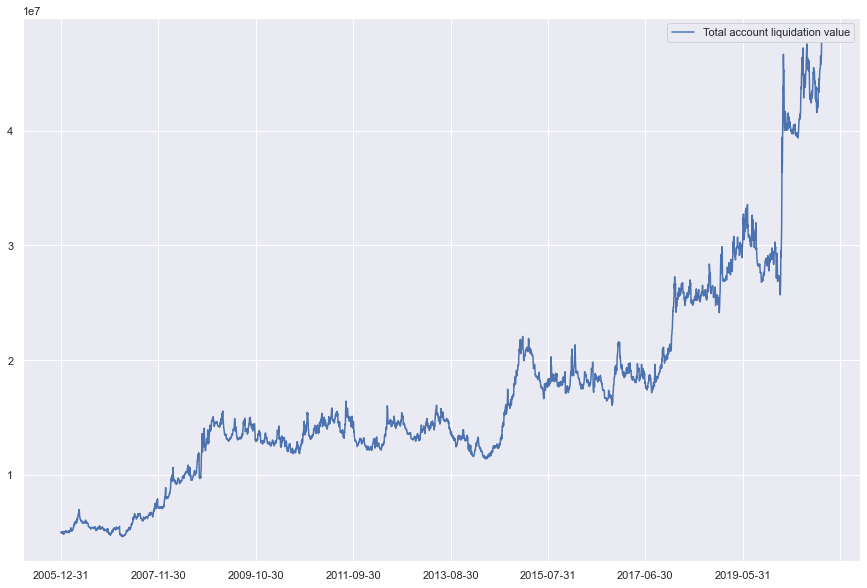

In [13]:
# Plot equity curve
all_trades[1].plot(figsize=(15,10))

<AxesSubplot:>

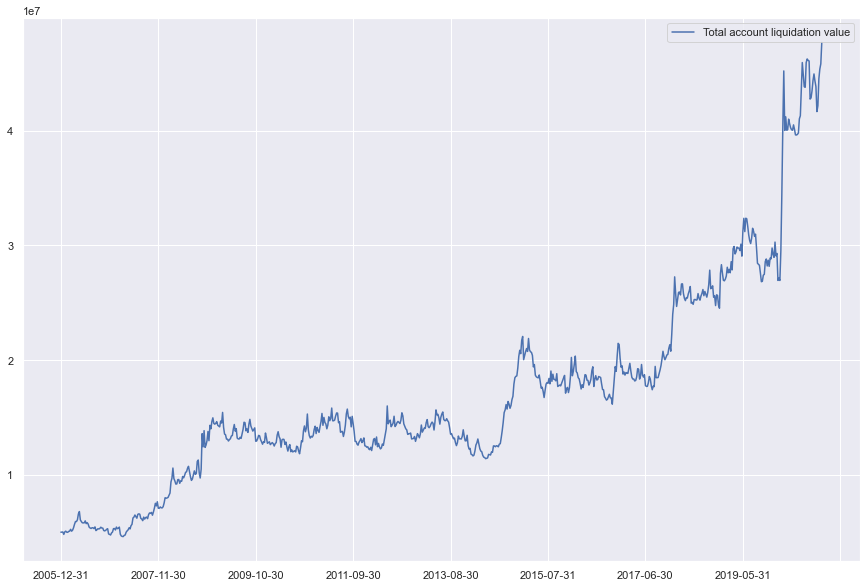

In [14]:
# Plot equity curve sampled at every 5 days
all_trades[1][::5].plot(figsize=(15,10))

<AxesSubplot:>

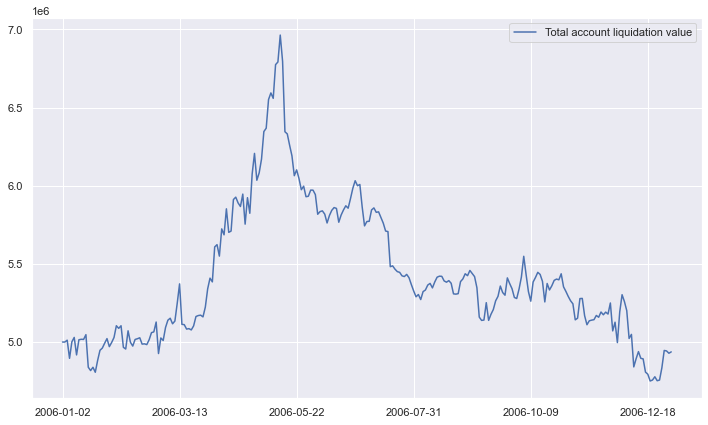

In [15]:
#YEAR BY YEAR REVIEW
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------
#2006
all_trades[1]['2006-01-01':'2007-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

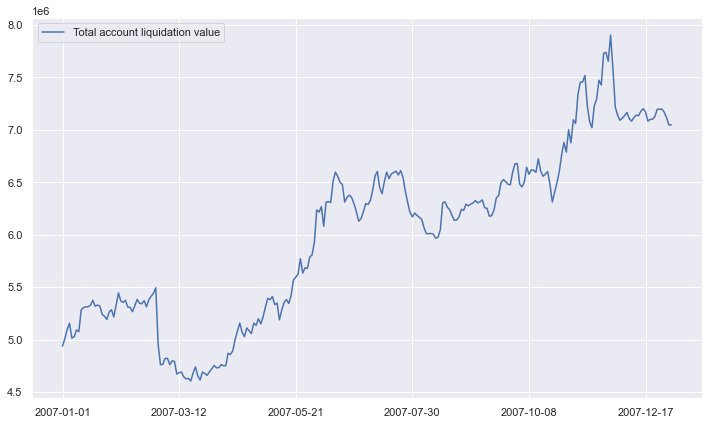

In [16]:
#2007
all_trades[1]['2007-01-01':'2008-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

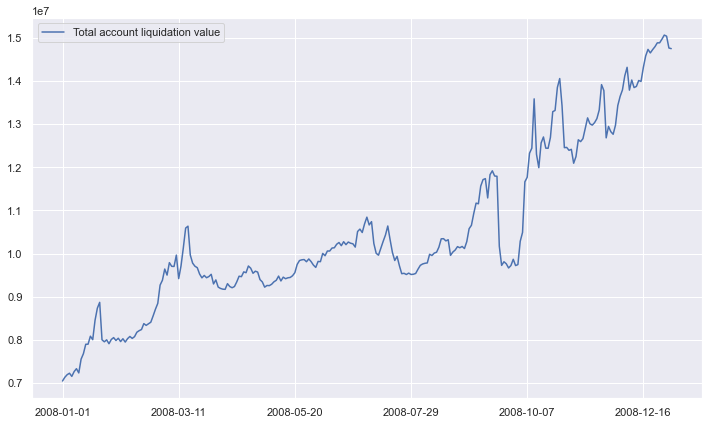

In [17]:
#2008
all_trades[1]['2008-01-01':'2009-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

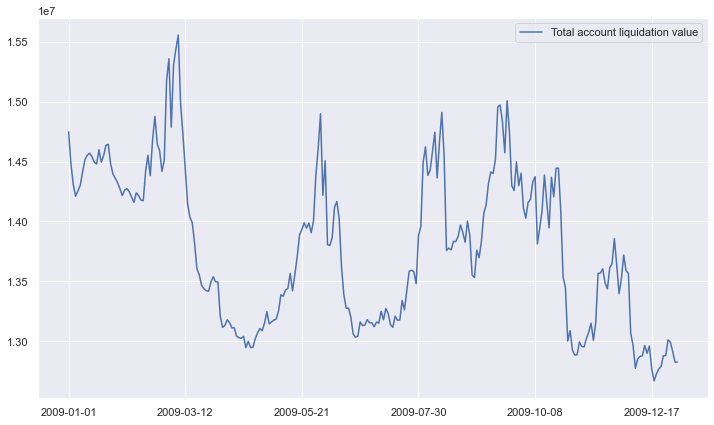

In [18]:
#2009
all_trades[1]['2009-01-01':'2010-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

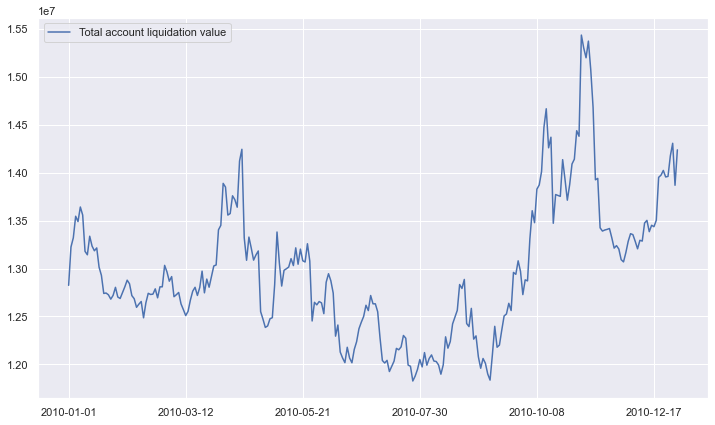

In [19]:
#2010
all_trades[1]['2010-01-01':'2011-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

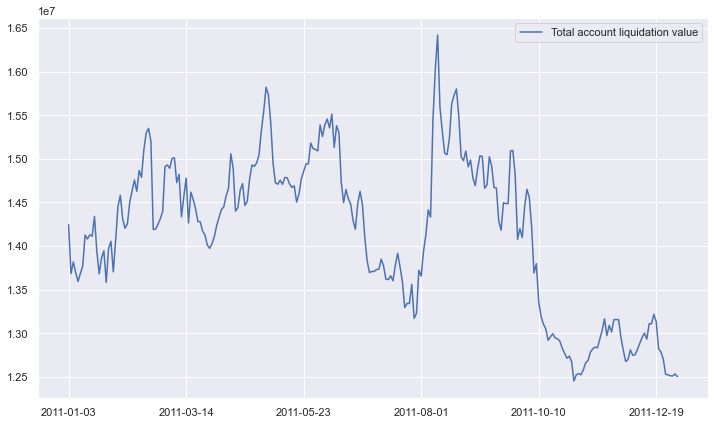

In [20]:
#2011
all_trades[1]['2011-01-01':'2012-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

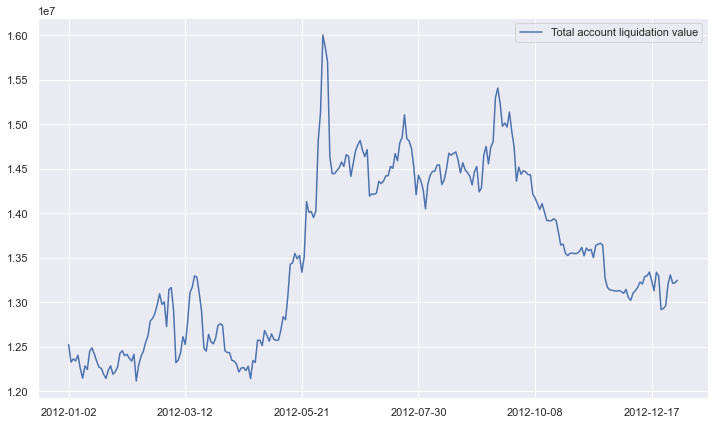

In [21]:
#2012
all_trades[1]['2012-01-01':'2013-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

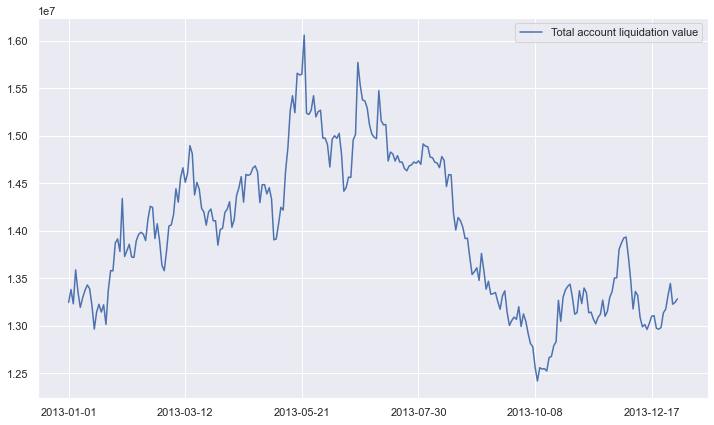

In [22]:
#2013
all_trades[1]['2013-01-01':'2014-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

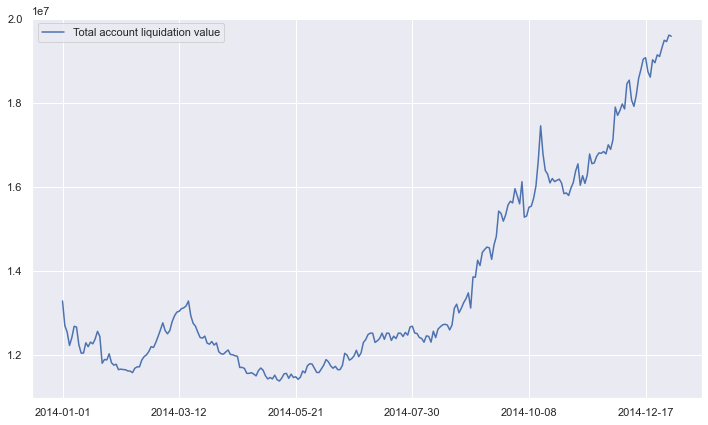

In [23]:
#2014
all_trades[1]['2014-01-01':'2015-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

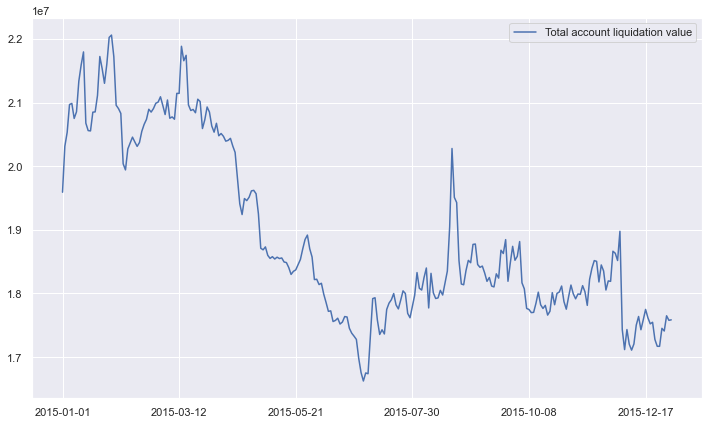

In [24]:
#2015
all_trades[1]['2015-01-01':'2016-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

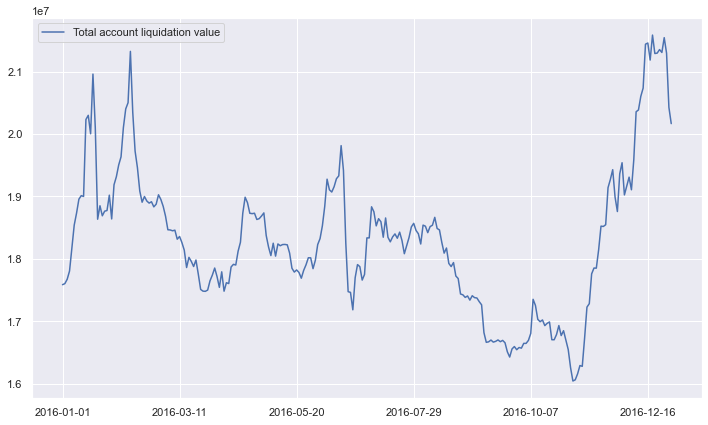

In [25]:
#2016
all_trades[1]['2016-01-01':'2017-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

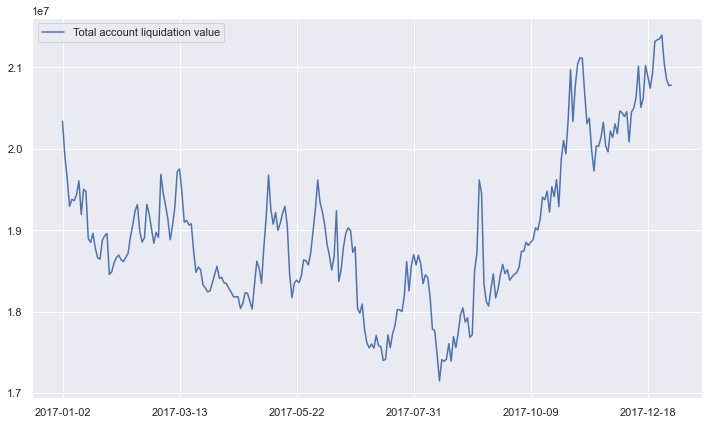

In [26]:
#2017
all_trades[1]['2017-01-01':'2018-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

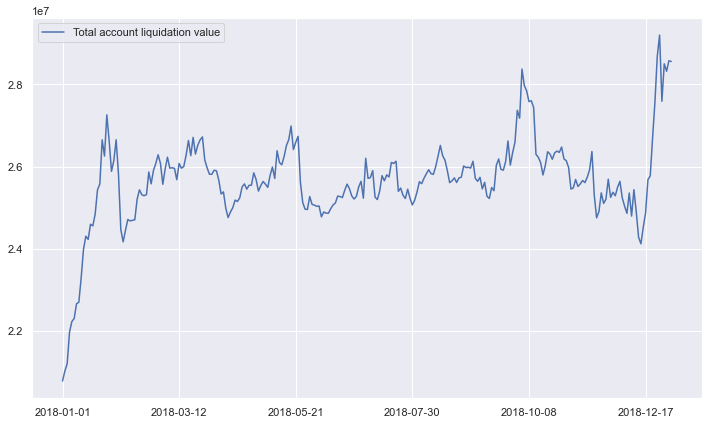

In [27]:
#2018
all_trades[1]['2018-01-01':'2019-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

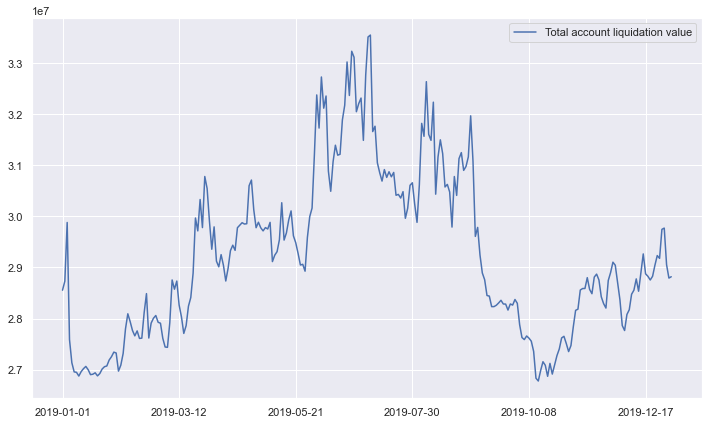

In [28]:
#2019
all_trades[1]['2019-01-01':'2020-01-01'].plot(figsize=(12,7))

<AxesSubplot:>

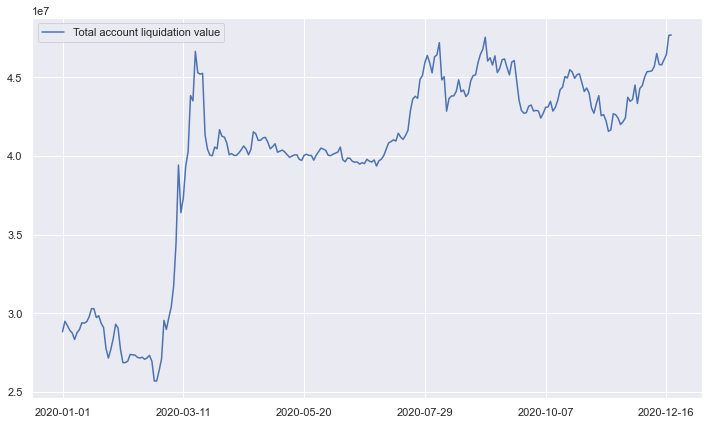

In [29]:
#2020
all_trades[1]['2020-01-01':].plot(figsize=(12,7))

In [30]:
import datetime
startyear = 2006
endyear = 2021
listofdates = [str(datetime.date(startyear + m//12,m%12+1,1)) for m in range((endyear-startyear)*12)]


In [31]:
# Get monthly equity curve
monthly_equity = pd.DataFrame({'Total account liquidation value':5000000},index=['2005-12-31'])
for i in range(len(listofdates)):
    try:
        monthly_equity = monthly_equity.append(all_trades[1].loc[listofdates[i]])
    except:
        try:
            monthly_equity = monthly_equity.append(all_trades[1].loc[listofdates[i][:8] + '02'])
        except:
            try:
                monthly_equity = monthly_equity.append(all_trades[1].loc[listofdates[i][:8] + '03'])
            except:
                pass
            
    
monthly_equity

Total account liquidation value
2005-12-31                     5.000000e+06
2006-01-02                     5.000000e+06
2006-02-01                     5.029285e+06
2006-03-01                     5.026066e+06
2006-04-03                     5.608418e+06
...                                     ...
2020-08-03                     4.528828e+07
2020-09-01                     4.679365e+07
2020-10-01                     4.290312e+07
2020-11-02                     4.400328e+07
2020-12-01                     4.430042e+07

[181 rows x 1 columns]

In [282]:
# Write monthly equity curve to a csv file
monthly_equity.to_csv('monthlyequity.csv')